In [ ]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 11 09:52:03 2017


@author: ncaplar


When preparing this notebook I used a number of jupyer extensions:
https://github.com/ipython-contrib/jupyter_contrib_nbextensions
https://github.com/Jupyter-contrib/jupyter_nbextensions_configurator

"""
%connect_info

# <span class="mark">Modeling PSF pupil and creating one realistic image</span>

In [ ]:
"""
(Re-)Created on Mon Sep 23 18:59 2017

@author: ncaplar@princeton.edu

Goals
1. Creating single pupil
    -using HSC scales
    -using PFS scales 
    
This is done, perhaps not correct roations and movement in focal plane

2. Create a single image which looks kinda like the real data
3. 

"""

In [ ]:
from __future__ import absolute_import, division, print_function

import lmfit
import galsim
import numpy as np

import astropy
from astropy.io import fits

import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

##  <span style="color:red">Creating single pupil - done, for HSC size - deprecated</span>

In [ ]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale



class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """
        print(self.u)
        print(self.v)
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        """
        x21 = int(np.floor(p0[0]-r/2))
        x22 = int(np.ceil(p0[0]+r/2))
        y21 = int(np.floor(p0[1]-r/2))
        y22 = int(np.ceil(p0[1]+r/2))
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False

    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize, npix,input_angle)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    telescopeDiameter = 8.3  # meters

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        print(parAng)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        subaruRadius = self.telescopeDiameter/2

        hscFrac = 0.231  # linear fraction
        # radius of HSC camera shadow in meters
        hscRadius = hscFrac * subaruRadius

        subaruStrutThick = 0.22  # meters

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 3600
        thetaY = point.getY() * hscPlateScale / 3600

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        lensX = thetaX * lensRate
        lensY = thetaY * lensRate
        self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

In [ ]:
HscPupil=PFSPupilFactory(8.3,100,np.pi/2)
point=Point2D(0,0)
HscPupil.getPupil(point)
pupil=HscPupil.getPupil(point)
plt.imshow(HscPupil.getPupil(point).illuminated, cmap='gray')

## <span class="burk">Creating single pupil, PFS size</span>

In [ ]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale



class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize, npix,input_angle)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    #I do not use this at the moment; telescope Diameter is set to be same as the pupil size
    #telescopeDiameter = 0.3  # meters


    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = self.pupilSize/2

        hscFrac = 0.49  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        strutFrac=0.05
        subaruStrutThick = strutFrac*subaruRadius# meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 3600
        thetaY = point.getY() * hscPlateScale / 3600

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        lensX = thetaX * lensRate
        lensY = thetaY * lensRate
        self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

In [ ]:
TestPupil=PFSPupilFactory(0.3,200,np.pi/2)
point=Point2D(5000,5000)
pupil=TestPupil.getPupil(point)
fig = plt.figure(figsize=(4, 3.2))
plt.imshow(pupil.illuminated, cmap='gray')
fig.savefig('/home/caplarn/Documents/PFS/Images/Pupil00.png')

## Ok - create array of pupils and "experimentally" deduce which one we need - WIP

In [ ]:
"""
(Re-)Created on Mon Sep 23 19:56 2017

@author: ncaplar@princeton.edu


Dependencies:
9.2


Goals

"""

### Import data 

In [ ]:
data=fits.open('/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata=data[1].data
mask=data[2].data
vardata=data[3].data


In [ ]:
#Collumns in which there is data
pos_x_of_donuts=np.where(scidata.max(axis=0)>100)
idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
idx=np.insert(idx,0,1)
#This gives position of the collumns 
pos_x_of_donuts_subarray=[]
for i in range(len(idx)-1):
    pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1]+1)]))
    pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)
onefiber_x_position=int(pos_x_of_donuts_subarray[0])    
onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]
#Select also the same position in the variance image
onefiber_var=vardata[:,onefiber_x_position-20:onefiber_x_position+20]
pos_y_of_donuts=np.where(onefiber.max(axis=1)>50)
idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
idy=np.insert(idy,0,1)
#This gives position of rows 
pos_y_of_donuts_subarray=[]
pos_y_of_donuts_subarray_len=[]
for i in range(len(idy)-1):
    pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)

In [ ]:
plt.hist(pos_y_of_donuts_subarray_len, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [ ]:
#Cutting above 30 pixels in this example (keep the one at 29 pixels just to see what happens)

In [ ]:
pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[pos_y_of_donuts_subarray_len<30]

In [ ]:
scidata_cuts=[[]]
vardata_cuts=[[]]
for i in range(len(pos_y_of_donuts_subarray_single_donut)-1):
    single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20):(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
    scidata_cuts=np.append(scidata_cuts,single_scidata_cut)
for i in range(len(pos_y_of_donuts_subarray_single_donut)-1):
    single_vardata_cut=onefiber_var[(int(pos_y_of_donuts_subarray_single_donut[i])-20):(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
    vardata_cuts=np.append(vardata_cuts,single_vardata_cut)    

In [ ]:
scidata_cuts12=np.split(scidata_cuts,11)
for i in range(len(scidata_cuts12)-1):
    scidata_cuts12[i]=scidata_cuts12[i].reshape(40,40)
vardata_cuts12=np.split(vardata_cuts,11)
for i in range(len(vardata_cuts12)-1):
    vardata_cuts12[i]=vardata_cuts12[i].reshape(40,40)    

In [ ]:
for ima in range(0,len(scidata_cuts12)-1):
    plt.figure()
    plt.imshow(scidata_cuts12[ima], cmap='gray')

In [ ]:
for ima in range(0,len(vardata_cuts12)-1):
    plt.figure()
    plt.imshow(vardata_cuts12[ima], cmap='gray')

### <span class="burk">Fitter - doesnt change pupil things, deprecated</span>

In [ ]:
class ZernikeFitter_PSF(object):
    
    """Description comes here
    """
    def __init__(self, image, pupil, diam, pixelScale=None,
                 jacobian=None,**kwargs):
        """
Description of parameters comes here
        """
        self.image = image
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        zmax=11
        self.zmax = zmax
        wavelength=800 #nm
        self.wavelength=wavelength
        
        self.aper = galsim.Aperture(
            diam = diam,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)
        self.kwargs = kwargs
    
    def initParams(self, z4Init, z4Range, zRange,
                   centroidRange, fluxRelativeRange):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        params = lmfit.Parameters()
        params.add('dx', 0.94, min=centroidRange[0], max=centroidRange[1])
        params.add('dy', 0.6, min=centroidRange[0], max=centroidRange[1])
        image = self.image
        flux = float(np.sum(image))
        self.flux=flux
        params.add('flux', flux,
                   min = fluxRelativeRange[0]*flux,
                   max = fluxRelativeRange[1]*flux)
        params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init
        #aberrations = aberrations_init+aber_4_to_11
        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        #There is a part here related to optical properties of telescope....
        # Define the optical part of the PSF:
        # The first argument of OpticalPSF below is lambda/diam (wavelength of light / telescope
        # diameter), which needs to be in the same units used to specify the image scale.  We are using
        # arcsec for that, so we have to self-consistently use arcsec here, using the following
        # calculation:
        #tel_diam = 1.          # meters
        #lam = 1000              # nm    NB: don't use lambda - that's a reserved word.
        #lam_over_diam = lam * 1.e-9 / tel_diam # radians
        #lam_over_diam *= 206265  # arcsec
        #Uncomment below to show lam_over_diam
        #print("wavelenght over diameter of the telescope is "+str(lam_over_diam)+" arcsec" )
        # The rest of the values should be given in units of the wavelength of the incident light.
        return galsim.OpticalPSF(lam=self.wavelength,diam=self.aper.diam, aberrations = aberrations,aper=self.aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])*v['flux']
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        #multiplicative_factor=np.sum(modelImg.array)
        return modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_Neven(self):
        """Do the fit
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit")
        self.result = lmfit.minimize(self._chi_Neven, self.params,method='brute',**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

### <span class="burk">Create single mock image</span>

In [ ]:
#1. Figure how to create a single reasonable mock image

In [ ]:
test_par=lmfit.Parameters()
#opens most generic parameters
file_par=open('/home/caplarn/Documents/PFS/PFS_Work_In_Progress/JSONparameters/0.json',"r")
test_par.load(file_par)
#This set flux in the simulated image to be the same as in the target image
test_par['flux'].set(np.sum(scidata_cuts12[5]))
test_par['z4'].set(0.0)
test_par['z11'].set(0.0)
#keyword diam doesnt do anything at this stage! - the size of telescope is given by pupil
single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5],pupil,diam=0.3)

In [ ]:
#test_par=result_fit_single_image.params
#I am noticing that this a lot less then in flux parameter
test_img=single_image_analysis.best_image_Neven(test_par)
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(test_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar( )
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(test_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

print(np.sum(test_img))

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)
print(np.sum(scidata_cuts12[5]))
plt.savefig('/home/caplarn/Documents/PFS/Images/Donut_Example.png')

### <span class="burk">Run a grid of parameters</span>

In [ ]:
#This code can be used to try different paramters - many attempts
matplotlib.rcParams.update({'font.size': 36})
#for PFSPF1 in range(1,6):
#    for Zernike in range(1,6):
#        if PFSPF1<=Zernike:
#            print('PFSPF1<Zernike')
#        else:
for size in np.linspace(0.2,0.5,31):
    for Defocus in np.linspace(0,0.9,91):
        HscPupil=PFSPupilFactory(0.8,200,+1.57)
        point=Point2D(0,0)
        pupil=HscPupil.getPupil(point)
        test_par=lmfit.Parameters()
        #opens most generic parameters
        file_par=open('/home/caplarn/Documents/PFS/PFS_Work_In_Progress/JSONparameters/0.json',"r")
        test_par.load(file_par)
        #This set flux in the simulated image to be the same as in the target image
        test_par['flux'].set(np.sum(scidata_cuts12[5]))
        test_par['z4'].set(Defocus)
        single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5],pupil,diam=0.3)
        test_img=single_image_analysis.best_image_Neven(test_par)
        plt.figure(figsize=(20,20))
        plt.subplot(221)
        plt.imshow(test_img, cmap='gray',vmin=1, vmax=1000)
        plt.colorbar( )
        plt.title('linear')
        plt.grid(False)
        plt.subplot(222)
        plt.imshow(test_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
        plt.colorbar()
        plt.title('log')
        plt.grid(False)
        plt.savefig('/home/caplarn/Documents/PFS/Images/TestingParamterSpace/'+'Test'+'Size'+str(size)+\
                    'Z4'+str(Defocus)+'.png')

### <span class="burk">Fit to find?</span>

In [ ]:
HscPupil=PFSPupilFactory(0.5,200,+1.5707)
point=Point2D(0,0)
pupil=HscPupil.getPupil(point)

In [ ]:
"""As creating pupil is quite high up, and I want to vary that as well, I will run fitter on a grid of pupils"""
single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5],pupil,diam=0.3)
single_image_analysis.initParams(z4Init=0.36,z4Range=(0,5),zRange=(-1,1),\
                                 centroidRange=(-5,5),fluxRelativeRange=(0,0.8))
result_fit_single_image=single_image_analysis.fit_Neven()

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
result_fit_single_image.params

In [ ]:
single_image_analysis.report()

In [ ]:
result_fit_single_image.init_vals

In [ ]:
best_img
sigma = np.sqrt(scidata_cuts12[5])
chi = (scidata_cuts12[5]- best_img)/sigma
chi_without_nan=[]
chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
np.mean((chi_without_nan)**2)

In [ ]:
# Is pupil size same as diameter of camera?...
# Fit pupil size as a parameter? (also movement of spider?)
# emcee?
#Understand comment about measuring sizes in https://jira.lsstcorp.org/browse/DM-8589 by Joshua

### <span class="burk">Creating new fitter with pupil as one of the parameters</span>

In [ ]:
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,pixelScale=None,
                 jacobian=None,**kwargs):
        """
Description of parameters comes here
        """
        self.image = image
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, z4Range, zRange,
                   centroidInit,centroidRange, fluxRelativeRange,
                   sizeInit,sizeRange,focalPlanePositionInit,focalPlanePositionRange):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        params.add('flux', self.flux,
                   min = fluxRelativeRange[0]*self.flux,
                   max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        params.add('dx', centroidInit[0], min=centroidRange[0], max=centroidRange[1])
        params.add('dy', centroidInit[1], min=centroidRange[0], max=centroidRange[1])
        params.add('size', sizeInit, min=sizeRange[0], max=sizeRange[1])
        params.add('dxFocal', focalPlanePositionInit[0], 
                   min=focalPlanePositionRange[0], max=focalPlanePositionRange[1]) 
        params.add('dyFocal', focalPlanePositionInit[1], 
           min=focalPlanePositionRange[0], max=focalPlanePositionRange[1]) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['size'.format(i)],200,np.pi/2)
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, aberrations = aberrations,aper=aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])*v['flux']
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        #multiplicative_factor=np.sum(modelImg.array)
        return modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_Neven(self):
        """Do the fit
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit")
        self.result = lmfit.minimize(self._chi_Neven, self.params,method='brute',**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

### <span class="burk">Generating a single mock image</span>

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5])
single_image_analysis.initParams(zmax=11,z4Init=0.4,z4Range=(0,5),zRange=(-1,1),
                                 centroidInit=(0,0),centroidRange=(-5,5),fluxRelativeRange=(0,1.2),
                                 sizeInit=0.3,sizeRange=(0,1,0.9),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))

In [ ]:
single_image_analysis=ZernikeFitter_PSF(scidata_cuts12[5])
#Lets hope it works
                                        

### <span class="burk">Fitting with new code</span>

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5])
single_image_analysis.initParams(zmax=11,z4Init=0.4,z4Range=(0,5),zRange=(-1,1),
                                 centroidInit=(0,0),centroidRange=(-5,5),fluxRelativeRange=(0,1.2),
                                 sizeInit=0.3,sizeRange=(0,1,0.9),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))
result_fit_single_image=single_image_analysis.fit_Neven()

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
result_fit_single_image.params

### <span class="burk">Fitting with emcee</span>

In [ ]:
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,pixelScale=None,
                 jacobian=None,**kwargs):
        """
Description of parameters comes here
        """
        self.image = image
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, z4Range, zRange,
                   centroidInit,centroidRange,
                   sizeInit,sizeRange,focalPlanePositionInit,focalPlanePositionRange):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        params.add('dx', centroidInit[0], min=centroidRange[0], max=centroidRange[1])
        params.add('dy', centroidInit[1], min=centroidRange[0], max=centroidRange[1])
        params.add('size', sizeInit, min=sizeRange[0], max=sizeRange[1])
        params.add('dxFocal', focalPlanePositionInit[0], 
                   min=focalPlanePositionRange[0], max=focalPlanePositionRange[1]) 
        params.add('dyFocal', focalPlanePositionInit[1], 
           min=focalPlanePositionRange[0], max=focalPlanePositionRange[1]) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['size'.format(i)],100,np.pi/2)
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, aberrations = aberrations,aper=aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        multiplicative_factor=self.flux/np.sum(modelImg.array)
        return multiplicative_factor*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
        """   
    def lnlike_Neven(self, params):
 

      
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return -(1/2)*(np.sum(chi_without_nan**2))
   """   
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=52,burn=250, steps=2000, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

In [ ]:
galsim.GSParams.maximum_fft_size=12000
np.seterr(divide='ignore', invalid='ignore')

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],epsfcn=0.1)
single_image_analysis.initParams(zmax=11,z4Init=0.0,z4Range=(0,3),zRange=(-1,1),
                                 centroidInit=(0,0),centroidRange=(-5,5),
                                 sizeInit=0.3,sizeRange=(0.2,0.7),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))
result_fit_single_image=single_image_analysis.fit_LM()

In [ ]:
parz4Init=np.random.uniform(size=52)
parz5Init=np.random.randint(low=-10, high=10, size=52)/100
parz6Init=np.random.randint(low=-10, high=10, size=52)/100
parz7Init=np.random.randint(low=-10, high=10, size=52)/100
parz8Init=np.random.randint(low=-10, high=10, size=52)/100
parz9Init=np.random.randint(low=-10, high=10, size=52)/100
parz10Init=np.random.randint(low=-10, high=10, size=52)/100
parz11Init=np.random.randint(low=-10, high=10, size=52)/100
pardxInit=np.random.randint(low=-100, high=100, size=52)/100
pardyInit=np.random.randint(low=-100, high=100, size=52)/100
parsizeInit=np.random.randint(low=20, high=70, size=52)/100
pardxFocalInit=np.random.randint(low=-1000, high=1000, size=52)
pardyFocalInit=np.random.randint(low=-1000, high=1000, size=52)
par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,
                              parz10Init,parz11Init,pardxInit,pardyInit,parsizeInit,
                             pardxInit,pardyInit))
parInit=par_together.reshape(52,13)
parInit.shape

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],pos=parInit)
single_image_analysis.initParams(zmax=11,z4Init=0.38,z4Range=(0,5),zRange=(-1,1),
                                 centroidInit=(0.64,-0.01),centroidRange=(-5,5),
                                 sizeInit=0.25,sizeRange=(0.2,0.7),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))
result_fit_single_image=single_image_analysis.fit_emcee()

In [ ]:
parInit

In [ ]:
lmfit.report_fit(result_fit_single_image.params)

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)
print(np.sum(best_img))
np.sum(scidata_cuts12[5])

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
lmfit.report_fit(result_fit_single_image.params)

### What does changing each parameter do? - turned into experimenting with size of telescope

In [ ]:
# Run import data from 9.3.1
# Run first two cells from 9.3.13 beforhand


In [ ]:
numberOfWalkers=14*16
parz4Init=np.random.randint(low=-200, high=200, size=numberOfWalkers)/100
parz5Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz6Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz7Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz8Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz9Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz10Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz11Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
pardxInit=np.random.randint(low=-300, high=300, size=numberOfWalkers)/100
pardyInit=np.random.randint(low=-300, high=300, size=numberOfWalkers)/100
parhscFracInit=np.random.randint(low=0, high=80, size=numberOfWalkers)/100
parstrutFracInit=np.random.randint(low=0, high=20, size=numberOfWalkers)/100
pardxFocalInit=np.random.randint(low=-5000, high=5000, size=numberOfWalkers)
pardyFocalInit=np.random.randint(low=-5000, high=5000, size=numberOfWalkers)
par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,
                              parz10Init,parz11Init,pardxInit,pardyInit,parhscFracInit,parstrutFracInit,
                              pardxFocalInit,pardyFocalInit))
parInit=par_together.reshape(numberOfWalkers,14)
parInit.shape

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],vardata_cuts12[5],pos=parInit)
single_image_analysis.initParams(zmax=11,z4Init=0.0,z4Range=(0,5),zRange=(-1,1),
                                 centroidInit=(0.0,0.0),centroidRange=(-5,5),
                                 hscFracInit=0.25,hscFracRange=(0,1),strutFracInit=0.1,strutFracRange=(0,0.2),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))

In [ ]:
single_image_analysis.params['z4'].set(0.8)
single_image_analysis.params['z5'].set(0.0)
single_image_analysis.params['z6'].set(0.0)
single_image_analysis.params['z7'].set(0.0)
single_image_analysis.params['z11'].set(0)
single_image_analysis.params['dx'].set(0)
single_image_analysis.params['hscFrac'].set(2)
single_image_analysis.params['strutFrac'].set(0)
single_image_analysis.params['dxFocal'].set(0)
best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)

In [ ]:
TestPupil=PFSPupilFactory(0.5,100,np.pi/2,
                          single_image_analysis.params['hscFrac'.format(i)].value,
                          single_image_analysis.params['strutFrac'.format(i)].value)
point=Point2D(single_image_analysis.params['dxFocal'.format(i)].value,
              single_image_analysis.params['dyFocal'.format(i)].value)
pupil=TestPupil.getPupil(point)
fig = plt.figure(figsize=(4, 3.2))
plt.imshow(pupil.illuminated, cmap='gray')
#fig.savefig('/home/caplarn/Documents/PFS/Images/Pupil00.png')

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(best_img)
plt.colorbar()

In [ ]:
single_image_analysis.params

#### Ok, there is deep problem

##### I am adding size as one of the fit parameters (sic!)

In [ ]:
# making 10 times larger mirror and 10 larger wavelength

In [ ]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale



class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = self.pupilSize/2

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius# meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 360
        thetaY = point.getY() * hscPlateScale / 360

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        #No vignetting for the spectroscope - If I understood J. Gunn correctly
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

In [ ]:
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,image_var,pixelScale=None,
                 jacobian=None,**kwargs):
        """
    Description of parameters comes here
        """
        self.image = image
        self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, z4Range, zRange,
                   centroidInit,centroidRange,
                   hscFracInit,hscFracRange,strutFracInit,strutFracRange,
                   focalPlanePositionInit,focalPlanePositionRange,diam_sicInit,diam_sic_range):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        params.add('dx', centroidInit[0], min=centroidRange[0], max=centroidRange[1])
        params.add('dy', centroidInit[1], min=centroidRange[0], max=centroidRange[1])
        params.add('hscFrac', hscFracInit, min=hscFracRange[0], max=hscFracRange[1])
        params.add('strutFrac', strutFracInit, min=strutFracRange[0], max=strutFracRange[1])
        params.add('dxFocal', focalPlanePositionInit[0], 
                   min=focalPlanePositionRange[0], max=focalPlanePositionRange[1]) 
        params.add('dyFocal', focalPlanePositionInit[1], 
           min=focalPlanePositionRange[0], max=focalPlanePositionRange[1]) 
        params.add('diam_sic', diam_sicInit, 
           min=diam_sic_range[0], max=diam_sic_range[1]) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['diam_sic'.format(i)],512,np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, aberrations = aberrations,aper=aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        multiplicative_factor=self.flux/np.sum(modelImg.array)
        return multiplicative_factor*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
        """   
    def lnlike_Neven(self, params):
 

      
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return -(1/2)*(np.sum(chi_without_nan**2))
   """   
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=240,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

In [ ]:
numberOfWalkers=15*16
parz4Init=np.random.randint(low=0, high=1500, size=numberOfWalkers)/100
parz5Init=np.random.randint(low=-50, high=50, size=numberOfWalkers)/100
parz6Init=np.random.randint(low=-50, high=50, size=numberOfWalkers)/100
parz7Init=np.random.randint(low=-50, high=50, size=numberOfWalkers)/100
parz8Init=np.random.randint(low=-50, high=50, size=numberOfWalkers)/100
parz9Init=np.random.randint(low=-50, high=50, size=numberOfWalkers)/100
parz10Init=np.random.randint(low=-50, high=50, size=numberOfWalkers)/100
parz11Init=np.random.randint(low=-50, high=50, size=numberOfWalkers)/100
pardxInit=np.random.randint(low=-200, high=200, size=numberOfWalkers)/100
pardyInit=np.random.randint(low=-200, high=200, size=numberOfWalkers)/100
parhscFracInit=np.random.randint(low=0, high=120, size=numberOfWalkers)/100
parstrutFracInit=np.random.randint(low=0, high=30, size=numberOfWalkers)/100
pardxFocalInit=np.random.randint(low=-7000, high=7000, size=numberOfWalkers)
pardyFocalInit=np.random.randint(low=-7000, high=7000, size=numberOfWalkers)
pardiamsicInit=np.random.randint(low=10, high=800, size=numberOfWalkers)/100
par_together=np.column_stack((parz4Init,
                              pardxInit,pardyInit,parhscFracInit,parstrutFracInit,
                              pardxFocalInit,
                              pardyFocalInit,
                              pardiamsicInit))
parInit=par_together.reshape(numberOfWalkers,8)
parInit.shape

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],vardata_cuts12[5],pos=parInit)
single_image_analysis.initParams(zmax=4,z4Init=0.0,z4Range=(0,15),zRange=(-0.5,0.5),
                                 centroidInit=(0.0,0.0),centroidRange=(-2,2),
                                 hscFracInit=0.25,hscFracRange=(0,1.2),strutFracInit=0.1,strutFracRange=(0,0.3),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-7000,7000),
                                diam_sicInit=1,diam_sic_range=(0.1,8))

In [ ]:
single_image_analysis.params['z4'].set(3.1)
#single_image_analysis.params['z5'].set(0.0)
#single_image_analysis.params['z6'].set(0.0)
#single_image_analysis.params['z7'].set(0.0)
#single_image_analysis.params['z11'].set(0)
single_image_analysis.params['dx'].set(0)
single_image_analysis.params['hscFrac'].set(0.7)
single_image_analysis.params['strutFrac'].set(0.5)
single_image_analysis.params['dxFocal'].set(-3000)
single_image_analysis.params['dyFocal'].set(0)
single_image_analysis.params['diam_sic'].set(1.8)

In [ ]:
single_image_analysis.params

In [ ]:
best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)

In [ ]:
TestPupil=PFSPupilFactory(single_image_analysis.params['diam_sic'.format(i)].value,400,np.pi/2,
                          single_image_analysis.params['hscFrac'.format(i)].value,
                          single_image_analysis.params['strutFrac'.format(i)].value)
point=Point2D(single_image_analysis.params['dxFocal'.format(i)].value,
              single_image_analysis.params['dyFocal'.format(i)].value)
pupil=TestPupil.getPupil(point)
fig = plt.figure(figsize=(4, 3.2))
plt.imshow(pupil.illuminated, cmap='gray')
#fig.savefig('/home/caplarn/Documents/PFS/Images/Pupil00.png')

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(best_img)
plt.colorbar()

In [ ]:
galsim.GSParams.maximum_fft_size=12000
np.seterr(divide='ignore', invalid='ignore')

In [ ]:
result_fit_single_image=single_image_analysis.fit_emcee()

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)
print(np.mean((single_image_analysis._chi_Neven(result_fit_single_image.params)**2)))
print(np.sum(best_img))
np.sum(scidata_cuts12[5])

In [ ]:
image_for_plot=scidata_cuts12[5]
thresh=1
threshold_indices = image_for_plot[5] <= thresh
image_for_plot[5][threshold_indices] = 1

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
thresh=1
threshold_indices = residual_img <= thresh
residual_img[threshold_indices] = 1
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
result_fit_single_image.params

#### Manually playing

In [ ]:
result_fit_single_image.params

In [ ]:
result_fit_single_image.params['z4'].set(6.5)
result_fit_single_image.params['z4'].set(max=26)
result_fit_single_image.params['dx'].set(1.1)
result_fit_single_image.params['strutFrac'].set(.12)
result_fit_single_image.params['diam_sic'].set(4)
result_fit_single_image.params['diam_sic'].set(max=8)

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)
print(np.mean((single_image_analysis._chi_Neven(result_fit_single_image.params)**2)))

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)
thresh=1
threshold_indices = best_img <= thresh
best_img[threshold_indices] = 1
threshold_indices = residual_img <= thresh
residual_img[threshold_indices] = 1
plt.figure(figsize=(20,20))
plt.subplot(321)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear - Original')
plt.grid(False)
plt.subplot(322)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log - Original')
plt.figure(figsize=(20,20))
plt.subplot(323)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear - Model')
plt.subplot(324)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log - Model')
plt.subplot(325)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear - Residual')
plt.subplot(326)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log - Residual')


### Quantify how do donuts change on a single image 

In [ ]:
data=fits.open('/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata=data[1].data
vardata=data[3].data

In [ ]:
data=fits.open('/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata=data[1].data
vardata=data[3].data
#Collumns in which there is data
pos_x_of_donuts=np.where(scidata.max(axis=0)>100)
#how wide is each column
idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
#prepand to get the first column of data
idx=np.insert(idx,0,1)
#postpend to get the last column of data - that is just length of the array describing positions
idx=np.append(idx,len(pos_x_of_donuts[0]))
#This gives position of the collumns 
pos_x_of_donuts_subarray=[]
for i in range(len(idx)-1):
    pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1])]))
    pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)

pos_xy_all_col=[]    
scidata_cuts_all_col=[]
vardata_cuts_all_col=[]
    
for j in range(0,len(pos_x_of_donuts_subarray)):    
    onefiber_x_position=int(pos_x_of_donuts_subarray[j])    
    onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]
    onefiberVar=vardata[:,onefiber_x_position-20:onefiber_x_position+20]
    pos_y_of_donuts=np.where(onefiber.max(axis=1)>70)
    idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
    idy=np.insert(idy,0,1)
    idy=np.append(idy,len(pos_y_of_donuts[0]))
    #This gives position of rows 
    pos_y_of_donuts_subarray=[]
    pos_y_of_donuts_subarray_len=[]
    for i in range(len(idy)-1):
        pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,
                                           np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1])]))
        pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,
                                               len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1])]))
        pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)    

    pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[(pos_y_of_donuts_subarray_len<27)
                                                                   &(pos_y_of_donuts_subarray_len>10)]    

    pos_x_single_col=np.full_like(pos_y_of_donuts_subarray_single_donut,pos_x_of_donuts_subarray[j])
    pos_xy_single_col=np.column_stack((pos_x_single_col,pos_y_of_donuts_subarray_single_donut))
    pos_xy_all_col.append(pos_xy_single_col)
    
    scidata_cuts=[]
    vardata_cuts=[]
    number_of_donuts_in_this_column=len(pos_y_of_donuts_subarray_single_donut)-1
    for i in range(number_of_donuts_in_this_column):
        single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20)
                                    :(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
        single_vardata_cut=onefiberVar[(int(pos_y_of_donuts_subarray_single_donut[i])-20)
                            :(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
        scidata_cuts.append(single_scidata_cut)
        vardata_cuts.append(single_vardata_cut)


    scidata_cuts_all_col.append(scidata_cuts)
    vardata_cuts_all_col.append(vardata_cuts)
    
    
    

In [ ]:
def find_data(scidata):
    #Collumns in which there is data
    pos_x_of_donuts=np.where(scidata.max(axis=0)>100)
    #how wide is each column
    idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
    #prepand to get the first column of data
    idx=np.insert(idx,0,1)
    #postpend to get the last column of data - that is just length of the array describing positions
    idx=np.append(idx,len(pos_x_of_donuts[0]))
    #This gives position of the collumns 
    pos_x_of_donuts_subarray=[]
    for i in range(len(idx)-1):
        pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1])]))
        pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)

    pos_xy_all_col=[]    
    scidata_cuts_all_col=[]

    for j in range(0,len(pos_x_of_donuts_subarray)):    
        onefiber_x_position=int(pos_x_of_donuts_subarray[j])    
        onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]
        pos_y_of_donuts=np.where(onefiber.max(axis=1)>70)
        idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
        idy=np.insert(idy,0,1)
        idy=np.append(idy,len(pos_y_of_donuts[0]))
        #This gives position of rows 
        pos_y_of_donuts_subarray=[]
        pos_y_of_donuts_subarray_len=[]
        for i in range(len(idy)-1):
            pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,
                                               np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1])]))
            pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,
                                                   len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1])]))
            pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)    

        pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[(pos_y_of_donuts_subarray_len<27)
                                                                       &(pos_y_of_donuts_subarray_len>10)]    

        pos_x_single_col=np.full_like(pos_y_of_donuts_subarray_single_donut,pos_x_of_donuts_subarray[j])
        pos_xy_single_col=np.column_stack((pos_x_single_col,pos_y_of_donuts_subarray_single_donut))
        pos_xy_all_col.append(pos_xy_single_col)

        scidata_cuts=[]
        number_of_donuts_in_this_column=len(pos_y_of_donuts_subarray_single_donut)-1
        for i in range(number_of_donuts_in_this_column):
            single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20)
                                        :(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
            scidata_cuts.append(single_scidata_cut)


        scidata_cuts_all_col.append(scidata_cuts)
    return pos_xy_all_col

In [ ]:
fiber=9
donut_in_fiber=1
plt.title(str(pos_xy_all_col[fiber][donut_in_fiber]))
plt.imshow(scidata_cuts_all_col[fiber][donut_in_fiber])

In [ ]:
fig=plt.figure(figsize=(100,20))
fig.subplots_adjust(hspace=0.4,wspace=0.4)
donut_in_fiber=0
for i in range(1,10):
    ax=fig.add_subplot(1,9,i)
    ax.set_title(str(pos_xy_all_col[i][donut_in_fiber]),fontsize=65)
    ax.imshow(scidata_cuts_all_col[i][donut_in_fiber])

  

In [ ]:
fig=plt.figure(figsize=(100,20))
fig.subplots_adjust(hspace=0.4,wspace=0.4)
donut_in_fiber=-1
for i in range(1,10):
    ax=fig.add_subplot(1,9,i)
    ax.set_title(str(pos_xy_all_col[i][donut_in_fiber]),fontsize=65)
    ax.imshow(scidata_cuts_all_col[i][donut_in_fiber])  

In [ ]:
fig=plt.figure(figsize=(100,20))
fig.subplots_adjust(hspace=0.4,wspace=0.4)
donut_in_fiber=0
for donut_in_fiber in range(1,9):
    ax=fig.add_subplot(1,9,donut_in_fiber)
    ax.set_title(str(pos_xy_all_col[5][donut_in_fiber]),fontsize=65)
    ax.imshow(scidata_cuts_all_col[5][donut_in_fiber])


In [ ]:
fig=plt.figure(figsize=(100,20))
fig.subplots_adjust(hspace=0.4,wspace=0.4)

for donut_in_fiber in range(1,8):
    ax=fig.add_subplot(1,8,donut_in_fiber)
    ax.set_title(str(pos_xy_all_col[0][donut_in_fiber]),fontsize=65)
    ax.imshow(scidata_cuts_all_col[0][donut_in_fiber])


In [ ]:
fig=plt.figure(figsize=(100,20))
fig.subplots_adjust(hspace=0.4,wspace=0.4)
for donut_in_fiber in range(1,8):
    ax=fig.add_subplot(1,8,donut_in_fiber)
    ax.set_title(str(pos_xy_all_col[9][donut_in_fiber]),fontsize=65)
    ax.imshow(scidata_cuts_all_col[9][donut_in_fiber])


In [ ]:
# plan is to have two tables, one with positions and one with images itself

### Illumination in different images - work in progress, need different focus images

In [ ]:
data=fits.open('/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata3617=data[1].data
data=fits.open('/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003618/PFLAr1.fits')
scidata3618=data[1].data
data=fits.open('/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003619/PFLAr1.fits')
scidata3619=data[1].data
data=fits.open('/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003634/PFLAr1.fits')
scidata3634=data[1].data
data=fits.open('/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003635/PFLAr1.fits')
scidata3635=data[1].data
data=fits.open('/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003636/PFLAr1.fits')
scidata3636=data[1].data

In [ ]:
def find_data(scidata):
    #Collumns in which there is data
    pos_x_of_donuts=np.where(scidata.max(axis=0)>100)
    #how wide is each column
    idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
    #prepand to get the first column of data
    idx=np.insert(idx,0,1)
    #postpend to get the last column of data - that is just length of the array describing positions
    idx=np.append(idx,len(pos_x_of_donuts[0]))
    #This gives position of the collumns 
    pos_x_of_donuts_subarray=[]
    for i in range(len(idx)-1):
        pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1])]))
        pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)
        pos_x_of_donuts_subarray= [x for x in pos_x_of_donuts_subarray if str(x) !='nan'] 

    pos_xy_all_col=[]    
    scidata_cuts_all_col=[]

    for j in range(0,len(pos_x_of_donuts_subarray)): 
        onefiber_x_position=int(pos_x_of_donuts_subarray[j])
        onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]
        pos_y_of_donuts=np.where(onefiber.max(axis=1)>70)
        idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
        idy=np.insert(idy,0,1)
        idy=np.append(idy,len(pos_y_of_donuts[0]))
        #This gives position of rows 
        pos_y_of_donuts_subarray=[]
        pos_y_of_donuts_subarray_len=[]
        for i in range(len(idy)-1):
            pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,
                                               np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1])]))
            pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,
                                                   len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1])]))
            pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)    

        pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[(pos_y_of_donuts_subarray_len<27)
                                                                       &(pos_y_of_donuts_subarray_len>10)]    

        pos_x_single_col=np.full_like(pos_y_of_donuts_subarray_single_donut,pos_x_of_donuts_subarray[j])
        pos_xy_single_col=np.column_stack((pos_x_single_col,pos_y_of_donuts_subarray_single_donut))
        pos_xy_all_col.append(pos_xy_single_col)

        scidata_cuts=[]
        number_of_donuts_in_this_column=len(pos_y_of_donuts_subarray_single_donut)-1
        for i in range(number_of_donuts_in_this_column):
            single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20)
                                        :(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
            scidata_cuts.append(single_scidata_cut)


        scidata_cuts_all_col.append(scidata_cuts)
    return pos_xy_all_col

In [ ]:
pos_x_y_3617=find_data(scidata3617)
pos_x_y_3618=find_data(scidata3618)
pos_x_y_3619=find_data(scidata3619)
pos_x_y_3634=find_data(scidata3634)
pos_x_y_3635=find_data(scidata3635)
pos_x_y_3636=find_data(scidata3636)

list_of_data=[scidata3617,scidata3618,scidata3619,scidata3634,scidata3635,scidata3636]
list_of_data_pos=[pos_x_y_3617,pos_x_y_3618,pos_x_y_3619,pos_x_y_3634,pos_x_y_3635,pos_x_y_3636]

In [ ]:
def find_data_given_pos(scidata,pos):
    return scidata[int(pos[1]-20):int(pos[1]+20),int(pos[0]-20):int(pos[0]+20)]

In [ ]:
plt.imshow(find_data_given_pos(scidata3618,pos_x_y_3618[0][0]))

In [ ]:
fig=plt.figure(figsize=(100,20))
fig.subplots_adjust(hspace=0.4,wspace=0.4)

for i in range(0,6):
    ax=fig.add_subplot(1,7,i+1)
    single_sciimage=find_data_given_pos(list_of_data[i],list_of_data_pos[i][0][0])
    ax.set_title(str(list_of_data_pos[i][0][0]),fontsize=65)
    #ax.set_title(str(pos_xy_all_col[0][donut_in_fiber]),fontsize=65)
    ax.imshow(single_sciimage)


In [ ]:
fig=plt.figure(figsize=(100,20))
fig.subplots_adjust(hspace=0.4,wspace=0.4)

for i in range(0,6):
    ax=fig.add_subplot(1,7,i+1)
    single_sciimage=find_data_given_pos(list_of_data[i],list_of_data_pos[i][2][2])
    ax.set_title(str(list_of_data_pos[i][0][0]),fontsize=65)
    #ax.set_title(str(pos_xy_all_col[0][donut_in_fiber]),fontsize=65)
    ax.imshow(single_sciimage)

### New class, insights from Jim Gunn

In [ ]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale



class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = self.pupilSize/2

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius# meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 360
        thetaY = point.getY() * hscPlateScale / 360

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        #No vignetting for the spectroscope - If I understood J. Gunn correctly
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

In [ ]:
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,image_var,pixelScale=None,
                 jacobian=None,**kwargs):
        """
    Description of parameters comes here
        """
        self.image = image
        self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, z4Range, zRange,
                   centroidInit,centroidRange,
                   hscFracInit,hscFracRange,strutFracInit,strutFracRange,
                   focalPlanePositionInit,focalPlanePositionRange,diam_sicInit,diam_sic_range):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init, min=z4Range[0], max=z4Range[1])
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0, min=zRange[0], max=zRange[1])
        params.add('dx', centroidInit[0], min=centroidRange[0], max=centroidRange[1])
        params.add('dy', centroidInit[1], min=centroidRange[0], max=centroidRange[1])
        params.add('hscFrac', hscFracInit, min=hscFracRange[0], max=hscFracRange[1])
        params.add('strutFrac', strutFracInit, min=strutFracRange[0], max=strutFracRange[1])
        params.add('dxFocal', focalPlanePositionInit[0], 
                   min=focalPlanePositionRange[0], max=focalPlanePositionRange[1]) 
        params.add('dyFocal', focalPlanePositionInit[1], 
           min=focalPlanePositionRange[0], max=focalPlanePositionRange[1]) 
        params.add('diam_sic', diam_sicInit, 
           min=diam_sic_range[0], max=diam_sic_range[1]) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['diam_sic'.format(i)],512,np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, aberrations = aberrations,aper=aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        multiplicative_factor=self.flux/np.sum(modelImg.array)
        return multiplicative_factor*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
        """   
    def lnlike_Neven(self, params):
 

      
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return -(1/2)*(np.sum(chi_without_nan**2))
   """   
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

#### Emcee

In [ ]:
galsim.GSParams.maximum_fft_size=12000
np.seterr(divide='ignore', invalid='ignore')

In [ ]:
"""
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],epsfcn=0.1)
single_image_analysis.initParams(zmax=11,z4Init=0.0,z4Range=(0,3),zRange=(-1,1),
                                 centroidInit=(0,0),centroidRange=(-5,5),hscFracInit=0.5,hscFracRange=(0,1),
                                 strutFracInit=0.1,strutFracRange=(0,1),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))
result_fit_single_image=single_image_analysis.fit_LM()
"""

In [ ]:
numberOfWalkers=14*16
parz4Init=np.random.randint(low=-200, high=200, size=numberOfWalkers)/100
parz5Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz6Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz7Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz8Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz9Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz10Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz11Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
pardxInit=np.random.randint(low=-300, high=300, size=numberOfWalkers)/100
pardyInit=np.random.randint(low=-300, high=300, size=numberOfWalkers)/100
parhscFracInit=np.random.randint(low=0, high=100, size=numberOfWalkers)/100
parstrutFracInit=np.random.randint(low=0, high=100, size=numberOfWalkers)/100
pardxFocalInit=np.random.randint(low=-4000, high=4000, size=numberOfWalkers)
pardyFocalInit=np.random.randint(low=-4000, high=4000, size=numberOfWalkers)
par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,
                              parz10Init,parz11Init,pardxInit,pardyInit,parhscFracInit,parstrutFracInit,
                              pardxFocalInit,pardyFocalInit))
parInit=par_together.reshape(numberOfWalkers,14)
parInit.shape

In [ ]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
parInit[0]

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],vardata_cuts12[5],pos=parInit)
single_image_analysis.initParams(zmax=11,z4Init=0.38,z4Range=(0,5),zRange=(-1,1),
                                 centroidInit=(0.64,-0.01),centroidRange=(-5,5),
                                 hscFracInit=0.25,hscFracRange=(0,1),strutFracInit=0.1,strutFracRange=(0,0.2),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))
result_fit_single_image=single_image_analysis.fit_emcee()

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)
print(np.sum(best_img))
np.sum(scidata_cuts12[5])

In [ ]:
image_for_plot=scidata_cuts12[5]
thresh=1
threshold_indices = image_for_plot[5] <= thresh
image_for_plot[5][threshold_indices] = 1

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
thresh=1
threshold_indices = residual_img <= thresh
residual_img[threshold_indices] = 1
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

In [ ]:
result_fit_single_image.params

In [ ]:
result_fit_single_image.params['hscFrac'.format(i)].value

In [ ]:
TestPupil=PFSPupilFactory(0.5,100,np.pi/2,
                          result_fit_single_image.params['hscFrac'.format(i)].value,
                          result_fit_single_image.params['strutFrac'.format(i)].value)
point=Point2D(result_fit_single_image.params['dxFocal'.format(i)].value,
              result_fit_single_image.params['dyFocal'.format(i)].value)
pupil=TestPupil.getPupil(point)
fig = plt.figure(figsize=(4, 3.2))
plt.imshow(pupil.illuminated, cmap='gray')
#fig.savefig('/home/caplarn/Documents/PFS/Images/Pupil00.png')

#### LM

In [ ]:
#First without fancy Zernike terms

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],vardata_cuts12[5],epsfcn=0.02)
single_image_analysis.initParams(zmax=11,z4Init=2.81,z4Range=(0,15),zRange=(-0.5,0.5),
                                 centroidInit=(1.05,0.396),centroidRange=(-3,3),
                                 hscFracInit=0.835,hscFracRange=(0,1.2),strutFracInit=0.11,strutFracRange=(0,1),
                                 focalPlanePositionInit=(-5597,1741),focalPlanePositionRange=(-7000,7000),
                                diam_sicInit=1.71,diam_sic_range=(0.1,8))
result_fit_single_image=single_image_analysis.fit_LM()

In [ ]:
result_fit_single_image.params


In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)
np.mean((single_image_analysis._chi_Neven(result_fit_single_image.params)**2))
thresh=1
threshold_indices = best_img <= thresh
best_img[threshold_indices] = 1
threshold_indices = residual_img <= thresh
residual_img[threshold_indices] = 1
plt.figure(figsize=(20,20))
plt.subplot(321)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear - Original')
plt.grid(False)
plt.subplot(322)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log - Original')
plt.figure(figsize=(20,20))
plt.subplot(323)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear - Model')
plt.subplot(324)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log - Model')
plt.subplot(325)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear - Residual')
plt.subplot(326)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log - Residual')


In [ ]:
# Add Zernike to 11

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],vardata_cuts12[5],epsfcn=0.02)
single_image_analysis.initParams(zmax=11,z4Init=9.7,z4Range=(0,15),zRange=(-0.5,0.5),
                                 centroidInit=(1.2,0.46),centroidRange=(-3,3),
                                 hscFracInit=0.88,hscFracRange=(0,1.2),strutFracInit=0.097,strutFracRange=(0,15),
                                 focalPlanePositionInit=(-5500,1534),focalPlanePositionRange=(-7000,7000),
                                diam_sicInit=5.81,diam_sic_range=(0.1,8))
result_fit_single_image=single_image_analysis.fit_LM()

In [ ]:
res_dump=result_fit_single_image.params.dumps()
result_fit_single_image.params


In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],vardata_cuts12[5],epsfcn=0.1)
single_image_analysis.params=lmfit.Parameters()
single_image_analysis.initParams(zmax=11,z4Init=9.7,z4Range=(0,15),zRange=(-0.5,0.5),
                                 centroidInit=(1.2,0.46),centroidRange=(-3,3),
                                 hscFracInit=0.88,hscFracRange=(0,1.2),strutFracInit=0.097,strutFracRange=(0,15),
                                 focalPlanePositionInit=(-5500,1534),focalPlanePositionRange=(-7000,7000),
                                diam_sicInit=5.81,diam_sic_range=(0.1,8))
single_image_analysis.params=single_image_analysis.params.loads(res_dump)

result_fit_single_image=single_image_analysis.fit_LM()



In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)
np.mean((single_image_analysis._chi_Neven(result_fit_single_image.params)**2))
chi_img=np.abs(residual_img)/vardata_cuts12[5]
thresh=0.01
threshold_indices = best_img <= thresh
best_img[threshold_indices] = 0.01
residual_img=np.abs(residual_img)
resfig=plt.figure(figsize=(20,20))
plt.subplot(421)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear - Original')
plt.grid(False)
plt.subplot(422)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log - Original')
plt.subplot(423)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear - Model')
plt.subplot(424)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log - Model')
plt.subplot(425)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear - abs(Residual)')
plt.subplot(426)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log - abs(Residual)')
plt.subplot(427)
plt.imshow(chi_img, cmap='gray',vmin=0.01, vmax=np.max(chi_img))
plt.colorbar()
plt.title('linear - abs(chi_image)')
plt.subplot(428)
plt.imshow(chi_img, cmap='gray',vmin=0.01, vmax=np.max(chi_img),norm=LogNorm())
plt.colorbar()
plt.title('log - abs(chi_image)')
resfig.savefig('/Users/nevencaplar/Documents/PFS/Images/resfig1.png')

### How do chains look like 

In [ ]:
import corner
matplotlib.rcParams.update({'font.size': 16})
figure=corner.corner(result_fit_single_image.flatchain, labels=result_fit_single_image.var_names,
                  truths=list(result_fit_single_image.params.valuesdict().values()))
figure.savefig('/Users/nevencaplar/Documents/PFS/Images/parameters.png')

### More Zernike captain, more, more!!!!

In [ ]:
numberOfWalkers=24*8
parz4Init=np.random.randint(low=-200, high=200, size=numberOfWalkers)/100
parz5Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz6Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz7Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz8Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz9Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz10Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz11Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz12Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz13Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz14Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz15Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz16Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz17Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz18Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz19Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz20Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
parz21Init=np.random.randint(low=-10, high=10, size=numberOfWalkers)/100
pardxInit=np.random.randint(low=-300, high=300, size=numberOfWalkers)/100
pardyInit=np.random.randint(low=-300, high=300, size=numberOfWalkers)/100
parhscFracInit=np.random.randint(low=0, high=80, size=numberOfWalkers)/100
parstrutFracInit=np.random.randint(low=0, high=20, size=numberOfWalkers)/100
pardxFocalInit=np.random.randint(low=-7000, high=7000, size=numberOfWalkers)
pardyFocalInit=np.random.randint(low=-7000, high=7000, size=numberOfWalkers)
par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,
                              parz10Init,parz11Init,parz12Init,parz13Init,parz14Init,parz15Init,parz16Init,parz17Init,
                              parz18Init,parz19Init,parz20Init,parz21Init,
                              pardxInit,pardyInit,parhscFracInit,parstrutFracInit,
                              pardxFocalInit,pardyFocalInit))
parInit=par_together.reshape(numberOfWalkers,24)
parInit.shape

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],vardata_cuts12[5],pos=parInit)
single_image_analysis.initParams(zmax=21,z4Init=0.38,z4Range=(0,5),zRange=(-1,1),
                                 centroidInit=(0.64,-0.01),centroidRange=(-5,5),
                                 hscFracInit=0.25,hscFracRange=(0,1),strutFracInit=0.1,strutFracRange=(0,0.2),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))
result_fit_single_image=single_image_analysis.fit_emcee()

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)
residual_img=single_image_analysis.residual_image_Neven(result_fit_single_image.params)
print(np.sum(best_img))
np.sum(scidata_cuts12[5])

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')
plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

### <span class="mark"> Speed up the code - not obvious how</span>

In [ ]:
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)

In [ ]:
sigma = np.sqrt(scidata_cuts12[5])
chi = (scidata_cuts12[5] - best_img)/sigma
chi_without_nan=[]
chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))

In [ ]:
(23*60+19)/(56*4*200)

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5][5:35,5:35],pos=parInit)
single_image_analysis.initParams(zmax=11,z4Init=0.38,z4Range=(0,5),zRange=(-1,1),
                                 centroidInit=(0.64,-0.01),centroidRange=(-5,5),
                                 hscFracInit=0.25,hscFracRange=(0,1),strutFracInit=0.1,strutFracRange=(0,0.2),
                                 focalPlanePositionInit=(0,0),focalPlanePositionRange=(-5000,5000))
best_img=single_image_analysis.best_image_Neven(result_fit_single_image.params)

In [ ]:
test_par=result_fit_single_image.params
test_par['z4'].set(1)
best_img=single_image_analysis.best_image_Neven(test_par)


In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(221)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('linear')

plt.grid(False)
plt.subplot(222)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('log')
plt.grid(False)

# <span class="mark">Emcee</span> 

In [ ]:
from __future__ import absolute_import, division, print_function

import socket
import lmfit
import galsim
galsim.GSParams.maximum_fft_size=12000
import numpy as np
np.set_printoptions(suppress=True)
import emcee
import time



import astropy
from astropy.io import fits

import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

np.seterr(divide='ignore', invalid='ignore')

### Import data

In [ ]:
if socket.gethostname()=='IapetusUSA':
    DATA_FOLDER='/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003617/'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/'
if socket.gethostname()=='tiger-sumire':
    DATA_FOLDER=''
    RESULT_FOLDER=''
data=fits.open(DATA_FOLDER+'PFLAr1.fits')
scidata=data[1].data
mask=data[2].data
vardata=data[3].data


In [ ]:
#Set size of image cuts in pixels
cut_size=40
#Collumns in which there is data
pos_x_of_donuts=np.where(scidata.max(axis=0)>100)
idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
idx=np.insert(idx,0,1)
#This gives position of the collumns 
pos_x_of_donuts_subarray=[]
for i in range(len(idx)-1):
    pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1]+1)]))
    pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)

print('There are '+str(len(idx))+' fibers with data')    
#Set here which fiber do you want    
fiber_index=1  
print('Fiber '+str(fiber_index)+' is selected')  
onefiber_x_position=int(pos_x_of_donuts_subarray[fiber_index])    
onefiber=scidata[:,onefiber_x_position-int(cut_size/2):onefiber_x_position+int(cut_size/2)]
#Select also the same position in the variance image
onefiber_var=vardata[:,onefiber_x_position-int(cut_size/2):onefiber_x_position+int(cut_size/2)]
pos_y_of_donuts=np.where(onefiber.max(axis=1)>50)
idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
idy=np.insert(idy,0,1)
#This gives position of rows 
pos_y_of_donuts_subarray=[]
pos_y_of_donuts_subarray_len=[]
for i in range(len(idy)-1):
    pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1]+1)]))
    pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)

In [ ]:
plt.hist(pos_y_of_donuts_subarray_len, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [ ]:
#Cutting above 28 pixels in this example 
pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[pos_y_of_donuts_subarray_len<28]

In [ ]:
scidata_cuts=[[]]
vardata_cuts=[[]]
for i in range(len(pos_y_of_donuts_subarray_single_donut)-1):
    single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-int(cut_size/2)):(int(pos_y_of_donuts_subarray_single_donut[i])+int(cut_size/2)),:]
    scidata_cuts=np.append(scidata_cuts,single_scidata_cut)
for i in range(len(pos_y_of_donuts_subarray_single_donut)-1):
    single_vardata_cut=onefiber_var[(int(pos_y_of_donuts_subarray_single_donut[i])-int(cut_size/2)):(int(pos_y_of_donuts_subarray_single_donut[i])+int(cut_size/2)),:]
    vardata_cuts=np.append(vardata_cuts,single_vardata_cut)    

In [ ]:
scidata_cuts12=np.split(scidata_cuts,int(len(scidata_cuts)/(int(cut_size))**2))
for i in range(len(scidata_cuts12)-1):
    scidata_cuts12[i]=scidata_cuts12[i].reshape(cut_size,cut_size)
vardata_cuts12=np.split(vardata_cuts,int(len(scidata_cuts)/(int(cut_size))**2))
for i in range(len(vardata_cuts12)-1):
    vardata_cuts12[i]=vardata_cuts12[i].reshape(cut_size,cut_size)    

In [ ]:
for ima in range(0,len(scidata_cuts12)-1):
    plt.figure()
    plt.imshow(scidata_cuts12[ima], cmap='gray')

In [ ]:
for ima in range(0,len(vardata_cuts12)-1):
    plt.figure()
    plt.imshow(vardata_cuts12[ima], cmap='gray')

## Example from documentation

In [ ]:
>>> import numpy as np
>>> import lmfit
>>> import matplotlib.pyplot as plt
>>> x = np.linspace(1, 10, 250)
>>> np.random.seed(0)
>>> y = 3.0 * np.exp(-x / 2) - 5.0 * np.exp(-(x - 0.1) / 10.) + 0.1 * np.random.randn(len(x))
>>> plt.plot(x, y)
>>> plt.show()

In [ ]:
>>> p = lmfit.Parameters()
>>> p.add_many(('a1', 4.), ('a2', 4.), ('t1', 3.), ('t2', 3., True))

>>> def residual(p):
...     v = p.valuesdict()
...     return v['a1'] * np.exp(-x / v['t1']) + v['a2'] * np.exp(-(x - 0.1) / v['t2']) - y

In [ ]:
>>> mi = lmfit.minimize(residual, p, method='Nelder')
>>> lmfit.printfuncs.report_fit(mi.params, min_correl=0.5)
>>> plt.plot(x, y)
>>> plt.plot(x, residual(mi.params) + y, 'r')
>>> plt.show()

In [ ]:
>>> # add a noise parameter
>>> mi.params.add('f', value=1, min=0.001, max=2)

In [ ]:
>>> # This is the log-likelihood probability for the sampling. We're going to estimate the
>>> # size of the uncertainties on the data as well.
>>> def lnprob(p):
...    resid = residual(p)
...    s = p['f']
...    resid *= 1 / s
...    resid *= resid
...    resid += np.log(2 * np.pi * s**2)
...    return -0.5 * np.sum(resid)

In [ ]:
>>> mini = lmfit.Minimizer(lnprob, mi.params)
>>> res = mini.emcee(burn=300, steps=600, thin=10, params=mi.params)

In [ ]:
>>> import corner
>>> corner.corner(res.flatchain, labels=res.var_names, truths=list(res.params.valuesdict().values()))

In [ ]:
>>> print("median of posterior probability distribution")
>>> print('------------------------------------------')
>>> lmfit.report_fit(res.params)

## Understanding what emcee needs

In [ ]:
plt.figure(figsize=(10,10))
# Choose the "true" parameters.
m_true = -1
b_true = 5
f_true =0

# Generate some synthetic data from the model.
N = 50
x=[]
y=[]
x = np.sort(10*np.random.rand(N))
yerr_data = 0.1+0.5*np.random.rand(N)
y = m_true*x+b_true
y += np.abs(f_true*y) * np.random.randn(N)
y += yerr_data * np.random.randn(N)
plt.errorbar(x,y,yerr=yerr_data, fmt='o')

In [ ]:
def fcn2min(params, x, y):
    a = params['a']
    b = params['b']
    model = a* x + np.full(len(x),b,dtype='float64')
    return model - y

params = lmfit.Parameters()
params.add('a', value= 10)
params.add('b', value= 0.1)

# do fit, here with leastsq model
minner = lmfit.Minimizer(fcn2min, params, fcn_args=(x, y))
result = minner.minimize()


In [ ]:
final=y+result.residual

In [ ]:
result.params

In [ ]:
plt.errorbar(x,y,yerr=yerr_data, fmt='o')
plt.errorbar(x,final)

In [ ]:
def lnlike(params, x, y,yerr):
    a = params['a']
    b = params['b']
    model = a* x + np.full(len(x),b,dtype='float64')
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

params = lmfit.Parameters()
params.add('a', value= 1)
params.add('b', value= 5)

# do fit, here with leastsq model
minner = lmfit.Minimizer(lnlike, params, fcn_args=(x, y,yerr))
result = minner.emcee(burn=300, steps=6000, thin=10, params=params)

In [ ]:
matplotlib.rcParams.update({'font.size': 10})
corner.corner(result.flatchain, labels=result.var_names, truths=list(result.params.valuesdict().values()))

In [ ]:
def fcn2min(params, x, y, yerr):
    a = params['a']
    b = params['b']
    model = a* x + np.full(len(x),b,dtype='float64')
    return (model - y)/yerr


params = lmfit.Parameters()
params.add('a', value= 1)
params.add('b', value= 5)

# do fit, here with leastsq model
minner = lmfit.Minimizer(fcn2min, params, fcn_args=(x, y,yerr))
result = minner.emcee(nwalkers=20,burn=300, steps=600, thin=1, is_weighted=True,
                      ntemps=1,workers=1, params=params)

In [ ]:
matplotlib.rcParams.update({'font.size': 10})
corner.corner(result.flatchain, labels=result.var_names,
              truths=list(result.params.valuesdict().values()))

In [ ]:
#As class

In [ ]:
class ZernikeFitter_Emcee2(object):
    
    """Description comes here
    """
    def __init__(self):
        m_true = -1
        b_true = 60
        f_true =0

        # Generate some synthetic data from the model.
        N = 50
        x=[]
        y=[]
        x = np.sort(10*np.random.rand(N))
        yerr_data = 0.1+0.5*np.random.rand(N)
        y = m_true*x+b_true
        y += np.abs(f_true*y) * np.random.randn(N)
        y += yerr_data * np.random.randn(N)
        self.x=x
        self.y=y
        self.yerr=yerr_data
    
    def initParams(self):
        params = lmfit.Parameters()
        params.add('a', value= 2)
        params.add('b', value= 4)
        self.params = params

    
    def _chi_Neven(self, params):
        a = params['a']
        b = params['b']
        model = a* self.x + np.full(len(self.x),b,dtype='float64')
        print(np.mean(((model - self.y)/self.yerr)**2))
        #return chi_without_nan
        return (model - self.y)/self.yerr

    
    def fit_Neven(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        print(self.params)
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=4,burn=10, steps=1000, thin=1, 
                                 is_weighted=True, ntemps=1,workers=1)
        return self.result

In [ ]:
single_image_analysis2=ZernikeFitter_Emcee2()
single_image_analysis2.initParams()
result_fit_single_image2=single_image_analysis2.fit_Neven()

In [ ]:
result_fit_single_image2.init_vals

In [ ]:
result_fit_single_image2.params

## Using real emcee instead of lmfit.emcee

In [ ]:
import emcee
import time
galsim.GSParams.maximum_fft_size=12000
np.seterr(divide='ignore', invalid='ignore')

In [ ]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale



class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = self.pupilSize/2

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius# meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 360
        thetaY = point.getY() * hscPlateScale / 360

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        #No vignetting for the spectroscope - If I understood J. Gunn correctly
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil

In [ ]:
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,image_var,pixelScale=None,
                 jacobian=None,**kwargs):
        """
    Description of parameters comes here
        """
        self.image = image
        self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, centroidInit,hscFracInit,strutFracInit,
                   focalPlanePositionInit,diam_sicInit):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init)
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
        params.add('dx', centroidInit[0])
        params.add('dy', centroidInit[1])
        params.add('hscFrac', hscFracInit)
        params.add('strutFrac', strutFracInit)
        params.add('dxFocal', focalPlanePositionInit[0]) 
        params.add('dyFocal', focalPlanePositionInit[1]) 
        params.add('diam_sic', diam_sicInit) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['diam_sic'.format(i)],512,np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, aberrations = aberrations,aper=aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        multiplicative_factor=self.flux/np.sum(modelImg.array)
        return multiplicative_factor*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
        """   
    def lnlike_Neven(self, params):
 

      
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return -(1/2)*(np.sum(chi_without_nan**2))
   """   
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)

In [ ]:
#This below is general case 
"""
number_of_par=15
nwalkers=16
parz4Init=np.random.randint(low=0, high=1500, size=nwalkers)/100
parz5Init=np.random.randint(low=-20, high=20, size=numberOfWalkers)/100
parz6Init=np.random.randint(low=-20, high=20, size=numberOfWalkers)/100
parz7Init=np.random.randint(low=-20, high=20, size=numberOfWalkers)/100
parz8Init=np.random.randint(low=-20, high=20, size=numberOfWalkers)/100
parz9Init=np.random.randint(low=-20, high=20, size=numberOfWalkers)/100
parz10Init=np.random.randint(low=-20, high=20, size=numberOfWalkers)/100
parz11Init=np.random.randint(low=-20, high=20, size=numberOfWalkers)/100
pardxInit=np.random.randint(low=-200, high=200, size=nwalkers)/100
pardyInit=np.random.randint(low=-200, high=200, size=nwalkers)/100
parhscFracInit=np.random.randint(low=0, high=120, size=nwalkers)/100
parstrutFracInit=np.random.randint(low=0, high=30, size=nwalkers)/100
pardxFocalInit=np.random.randint(low=-7000, high=7000, size=nwalkers)
pardyFocalInit=np.random.randint(low=-7000, high=7000, size=nwalkers)
pardiamsicInit=np.random.randint(low=10, high=800, size=nwalkers)/100
par_together=np.column_stack((parz4Init,
                              pardxInit,pardyInit,parhscFracInit,parstrutFracInit,
                              pardxFocalInit,
                              pardyFocalInit,
                              pardiamsicInit))
#par_together=np.column_stack((parz4Init,pardxInit))
parInit=par_together.reshape(nwalkers,number_of_par)
parInit.shape
"""

In [ ]:
result_fit_single_image.params


In [ ]:
#This is for one particualr instance for which I want to fit during night from Oct 04 to Oct 05
number_of_par=15
nwalkers=120
parz4Init=np.random.randint(low=200, high=400, size=nwalkers)/100
parz5Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
parz6Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
parz7Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
parz8Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
parz9Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
parz10Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
parz11Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
pardxInit=np.random.randint(low=-120, high=80, size=nwalkers)/100
pardyInit=np.random.randint(low=-20, high=45, size=nwalkers)/100
parhscFracInit=np.random.randint(low=80, high=100, size=nwalkers)/100
parstrutFracInit=np.random.randint(low=5, high=20, size=nwalkers)/100
pardxFocalInit=np.random.randint(low=-6000, high=-4000, size=nwalkers)
pardyFocalInit=np.random.randint(low=-1000, high=3000, size=nwalkers)
pardiamsicInit=np.random.randint(low=200, high=400, size=nwalkers)/100
par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,parz10Init,parz11Init,
                              pardxInit,pardyInit,parhscFracInit,parstrutFracInit,
                              pardxFocalInit,pardyFocalInit,pardiamsicInit))
#par_together=np.column_stack((parz4Init,pardxInit))
parInit=par_together.reshape(nwalkers,number_of_par)
parInit.shape

In [ ]:
#Now I have this weird combination of lmfit.emcee and emcee
single_image_analysis=ZernikeFitter_PFS(scidata_cuts12[5],vardata_cuts12[5],pos=parInit)
single_image_analysis.initParams(zmax=11,z4Init=0.2,
                                 centroidInit=(0.5,0.546),
                                 hscFracInit=0.25,strutFracInit=0.1,
                                 focalPlanePositionInit=(-1522,+223),
                                diam_sicInit=1.6)

In [ ]:
single_image_analysis.params

In [ ]:
def lnlike_Neven(x):

    if x[3+7]<=0:
        return -np.inf
    if x[3+7]>1.2:
        return -np.inf
    if x[4+7]<=0:
        return -np.inf
    if x[4+7]>0.3:
        return -np.inf
    if x[5+7]>7000:
        return -np.inf
    if x[5+7]<-7000:
        return -np.inf
    if x[6+7]>7000:
        return -np.inf
    if x[6+7]<-7000:
        return -np.inf
    if x[7+7]<=0.1:
        return -np.inf
    if x[7+7]>8:
        return -np.inf
   
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['dx'].set(x[8])
    single_image_analysis.params['dy'].set(x[9])
    single_image_analysis.params['hscFrac'].set(x[10])
    single_image_analysis.params['strutFrac'].set(x[11])
    single_image_analysis.params['dxFocal'].set(x[12])
    single_image_analysis.params['dyFocal'].set(x[13])
    single_image_analysis.params['diam_sic'].set(x[14])
    #print(x)
    modelImg = single_image_analysis.best_image_Neven(single_image_analysis.params)
    image=scidata_cuts12[5]
    sigma = np.sqrt(vardata_cuts12[5])
    chi = (image - modelImg)/sigma
    chi_without_nan=[]
    chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
    #print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
    return -(1/2)*(np.sum(chi_without_nan**2))

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
lnlike_Neven(parInit[0])

In [ ]:
nwalkers

In [ ]:
number_of_par

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, number_of_par, lnlike_Neven,threads=4)

In [ ]:
# nsteps=10
#nsteps = 10
#for i, result in enumerate(sampler.run_mcmc(parInit, 10)):
#    print(i)
#    print(result)




In [ ]:
# nsteps=10
nsteps = 500
for i, result in enumerate(sampler.sample(parInit, iterations=nsteps)):
    print("{0:5.1%}\r".format(float(i) / nsteps)),

In [ ]:
sampler.flatchain.shape

In [ ]:
#Export this file
sampler.flatchain.tofile("/Users/nevencaplar/Documents/PFS/Chains/Oct04sampler")

In [ ]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))


In [ ]:
#Test how to export his
#sampletest=np.fromfile("/Users/nevencaplar/Documents/PFS/Chains/testsampler")

In [ ]:
medians=np.apply_along_axis(np.median, 0, sampler.flatchain)

In [ ]:
import corner
matplotlib.rcParams.update({'font.size': 16})
figure=corner.corner(sampler.flatchain,labels=['z4','z5','z6','z7','z8','z9','z10','z11','dx','dy','hscFrac',
                                              'strutFrac','dxFocal','dyFocal','diam_sic'],
                     truths=list(np.apply_along_axis(np.median, 0, sampler.flatchain)))
figure.savefig('/Users/nevencaplar/Documents/PFS/Images/parametersOct04.png')

In [ ]:
x=medians
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['hscFrac'].set(x[10])
single_image_analysis.params['strutFrac'].set(x[11])
single_image_analysis.params['dxFocal'].set(x[12])
single_image_analysis.params['dyFocal'].set(x[13])
single_image_analysis.params['diam_sic'].set(x[14])

In [ ]:
single_image_analysis.params

In [ ]:
best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)
residual_img=single_image_analysis.residual_image_Neven(single_image_analysis.params)
np.mean((single_image_analysis._chi_Neven(single_image_analysis.params)**2))
chi_img=((residual_img**2)/vardata_cuts12[5])/(1600-15)
thresh=0.01
threshold_indices = best_img <= thresh
best_img[threshold_indices] = 0.01
residual_img=np.abs(residual_img)
resfig=plt.figure(figsize=(20,25))
plt.suptitle('chi**2/d.o.f. is '+str(chi))
plt.subplot(421)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('Original - linear scale')
plt.grid(False)
plt.subplot(422)
plt.imshow(scidata_cuts12[5], cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('Original - linear scale')
plt.subplot(423)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('Model - linear scale')
plt.subplot(424)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('Model - log scale')
plt.subplot(425)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('abs(Residual) - linear scale')
plt.subplot(426)
plt.imshow(residual_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual) - log scale')
plt.subplot(427)
plt.imshow(chi_img, cmap='gray',vmin=0.01, vmax=np.max(chi_img))
plt.colorbar()
plt.title('chi_image - linear scale')
plt.subplot(428)
plt.imshow(chi_img, cmap='gray',vmin=0.01, vmax=np.max(chi_img),norm=LogNorm())
plt.colorbar()
plt.title('chi_image - log scale')
resfig.savefig('/Users/nevencaplar/Documents/PFS/Images/resfig1.png')

In [ ]:
single_image_analysis.params['z4'].set(0)
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['hscFrac'].set(x[10])
single_image_analysis.params['strutFrac'].set(x[11])
single_image_analysis.params['dxFocal'].set(x[12])
single_image_analysis.params['dyFocal'].set(x[13])
single_image_analysis.params['diam_sic'].set(x[14])

In [ ]:
best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)

In [ ]:
resfig=plt.figure(figsize=(20,20))
plt.suptitle('Prediction for in focus')
plt.title('Original - linear scale')
plt.subplot(221)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000)
plt.colorbar()
plt.title('Model - linear scale')
plt.subplot(222)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=1000,norm=LogNorm())
plt.colorbar()
plt.title('Model - log scale')
resfig.savefig('/Users/nevencaplar/Documents/PFS/Images/resfig1Prediction.png')

In [ ]:
dir(sampler)

In [ ]:
plt.plot(sampler.flatchain[:,10])

In [ ]:
sampler.flatchain.shape

## Self-contained emcee routine

In [ ]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale



class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = self.pupilSize/2

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius# meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 360
        thetaY = point.getY() * hscPlateScale / 360

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        #No vignetting for the spectroscope - If I understood J. Gunn correctly
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil
    

In [ ]:
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,image_var,pixelScale=None,
                 jacobian=None,**kwargs):
        """
    Description of parameters comes here
        """
        self.image = image
        self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, centroidInit,hscFracInit,strutFracInit,
                   focalPlanePositionInit,diam_sicInit):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init)
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
        params.add('dx', centroidInit[0])
        params.add('dy', centroidInit[1])
        params.add('hscFrac', hscFracInit)
        params.add('strutFrac', strutFracInit)
        params.add('dxFocal', focalPlanePositionInit[0]) 
        params.add('dyFocal', focalPlanePositionInit[1]) 
        params.add('diam_sic', diam_sicInit) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['diam_sic'.format(i)],512,np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, aberrations = aberrations,aper=aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        multiplicative_factor=self.flux/np.sum(modelImg.array)
        return multiplicative_factor*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
        """   
    def lnlike_Neven(self, params):
 

      
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return -(1/2)*(np.sum(chi_without_nan**2))
   """   
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)   

In [ ]:
#Setup
galsim.GSParams.maximum_fft_size=12000
# Name of resulting flatchain file
NAME_OF_CHAIN=''
# How many Zernike to use - only options at the moment are 4 or 11
zmax=11
# data image, ignore mask image
sci_image=scidata_cuts12[5]
# variance image
var_image=vardata_cuts12[5]
# how many parallel processes to run
nthreads=4
# number of emcee walkers
nwalkers=120
# number of steps each walkers will take 
nsteps = 1

if zmax==4:
    number_of_par=8
    nwalkers=nwalkers
    parz4Init=np.random.randint(low=0, high=800, size=nwalkers)/100
    pardxInit=np.random.randint(low=-120, high=80, size=nwalkers)/100
    pardyInit=np.random.randint(low=-20, high=45, size=nwalkers)/100
    parhscFracInit=np.random.randint(low=0, high=100, size=nwalkers)/100
    parstrutFracInit=np.random.randint(low=5, high=40, size=nwalkers)/100
    pardxFocalInit=np.random.randint(low=-7000, high=7000, size=nwalkers)
    pardyFocalInit=np.random.randint(low=-7000, high=7000, size=nwalkers)
    pardiamsicInit=np.random.randint(low=10, high=800, size=nwalkers)/100
    par_together=np.column_stack((parz4Init,
                                  pardxInit,pardyInit,
                                  parhscFracInit,parstrutFracInit,
                                  pardxFocalInit,pardyFocalInit,
                                  pardiamsicInit))
    parInit=par_together.reshape(nwalkers,number_of_par)

if zmax==11:
    number_of_par=8+7
    nwalkers=120
    parz4Init=np.random.randint(low=0, high=800, size=nwalkers)/100
    parz5Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    parz6Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    parz7Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    parz8Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    parz9Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    parz10Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    parz11Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    pardxInit=np.random.randint(low=-120, high=80, size=nwalkers)/100
    pardyInit=np.random.randint(low=-20, high=45, size=nwalkers)/100
    parhscFracInit=np.random.randint(low=0, high=100, size=nwalkers)/100
    parstrutFracInit=np.random.randint(low=5, high=40, size=nwalkers)/100
    pardxFocalInit=np.random.randint(low=-7000, high=7000, size=nwalkers)
    pardyFocalInit=np.random.randint(low=-7000, high=7000, size=nwalkers)
    pardiamsicInit=np.random.randint(low=10, high=800, size=nwalkers)/100
    par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,parz10Init,parz11Init,
                                  pardxInit,pardyInit,
                                  parhscFracInit,parstrutFracInit,
                                  pardxFocalInit,pardyFocalInit,
                                  pardiamsicInit))
    parInit=par_together.reshape(nwalkers,number_of_par)    

In [ ]:
single_image_analysis=ZernikeFitter_PFS(sci_image,var_image,pos=parInit)
#Setting these values has no influence!
single_image_analysis.initParams(zmax=zmax,z4Init=0.0,
                                 centroidInit=(0.0,0.0),
                                 hscFracInit=0.0,strutFracInit=0.0,
                                 focalPlanePositionInit=(0,0),
                                 diam_sicInit=0)

In [ ]:
def lnlike_Neven(x,zmax,sci_image,var_image):
    if zmax==4:
        add_pos=0
    if zmax==11:    
        add_pos=7
    
    if x[3+add_pos]<=0:
        return -np.inf
    if x[3+add_pos]>1.2:
        return -np.inf
    if x[4+add_pos]<=0:
        return -np.inf
    if x[4+add_pos]>0.3:
        return -np.inf
    if x[5+add_pos]>7000:
        return -np.inf
    if x[5+add_pos]<-7000:
        return -np.inf
    if x[6+add_pos]>7000:
        return -np.inf
    if x[6+add_pos]<-7000:
        return -np.inf
    if x[7+add_pos]<=0.1:
        return -np.inf
    if x[7+add_pos]>8:
        return -np.inf
   
    if zmax==4:
        single_image_analysis.params['z4'].set(x[0])
        single_image_analysis.params['dx'].set(x[1])
        single_image_analysis.params['dy'].set(x[2])
        single_image_analysis.params['hscFrac'].set(x[3])
        single_image_analysis.params['strutFrac'].set(x[7])
        single_image_analysis.params['dxFocal'].set(x[5])
        single_image_analysis.params['dyFocal'].set(x[6])
        single_image_analysis.params['diam_sic'].set(x[7])


    if zmax==11:
        single_image_analysis.params['z4'].set(x[0])
        single_image_analysis.params['z5'].set(x[1])
        single_image_analysis.params['z6'].set(x[2])
        single_image_analysis.params['z7'].set(x[3])
        single_image_analysis.params['z8'].set(x[4])
        single_image_analysis.params['z9'].set(x[5])
        single_image_analysis.params['z10'].set(x[6])
        single_image_analysis.params['z11'].set(x[7])
        single_image_analysis.params['dx'].set(x[8])
        single_image_analysis.params['dy'].set(x[9])
        single_image_analysis.params['hscFrac'].set(x[10])
        single_image_analysis.params['strutFrac'].set(x[11])
        single_image_analysis.params['dxFocal'].set(x[12])
        single_image_analysis.params['dyFocal'].set(x[13])
        single_image_analysis.params['diam_sic'].set(x[14])

    modelImg = single_image_analysis.best_image_Neven(single_image_analysis.params)
    image=sci_image
    sigma = np.sqrt(var_image)
    chi = (image - modelImg)/sigma
    chi_without_nan=[]
    chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
    return -(1/2)*(np.sum(chi_without_nan**2))

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
lnlike_Neven(parInit[0],zmax,sci_image,var_image)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, number_of_par, lnlike_Neven,
                                threads=nthreads,args=[zmax,sci_image,var_image])

In [ ]:
for i, result in enumerate(sampler.sample(parInit, iterations=nsteps)):
    print("{0:5.1%}\r".format(float(i) / nsteps)),

In [ ]:
#Export this file
sampler.flatchain.tofile(RESULT_FOLDER+NAME_OF_CHAIN)

In [ ]:
dir(sampler)


In [ ]:
print(galsim.GSParams.maximum_fft_size)

## <span class="mark">Self-contained emcee routine with blobs - does not work and not needed</span>

In [ ]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale



class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = self.pupilSize/2

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius# meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 360
        thetaY = point.getY() * hscPlateScale / 360

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        #No vignetting for the spectroscope - If I understood J. Gunn correctly
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil
    

In [ ]:
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,image_var,pixelScale=None,
                 jacobian=None,**kwargs):
        """
    Description of parameters comes here
        """
        self.image = image
        self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, centroidInit,hscFracInit,strutFracInit,
                   focalPlanePositionInit,diam_sicInit):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init)
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
        params.add('dx', centroidInit[0])
        params.add('dy', centroidInit[1])
        params.add('hscFrac', hscFracInit)
        params.add('strutFrac', strutFracInit)
        params.add('dxFocal', focalPlanePositionInit[0]) 
        params.add('dyFocal', focalPlanePositionInit[1]) 
        params.add('diam_sic', diam_sicInit) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['diam_sic'.format(i)],512,np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, aberrations = aberrations,aper=aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        multiplicative_factor=self.flux/np.sum(modelImg.array)
        return multiplicative_factor*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
        """   
    def lnlike_Neven(self, params):
 

      
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return -(1/2)*(np.sum(chi_without_nan**2))
   """   
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)   

In [ ]:
#Setup
galsim.GSParams.maximum_fft_size=12000
# Name of resulting flatchain file
NAME_OF_CHAIN=''
# How many Zernike to use - only options at the moment are 4 or 11
zmax=11
# data image, ignore mask image
sci_image=scidata_cuts12[5]
# variance image
var_image=vardata_cuts12[5]
# how many parallel processes to run
nthreads=4
# number of emcee walkers
nwalkers=120
# number of steps each walkers will take 
nsteps = 1

if zmax==4:
    number_of_par=8
    nwalkers=nwalkers
    parz4Init=np.random.randint(low=0, high=800, size=nwalkers)/100
    pardxInit=np.random.randint(low=-120, high=80, size=nwalkers)/100
    pardyInit=np.random.randint(low=-20, high=45, size=nwalkers)/100
    parhscFracInit=np.random.randint(low=0, high=100, size=nwalkers)/100
    parstrutFracInit=np.random.randint(low=5, high=40, size=nwalkers)/100
    pardxFocalInit=np.random.randint(low=-7000, high=7000, size=nwalkers)
    pardyFocalInit=np.random.randint(low=-7000, high=7000, size=nwalkers)
    pardiamsicInit=np.random.randint(low=10, high=800, size=nwalkers)/100
    par_together=np.column_stack((parz4Init,
                                  pardxInit,pardyInit,
                                  parhscFracInit,parstrutFracInit,
                                  pardxFocalInit,pardyFocalInit,
                                  pardiamsicInit))
    parInit=par_together.reshape(nwalkers,number_of_par)

if zmax==11:
    number_of_par=8+7
    nwalkers=120
    parz4Init=np.random.randint(low=0, high=800, size=nwalkers)/100
    parz5Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    parz6Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    parz7Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    parz8Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    parz9Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    parz10Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    parz11Init=np.random.randint(low=-50, high=50, size=nwalkers)/100
    pardxInit=np.random.randint(low=-120, high=80, size=nwalkers)/100
    pardyInit=np.random.randint(low=-20, high=45, size=nwalkers)/100
    parhscFracInit=np.random.randint(low=0, high=100, size=nwalkers)/100
    parstrutFracInit=np.random.randint(low=5, high=40, size=nwalkers)/100
    pardxFocalInit=np.random.randint(low=-7000, high=7000, size=nwalkers)
    pardyFocalInit=np.random.randint(low=-7000, high=7000, size=nwalkers)
    pardiamsicInit=np.random.randint(low=10, high=800, size=nwalkers)/100
    par_together=np.column_stack((parz4Init,parz5Init,parz6Init,parz7Init,parz8Init,parz9Init,parz10Init,parz11Init,
                                  pardxInit,pardyInit,
                                  parhscFracInit,parstrutFracInit,
                                  pardxFocalInit,pardyFocalInit,
                                  pardiamsicInit))
    parInit=par_together.reshape(nwalkers,number_of_par)    

In [ ]:
single_image_analysis=ZernikeFitter_PFS(sci_image,var_image,pos=parInit)
#Setting these values has no influence!
single_image_analysis.initParams(zmax=zmax,z4Init=0.0,
                                 centroidInit=(0.0,0.0),
                                 hscFracInit=0.0,strutFracInit=0.0,
                                 focalPlanePositionInit=(0,0),
                                 diam_sicInit=0)

In [ ]:
def lnlike_Neven(x,zmax,sci_image,var_image):
    if zmax==4:
        add_pos=0
    if zmax==11:    
        add_pos=7
    
    if x[3+add_pos]<=0:
        return -np.inf
    if x[3+add_pos]>1.2:
        return -np.inf
    if x[4+add_pos]<=0:
        return -np.inf
    if x[4+add_pos]>0.3:
        return -np.inf
    if x[5+add_pos]>7000:
        return -np.inf
    if x[5+add_pos]<-7000:
        return -np.inf
    if x[6+add_pos]>7000:
        return -np.inf
    if x[6+add_pos]<-7000:
        return -np.inf
    if x[7+add_pos]<=0.1:
        return -np.inf
    if x[7+add_pos]>8:
        return -np.inf
   
    if zmax==4:
        single_image_analysis.params['z4'].set(x[0])
        single_image_analysis.params['dx'].set(x[1])
        single_image_analysis.params['dy'].set(x[2])
        single_image_analysis.params['hscFrac'].set(x[3])
        single_image_analysis.params['strutFrac'].set(x[7])
        single_image_analysis.params['dxFocal'].set(x[5])
        single_image_analysis.params['dyFocal'].set(x[6])
        single_image_analysis.params['diam_sic'].set(x[7])


    if zmax==11:
        single_image_analysis.params['z4'].set(x[0])
        single_image_analysis.params['z5'].set(x[1])
        single_image_analysis.params['z6'].set(x[2])
        single_image_analysis.params['z7'].set(x[3])
        single_image_analysis.params['z8'].set(x[4])
        single_image_analysis.params['z9'].set(x[5])
        single_image_analysis.params['z10'].set(x[6])
        single_image_analysis.params['z11'].set(x[7])
        single_image_analysis.params['dx'].set(x[8])
        single_image_analysis.params['dy'].set(x[9])
        single_image_analysis.params['hscFrac'].set(x[10])
        single_image_analysis.params['strutFrac'].set(x[11])
        single_image_analysis.params['dxFocal'].set(x[12])
        single_image_analysis.params['dyFocal'].set(x[13])
        single_image_analysis.params['diam_sic'].set(x[14])

    modelImg = single_image_analysis.best_image_Neven(single_image_analysis.params)
    image=sci_image
    sigma = np.sqrt(var_image)
    chi = (image - modelImg)/sigma
    chi_without_nan=[]
    chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
    return np.random.rand()

In [ ]:
np.set_printoptions(suppress=True)

In [ ]:
lnlike_Neven(parInit[0],zmax,sci_image,var_image)

In [ ]:
sampler = emcee.EnsembleSampler(nwalkers, number_of_par, lnlike_Neven,
                                threads=nthreads,args=[zmax,sci_image,var_image])

In [ ]:
nsteps

In [ ]:
for i, result in enumerate(sampler.sample(parInit, iterations=nsteps)):
    print("{0:5.1%}\r".format(float(i) / nsteps)),

In [ ]:
sampler.flatlnprobability

In [ ]:
for pos, lp, rstate, blob in sampler.sample(parInit, iterations=nsteps):
    print(len(blob))

<span class="burk"># How does afw.detection work - wait for pipeline to run and Craig I guess</span>

In [ ]:
"""
Created on Fri Oct 06 10:09 2017

@author: ncaplar@princeton.edu

Goals
1. Extract poststamp images from lam fits files using afw.detection reccomended by Robert Lupton the Good
"""

In [ ]:
import socket

import lsst.afw
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay
import lsst.afw.detection as afwDetect
display = afwDisplay.Display(10)

In [ ]:
"""
arc = butler.get("calexp", dataId, visit=6347)
arc.mask[:] = 0
"""

In [ ]:
mi=data
mi -= np.median(data.image.array)
fp = afwDetect.FootprintSet(mi, afwDetect.Threshold(50))


In [ ]:
if socket.gethostname()=='IapetusUSA':
    DATA_FOLDER='/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003617/'
    RESULT_FOLDER='/Users/nevencaplar/Documents/PFS/Fit_Results/'

    
exposure=afwImage.ExposureF(DATA_FOLDER+'PFLAr1.fits')
mi=exposure.getMaskedImage()
im=mi.getImage()

In [ ]:
im.values

# Fitting real data on one chip?

In [ ]:
from __future__ import absolute_import, division, print_function

import socket
import lmfit
import galsim
galsim.GSParams.maximum_fft_size=12000
import numpy as np
np.set_printoptions(suppress=True)
import emcee
import time



import astropy
from astropy.io import fits

import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

np.seterr(divide='ignore', invalid='ignore')

### Import 3617

In [ ]:
#Seems that I do need to run it twice
data=fits.open('/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata=data[1].data
vardata=data[3].data
#Collumns in which there is data
pos_x_of_donuts=np.where(scidata.max(axis=0)>100)
#how wide is each column
idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
#prepand to get the first column of data
idx=np.insert(idx,0,1)
#postpend to get the last column of data - that is just length of the array describing positions
idx=np.append(idx,len(pos_x_of_donuts[0]))
#This gives position of the collumns 
pos_x_of_donuts_subarray=[]
for i in range(len(idx)-1):
    pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1])]))
    pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)

pos_xy_all_col=[]    
scidata_cuts_all_col=[]
vardata_cuts_all_col=[]
    
for j in range(0,len(pos_x_of_donuts_subarray)):    
    onefiber_x_position=int(pos_x_of_donuts_subarray[j])    
    onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]
    onefiberVar=vardata[:,onefiber_x_position-20:onefiber_x_position+20]
    pos_y_of_donuts=np.where(onefiber.max(axis=1)>70)
    idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
    idy=np.insert(idy,0,1)
    idy=np.append(idy,len(pos_y_of_donuts[0]))
    #This gives position of rows 
    pos_y_of_donuts_subarray=[]
    pos_y_of_donuts_subarray_len=[]
    for i in range(len(idy)-1):
        pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,
                                           np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1])]))
        pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,
                                               len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1])]))
        pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)    

    pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[(pos_y_of_donuts_subarray_len<27)
                                                                   &(pos_y_of_donuts_subarray_len>10)]    

    pos_x_single_col=np.full_like(pos_y_of_donuts_subarray_single_donut,pos_x_of_donuts_subarray[j])
    pos_xy_single_col=np.column_stack((pos_x_single_col,pos_y_of_donuts_subarray_single_donut))
    pos_xy_all_col.append(pos_xy_single_col)
    
    scidata_cuts=[]
    vardata_cuts=[]
    number_of_donuts_in_this_column=len(pos_y_of_donuts_subarray_single_donut)-1
    for i in range(number_of_donuts_in_this_column):
        single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20)
                                    :(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
        single_vardata_cut=onefiberVar[(int(pos_y_of_donuts_subarray_single_donut[i])-20)
                            :(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
        scidata_cuts.append(single_scidata_cut)
        vardata_cuts.append(single_vardata_cut)


    scidata_cuts_all_col.append(scidata_cuts)
    vardata_cuts_all_col.append(vardata_cuts)
    
    
    

## Create cuts - as I do not have afw.detection working yet

In [ ]:
fiber=9
donut_in_fiber=7
plt.title(str(pos_xy_all_col[fiber][donut_in_fiber]))
plt.imshow(scidata_cuts_all_col[fiber][donut_in_fiber])

In [ ]:
for fiber in range(0,len(pos_xy_all_col)-1):
    for donut_in_fiber in range(0,len(pos_xy_all_col[fiber])-1):
        np.save("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x"+
                                                  str(int(pos_xy_all_col[fiber][donut_in_fiber][0]))+'y'+
                                                    str(int(pos_xy_all_col[fiber][donut_in_fiber][1])),
               scidata_cuts_all_col[fiber][donut_in_fiber])
        np.save("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/vardata3617x"+
                                                  str(int(pos_xy_all_col[fiber][donut_in_fiber][0]))+'y'+
                                                    str(int(pos_xy_all_col[fiber][donut_in_fiber][1])),
               vardata_cuts_all_col[fiber][donut_in_fiber])        

In [ ]:
#This just to show that I can load saved images
plt.imshow(np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x1626y2612.npy"))

## Create scripts

In [ ]:
# Create small test script
fiber=0
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TestCode.sh','w') 

file.write("#!/bin/bash")
file.write("\n")
file.write("#SBATCH -N 1 # node count \n")
file.write("#SBATCH -N 1 # node count \n")
file.write("#SBATCH --ntasks-per-node=2 \n") 
file.write("#SBATCH -t 0:05:00 \n")
file.write("\n")
file.write("#1. zmax (4 or 11)\n") 
file.write("#2. Obs name (3617)\n") 
file.write("#3. Coordinates (e.g., x1626y1588)\n") 
file.write("#4. Threads \n") 
file.write("#5. Walkers \n") 
file.write("#6. Steps \n") 
file.write("\n")
for donut_in_fiber in range(0,1):
    file.write("python /home/ncaplar/Code/Zernike.py 11 3617 x"+
               str(int(pos_xy_all_col[fiber][donut_in_fiber][0]))+
               'y'+str(int(pos_xy_all_col[fiber][donut_in_fiber][1]))+" 4 60 2 \n") 



In [ ]:
# Oct 10 - First run with all free parameters
# Oct 14 - more steps, constrained the size of telescope to 3 m, reduce pupil resolution to 350
# Oct 15 - more steps (360), constrained the size of telescope to 4 m, pupil resolution=512

In [ ]:
-
 


In [ ]:
# Scripts which submits scripts

In [ ]:
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/ScriptToSubmitScriptsPerseus'
                +'.sh','w')
file.write("#!/bin/bash")
file.write("\n")

for fiber in range(0,len(pos_xy_all_col)-1):
    file.write('sbatch /home/ncaplar/Scripts/ScriptPerseusFiber'+
                str(fiber)+'.sh \n')
file.close() 

## Test single Tiger run

In [ ]:
flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/chainOct10_3617x1245y1695.npy')
likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/likechainOct10_3617x1245y1695.npy')
#flatchain=flatchain[12000:24000]

In [ ]:
#This just to show that I can load saved images
scidata=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x1245y1695.npy")
vardata=np.load("/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x1245y1695.npy")
plt.imshow(scidata)

In [ ]:
flatchain.shape

In [ ]:
likeflatchain.shape

In [ ]:
# Point of this is to study if the quality of the test runs is sufficient (obs3617f1s5nFirstRun, TESTobs3617f4s5nFirstRun)

In [ ]:
medians=np.apply_along_axis(np.median, 0, flatchain)

In [ ]:
import corner
matplotlib.rcParams.update({'font.size': 16})
figure=corner.corner(tiger_reschain,labels=['z4','z5','z6','z7','z8','z9','z10','z11','dx','dy','hscFrac',
                                              'strutFrac','dxFocal','dyFocal','diam_sic'],
                     truths=list(np.apply_along_axis(np.median, 0, tiger_reschain)))
figure.savefig('Oct10_3617x1245y1695.png')

In [ ]:
mediansbestvalues=np.apply_along_axis(np.median, 0, bestvalueareas)

In [ ]:
x=mediansbestvalues
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['hscFrac'].set(x[10])
single_image_analysis.params['strutFrac'].set(x[11])
single_image_analysis.params['dxFocal'].set(x[12])
single_image_analysis.params['dyFocal'].set(x[13])
single_image_analysis.params['diam_sic'].set(x[14])

In [ ]:
single_image_analysis.params

In [ ]:
np.sum(scidata)

In [ ]:
maxvalsci=np.max(scidata)

In [ ]:
maxvalsci=np.max(scidata)*1.3
best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)
#best_img=(np.sum(scidata)/np.sum(best_img))*best_img
residual_img=best_img-scidata
chi_img=((residual_img**2)/vardata)/(1600-15)
chi=np.sum(chi_img)
thresh=0.01
threshold_indices = chi_img <= thresh
chi_img[threshold_indices] = 0.01
#residual_img=np.abs(residual_img)
resfig=plt.figure(figsize=(20,25))
plt.suptitle('chi**2/d.o.f. is '+str(chi))
plt.subplot(421)
plt.imshow(scidata, cmap='gray',vmin=1, vmax=maxvalsci)
plt.colorbar()
plt.title('Original - linear scale')
plt.grid(False)
plt.subplot(422)
plt.imshow(scidata, cmap='gray',vmin=1, vmax=maxvalsci,norm=LogNorm())
plt.colorbar()
plt.title('Original - linear scale')
plt.subplot(423)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=maxvalsci)
plt.colorbar()
plt.title('Model - linear scale')
plt.subplot(424)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=maxvalsci,norm=LogNorm())
plt.colorbar()
plt.title('Model - log scale')
plt.subplot(425)
plt.imshow(np.abs(residual_img), cmap='gray',vmin=1, vmax=maxvalsci/2)
plt.colorbar()
plt.title('abs(Residual) - linear scale')
plt.subplot(426)
plt.imshow(np.abs(residual_img), cmap='gray',vmin=1, vmax=maxvalsci/2,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual) - log scale')
plt.subplot(427)
plt.imshow(chi_img, cmap='gray',vmin=0.01, vmax=np.max(chi_img))
plt.colorbar()
plt.title('chi_image - linear scale')
plt.subplot(428)
plt.imshow(chi_img, cmap='gray',vmin=0.01, vmax=np.max(chi_img),norm=LogNorm())
plt.colorbar()
plt.title('chi_image - log scale')
#resfig.savefig('/Users/nevencaplar/Documents/PFS/Images/resfig1.png')

In [ ]:
plt.plot(flatchain[:,8])

In [ ]:
chi_chain=likeflatchain*(-2/(1600-15))
chi_chainbelow10=chi_chain
chi_chainbelow10=chi_chainbelow10[chi_chainbelow10<10]

In [ ]:
plt.semilogy(chi_chainbelow10)

In [ ]:
bestvalueareas=flatchain[chi_chain<9]

In [ ]:
matplotlib.rcParams.update({'font.size': 16})
figure=corner.corner(bestvalueareas,labels=['z4','z5','z6','z7','z8','z9','z10','z11','dx','dy','hscFrac',
                                              'strutFrac','dxFocal','dyFocal','diam_sic'],
                     truths=list(np.apply_along_axis(np.median, 0, bestvalueareas)))

## Version to analyze output from Tiger 3617 - single images

In [ ]:
__all__ = ['PupilFactory_Neven', 'Pupil']


class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale



class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = self.pupilSize/2

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius# meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 360
        thetaY = point.getY() * hscPlateScale / 360

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        #No vignetting for the spectroscope - If I understood J. Gunn correctly
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil
    

In [ ]:
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,image_var,pixelScale=None,
                 jacobian=None,**kwargs):
        """
    Description of parameters comes here
        """
        self.image = image
        self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, centroidInit,hscFracInit,strutFracInit,
                   focalPlanePositionInit,diam_sicInit):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init)
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
        params.add('dx', centroidInit[0])
        params.add('dy', centroidInit[1])
        params.add('hscFrac', hscFracInit)
        params.add('strutFrac', strutFracInit)
        params.add('dxFocal', focalPlanePositionInit[0]) 
        params.add('dyFocal', focalPlanePositionInit[1]) 
        params.add('diam_sic', diam_sicInit) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['diam_sic'.format(i)],512,np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
        big_fft_params = galsim.GSParams(maximum_fft_size=10240)            
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, aberrations = aberrations,aper=aper,gsparams=big_fft_params)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        multiplicative_factor=self.flux/np.sum(modelImg.array)
        return multiplicative_factor*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
        """   
    def lnlike_Neven(self, params):
 

      
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return -(1/2)*(np.sum(chi_without_nan**2))
   """   
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)   

In [ ]:
single_pos=pos_xy_all_col[2][2]
x_pos=int(single_pos[0])
y_pos=int(single_pos[1])
print(x_pos,y_pos)

In [ ]:
chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/chainOct10_3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/flatchainOct10_3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/likechainOct10_3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
chiflatchain=likeflatchain*(-2/(1600/15))
#flatchain=flatchain[12000:24000]

In [ ]:
#This creates flatchain which I think make a lot more sense; you can also define burn fraction
burn_fraction=0.5
for j in range(0,chain.shape[2]):
    manual_flatchain_1var=np.array([])
    for i in range(0,len(chain)-1):
        manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                        [int(np.round(chain.shape[1]*burn_fraction)):chain.shape[1]])

    manual_flatchain_1var=manual_flatchain_1var.ravel()
    
    if j==0:
        manual_flatchain=manual_flatchain_1var
    else:
        manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))

In [ ]:
#This just to show that I can load saved images
scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/vardata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
plt.imshow(scidata)

In [ ]:
#What is the maximal chi**2 for this image
print(np.sum((scidata**2/vardata))/(1600-15))
print(np.percentile(likeflatchain,90)*(-2)/(1600-15))
flatchain_low_chi=flatchain[likeflatchain<np.percentile(likeflatchain,90)]

In [ ]:
medians=np.apply_along_axis(np.median, 0, flatchain)
manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]

In [ ]:
print(medians)
print(manual_medians)
print(lowest_chi)

In [ ]:
np.column_stack((medians,manual_medians,lowest_chi))

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
#Setting these values has no influence!
single_image_analysis.initParams(zmax=11,z4Init=0.0,
                                 centroidInit=(0.0,0.0),
                                 hscFracInit=0.0,strutFracInit=0.0,
                                 focalPlanePositionInit=(0,0),
                                 diam_sicInit=0)

In [ ]:
x=manual_medians
x=lowest_chi
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['hscFrac'].set(x[10])
single_image_analysis.params['strutFrac'].set(x[11])
single_image_analysis.params['dxFocal'].set(x[12])
single_image_analysis.params['dyFocal'].set(x[13])
single_image_analysis.params['diam_sic'].set(x[14])

In [ ]:
-

In [ ]:
TestPupil=PFSPupilFactory(single_image_analysis.params['diam_sic'.format(i)],512,np.pi/2,
                          single_image_analysis.params['hscFrac'.format(i)].value,
                          single_image_analysis.params['strutFrac'.format(i)].value)
point=Point2D(single_image_analysis.params['dxFocal'.format(i)].value,
              single_image_analysis.params['dyFocal'.format(i)].value)
pupil=TestPupil.getPupil(point)
fig = plt.figure(figsize=(4, 3.2))
plt.imshow(pupil.illuminated, cmap='gray')

In [ ]:
import corner
matplotlib.rcParams.update({'font.size': 16})
#figure=corner.corner(flatchain_low_chi,labels=['z4','z5','z6','z7','z8','z9','z10','z11','dx','dy','hscFrac',
#                                              'strutFrac','dxFocal','dyFocal','diam_sic'],
#                     truths=list(np.apply_along_axis(np.median, 0, manual_flatchain)))

figure=corner.corner(flatchain_low_chi,labels=['z4','z5','z6','z7','z8','z9','z10','z11','dx','dy','hscFrac',
                                              'strutFrac','dxFocal','dyFocal','diam_sic'],
                     truths=list(lowest_chi))


figure.savefig('/Users/nevencaplar/Documents/PFS/Images/parametersOct11.png')

## Under strong assumption that this works lets analyze the whole image

In [ ]:
pre_single_number_for_single_pos=[]
for fiber in range(0,len(pos_xy_all_col)-1):
    for donut_in_fiber in range(0,len(pos_xy_all_col[fiber])-1):
        pre_single_number_for_single_pos=np.append(pre_single_number_for_single_pos,
                                                   [[fiber,donut_in_fiber,
                                                     pos_xy_all_col[fiber][donut_in_fiber][0],
                                                    pos_xy_all_col[fiber][donut_in_fiber][1]]])

pre_single_number_for_single_pos=pre_single_number_for_single_pos.reshape(int(len(pre_single_number_for_single_pos)/4),4)        
single_number_for_single_pos=np.column_stack((np.array(range(0,len(pre_single_number_for_single_pos))),pre_single_number_for_single_pos)) 

In [ ]:
#np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/single_number_for_single_pos',single_number_for_single_pos)
#single_number_for_single_pos

In [ ]:
def lowest_chi_par(single_number):
    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/chainOct10_3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/flatchainOct10_3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/likechainOct10_3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/vardata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)-1):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                        [int(np.round(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()
    
        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
    
    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]
    low_chi=np.min(-likeflatchain)*(2)/(1600-15)
    maxchi2=np.sum(scidata**2/vardata)/(1600-15)
    help_array=np.append(np.append(lowest_chi,low_chi),maxchi2)
    return np.append(help_array,single_number_for_single_pos[single_number])
    

In [ ]:
lowest_chi_par(1)

In [ ]:

# 0:z4,1:z5,2:z6,3:z7,4:z8,5:z9,6:z10,7:z11,8:dx,9:dy,10:hscFrac,11:strutFrac,12:dxFocal,13:dyFocal,14:tel_diam
# 15: chi**2, 16:chi**2 max, 17:unique index, 18:fiber, 19:spot index, 20:x_pos, 21:y_pos

In [ ]:

lowest_chi_pos=[]
for i in range(0,len(single_number_for_single_pos)):
    lowest_chi_pos=np.append(lowest_chi_pos,lowest_chi_par(i))

lowest_chi_pos=lowest_chi_pos.reshape(len(single_number_for_single_pos),22)
lowest_chi_pos
np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/lowest_chi_pos',lowest_chi_pos)


In [ ]:
lowest_chi_pos[1]

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

N = 82
x = lowest_chi_pos[:,20]
y = lowest_chi_pos[:,21]
colors = np.random.rand(N)
area = np.pi * (15 * 1)**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=lowest_chi_pos[:,16]/lowest_chi_pos[:,15], cmap='rainbow', alpha=0.99)
plt.colorbar()
plt.show()

In [ ]:
x = lowest_chi_pos[:,17]
chi_improvment = lowest_chi_pos[:,15]/lowest_chi_pos[:,16]
plt.plot(x,chi_improvment,'ro')
#From this plot we can see that double donuts are above 0.4

In [ ]:
double_donut_objects_index=x[chi_improvment>0.4].astype(int)
single_donut_objects_index=x[chi_improvment<0.4].astype(int)

In [ ]:
np.save("/Users/nevencaplar/Documents/PFS/Images/Oct11/single_donut_objects_index",single_donut_objects_index)

In [ ]:
#This just to show that I can load saved images
spot_number=61
x_pos=int(single_number_for_single_pos[spot_number][3])
y_pos=int(single_number_for_single_pos[spot_number][4])

scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/vardata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
plt.imshow(scidata)

In [ ]:
single_number_for_single_pos_single_donut=single_number_for_single_pos[single_donut_objects_index]

In [ ]:
# 0:z4,1:z5,2:z6,3:z7,4:z8,5:z9,6:z10,7:z11,8:dx,9:dy,10:hscFrac,11:strutFrac,12:dxFocal,13:dyFocal,14:tel_diam
# 15: chi**2, 16:chi**2 max, 17:unique index, 18:fiber, 19:spot index, 20:x_pos, 21:y_pos

In [ ]:
descriptions=['0:z4','1:z5','2:z6','3:z7','4:z8','5:z9','6:z10','7:z11','8:dx','9:dy','10:hscFrac','11:strutFrac',
              '12:dxFocal','13:dyFocal','14:tel_diam','15: chi**2', '16:chi**2 max', '17:unique index', 
              '18:fiber', '19:spot index', '20:x_pos', '21:y_pos']

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

N = len(single_number_for_single_pos_single_donut)
x = lowest_chi_pos[single_donut_objects_index][:,20]
y = lowest_chi_pos[single_donut_objects_index][:,21]
colors = lowest_chi_pos[single_donut_objects_index][:,13]
area = np.pi * (15 * 1)**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, cmap='rainbow', alpha=0.99)
plt.ylim(0,4416)
plt.xlim(0,4294)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title(descriptions[13].split(":")[1])

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [ ]:
for i in range(0,len(descriptions)-1):
    N = len(single_number_for_single_pos_single_donut)
    x = lowest_chi_pos[single_donut_objects_index][:,20]
    y = lowest_chi_pos[single_donut_objects_index][:,21]
    colors = lowest_chi_pos[single_donut_objects_index][:,i]
    area = np.pi * (15 * 1)**2  # 0 to 15 point radii

    plt.scatter(x, y, s=area, c=colors, cmap='rainbow', alpha=0.99)
    plt.ylim(0,4416)
    plt.xlim(0,4294)
    plt.xlabel('x position on chip')
    plt.ylabel('y position on chip')
    plt.title(descriptions[i].split(":")[1])

    plt.gca().invert_yaxis()
    plt.colorbar()
    #plt.show()
    plt.savefig('/Users/nevencaplar/Documents/PFS/Images/Oct11/'+descriptions[i])
    plt.clf()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

N = len(single_number_for_single_pos_single_donut)
x = lowest_chi_pos[single_donut_objects_index][:,20]
y = lowest_chi_pos[single_donut_objects_index][:,21]
colors = lowest_chi_pos[single_donut_objects_index][:,15]/lowest_chi_pos[single_donut_objects_index][:,16]
area = np.pi * (15 * 1)**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, cmap='rainbow', alpha=0.99)
plt.ylim(0,4416)
plt.xlim(0,4294)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('chi**2/chi**2_max')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

### Relation between tel_diam and focus

In [ ]:
z4=lowest_chi_pos[single_donut_objects_index][:,0]
tel_diam=lowest_chi_pos[single_donut_objects_index][:,14]

In [ ]:
from scipy.optimize import curve_fit
def func(x, a, b):
    return a * x+b

In [ ]:
z4=lowest_chi_pos[single_donut_objects_index][:,0]
tel_diam=lowest_chi_pos[single_donut_objects_index][:,14]

xdata=lowest_chi_pos[single_donut_objects_index][:,14]
ydata=lowest_chi_pos[single_donut_objects_index][:,0]

x2=range(0,10)
plt.plot(xdata,ydata,'ro')
plt.plot(xdata,xdata)
print(popt)
popt, pcov = curve_fit(func, xdata, ydata)
plt.plot(xdata, func(xdata, *popt), 'r-', label='fit')

### Further investigation of tel_diam/z4 relation on examples

In [ ]:
#This just to show that I can load saved images
single_number=23

x_pos=int(single_number_for_single_pos[single_number][3])
y_pos=int(single_number_for_single_pos[single_number][4])
chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/chainOct10_3617x'
          +str(x_pos)+'y'+str(y_pos)+'.npy')
flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/flatchainOct10_3617x'
          +str(x_pos)+'y'+str(y_pos)+'.npy')
likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/likechainOct10_3617x'
          +str(x_pos)+'y'+str(y_pos)+'.npy')
scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
          +str(x_pos)+'y'+str(y_pos)+'.npy')
vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/vardata3617x'
          +str(x_pos)+'y'+str(y_pos)+'.npy')

#This creates flatchain which I think make a lot more sense; you can also define burn fraction
burn_fraction=0.5
for j in range(0,chain.shape[2]):
    manual_flatchain_1var=np.array([])
    for i in range(0,len(chain)-1):
        manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                        [int(np.round(chain.shape[1]*burn_fraction)):chain.shape[1]])

    manual_flatchain_1var=manual_flatchain_1var.ravel()
    
    if j==0:
        manual_flatchain=manual_flatchain_1var
    else:
        manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))

medians=np.apply_along_axis(np.median, 0, flatchain)
manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]
low_chi=np.min(-likeflatchain)*(2)/(1600-15)
maxchi2=np.sum(scidata**2/vardata)/(1600-15)
help_array=np.append(np.append(lowest_chi,low_chi),maxchi2)
plt.imshow(scidata)

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
#Setting these values has no influence!
single_image_analysis.initParams(zmax=11,z4Init=0.0,
                                 centroidInit=(0.0,0.0),
                                 hscFracInit=0.0,strutFracInit=0.0,
                                 focalPlanePositionInit=(0,0),
                                 diam_sicInit=0)

In [ ]:
x=manual_medians
x=lowest_chi
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['hscFrac'].set(x[10])
single_image_analysis.params['strutFrac'].set(x[11])
single_image_analysis.params['dxFocal'].set(x[12])
single_image_analysis.params['dyFocal'].set(x[13])
single_image_analysis.params['diam_sic'].set(x[14])

In [ ]:
array_of_tel_diam=np.arange(10,80)/10

In [ ]:
array_of_z4=array_of_tel_diam*1.387+0.287

In [ ]:
array_of_z4

In [ ]:
for i in range(0,len(array_of_tel_diam)):
    single_image_analysis.params['z4'].set(array_of_z4[i])
    single_image_analysis.params['diam_sic'].set(array_of_tel_diam[i])
    maxvalsci=np.max(scidata)*1.1
    best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)
    #best_img=(np.sum(scidata)/np.sum(best_img))*best_img
    residual_img=best_img-scidata
    chi_img=((residual_img**2)/vardata)/(1600-15)
    chi=np.sum(chi_img)
    thresh=0.01
    threshold_indices = chi_img <= thresh
    chi_img[threshold_indices] = 0.01
    #residual_img=np.abs(residual_img)
    resfig=plt.figure(figsize=(20,25))
    plt.suptitle('chi**2/d.o.f. is '+str(chi))
    plt.subplot(421)
    plt.imshow(scidata, cmap='gray',vmin=1, vmax=maxvalsci)
    plt.colorbar()
    plt.title('Original (linear scale)')
    plt.grid(False)
    plt.subplot(422)
    plt.imshow(scidata, cmap='gray',vmin=1, vmax=maxvalsci,norm=LogNorm())
    plt.colorbar()
    plt.title('Original (log scale)')
    plt.subplot(423)
    plt.imshow(best_img, cmap='gray',vmin=1, vmax=maxvalsci)
    plt.colorbar()
    plt.title('Model (linear scale)')
    plt.subplot(424)
    plt.imshow(best_img, cmap='gray',vmin=1, vmax=maxvalsci,norm=LogNorm())
    plt.colorbar()
    plt.title('Model (log scale)')
    plt.subplot(425)
    plt.imshow(np.abs(residual_img), cmap='gray',vmin=1, vmax=maxvalsci/2)
    plt.colorbar()
    plt.title('abs(Residual) (linear scale)')
    plt.subplot(426)
    plt.imshow(np.abs(residual_img), cmap='gray',vmin=1, vmax=maxvalsci/2,norm=LogNorm())
    plt.colorbar()
    plt.title('abs(Residual) (log scale)')
    plt.subplot(427)
    plt.imshow(chi_img, cmap='gray',vmin=0.01, vmax=np.max(chi_img))
    plt.colorbar()
    plt.title('chi_image (linear scale)')
    plt.subplot(428)
    plt.imshow(chi_img, cmap='gray',vmin=0.01, vmax=np.max(chi_img),norm=LogNorm())
    plt.colorbar()
    plt.title('chi_image (log scale)')
    plt.savefig('/Users/nevencaplar/Documents/PFS/Images/Oct11/Z4Linear/z4'+str(array_of_z4[i])+
                'tel_diam'+str(array_of_tel_diam[i])+".png")
    plt.clf()

In [ ]:
single_image_analysis.params['z4'].set(1.424)
single_image_analysis.params['diam_sic'].set(1)
maxvalsci=np.max(scidata)*1.1
best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)
#best_img=(np.sum(scidata)/np.sum(best_img))*best_img
residual_img=best_img-scidata
chi_img=((residual_img**2)/vardata)/(1600-15)
chi=np.sum(chi_img)
thresh=0.01
threshold_indices = chi_img <= thresh
chi_img[threshold_indices] = 0.01
#residual_img=np.abs(residual_img)
resfig=plt.figure(figsize=(20,25))
plt.suptitle('chi**2/d.o.f. is '+str(chi))
plt.subplot(421)
plt.imshow(scidata, cmap='gray',vmin=1, vmax=maxvalsci)
plt.colorbar()
plt.title('Original (linear scale)')
plt.grid(False)
plt.subplot(422)
plt.imshow(scidata, cmap='gray',vmin=1, vmax=maxvalsci,norm=LogNorm())
plt.colorbar()
plt.title('Original (log scale)')
plt.subplot(423)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=maxvalsci)
plt.colorbar()
plt.title('Model (linear scale)')
plt.subplot(424)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=maxvalsci,norm=LogNorm())
plt.colorbar()
plt.title('Model (log scale)')
plt.subplot(425)
plt.imshow(np.abs(residual_img), cmap='gray',vmin=1, vmax=maxvalsci/2)
plt.colorbar()
plt.title('abs(Residual) (linear scale)')
plt.subplot(426)
plt.imshow(np.abs(residual_img), cmap='gray',vmin=1, vmax=maxvalsci/2,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual) (log scale)')
plt.subplot(427)
plt.imshow(chi_img, cmap='gray',vmin=0.01, vmax=np.max(chi_img))
plt.colorbar()
plt.title('chi_image (linear scale)')
plt.subplot(428)
plt.imshow(chi_img, cmap='gray',vmin=0.01, vmax=np.max(chi_img),norm=LogNorm())
plt.colorbar()
plt.title('chi_image (log scale)')

## Plotting the results across the focal plane

In [ ]:
single_donut_objects_index=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/single_donut_objects_index.npy')
single_number_for_single_pos=\
np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/single_number_for_single_pos.npy')

In [ ]:
def show_images(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=2):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title,maxvalue) in enumerate(zip(images, titles,maxvalues)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(np.abs(image),vmax=maxvalue/maxValueDivision)
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/9)
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/Oct11/Summary/'+str(save))

In [ ]:
# Need to import classes from 4.4 

In [ ]:
single_number_for_single_pos[1]

### Prepare to create  images

In [ ]:
#Creating original poststamps
def create_original_post(single_number):
    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Original/'+str(single_number),scidata)
     
def create_m99_post():
    x_pos=int(single_number_for_single_pos[0][3])
    y_pos=int(single_number_for_single_pos[0][4])
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Original/'+str(-99),np.zeros(scidata.shape))  
    

    
def create_model_post(single_number):
    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/chainOct10_3617x'
                  +str(x_pos)+'y'+str(y_pos)+'.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/flatchainOct10_3617x'
                  +str(x_pos)+'y'+str(y_pos)+'.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/likechainOct10_3617x'
                  +str(x_pos)+'y'+str(y_pos)+'.npy')
    chiflatchain=likeflatchain*(-2/(1600/15))
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)-1):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.round(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))

    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     

    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/vardata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
    #Setting these values has no influence!
    single_image_analysis.initParams(zmax=11,z4Init=0.0,
                                     centroidInit=(0.0,0.0),
                                     hscFracInit=0.0,strutFracInit=0.0,
                                     focalPlanePositionInit=(0,0),
                                     diam_sicInit=0)

    x=lowest_chi
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['dx'].set(x[8])
    single_image_analysis.params['dy'].set(x[9])
    single_image_analysis.params['hscFrac'].set(x[10])
    single_image_analysis.params['strutFrac'].set(x[11])
    single_image_analysis.params['dxFocal'].set(x[12])
    single_image_analysis.params['dyFocal'].set(x[13])
    single_image_analysis.params['diam_sic'].set(x[14])

    best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)    
    best_img=best_img[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Model/'+str(single_number),best_img)
    
    Pupil=PFSPupilFactory(single_image_analysis.params['diam_sic'.format(i)].value,512,np.pi/2,
                          single_image_analysis.params['hscFrac'.format(i)].value,
                          single_image_analysis.params['strutFrac'.format(i)].value)
    point=Point2D(single_image_analysis.params['dxFocal'.format(i)].value,
              single_image_analysis.params['dyFocal'.format(i)].value)
    pupil=Pupil.getPupil(point)
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Pupil/'+str(single_number),pupil.illuminated)
    
def create_model0_post(single_number):
    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/chainOct10_3617x'
                  +str(x_pos)+'y'+str(y_pos)+'.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/flatchainOct10_3617x'
                  +str(x_pos)+'y'+str(y_pos)+'.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/likechainOct10_3617x'
                  +str(x_pos)+'y'+str(y_pos)+'.npy')
    chiflatchain=likeflatchain*(-2/(1600/15))
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)-1):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.round(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))

    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     

    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/vardata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
    #Setting these values has no influence!
    single_image_analysis.initParams(zmax=11,z4Init=0.0,
                                     centroidInit=(0.0,0.0),
                                     hscFracInit=0.0,strutFracInit=0.0,
                                     focalPlanePositionInit=(0,0),
                                     diam_sicInit=0)

    x=lowest_chi
    single_image_analysis.params['z4'].set(0)
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['dx'].set(x[8])
    single_image_analysis.params['dy'].set(x[9])
    single_image_analysis.params['hscFrac'].set(x[10])
    single_image_analysis.params['strutFrac'].set(x[11])
    single_image_analysis.params['dxFocal'].set(x[12])
    single_image_analysis.params['dyFocal'].set(x[13])
    single_image_analysis.params['diam_sic'].set(x[14])

    best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)    
    best_img=best_img[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Model0/'+str(single_number),best_img)  

def create_m99_model_post():
    x_pos=int(single_number_for_single_pos[0][3])
    y_pos=int(single_number_for_single_pos[0][4])
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Model/'+str(-99),np.zeros(scidata.shape))      
    
def create_m99_model0_post():
    x_pos=int(single_number_for_single_pos[0][3])
    y_pos=int(single_number_for_single_pos[0][4])
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Model0/'+str(-99),np.zeros(scidata.shape)) 
    
def create_m99_pupil_post():
    x_pos=int(single_number_for_single_pos[0][3])
    y_pos=int(single_number_for_single_pos[0][4])
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Pupil/'+str(-99),np.zeros(scidata.shape))          
    
    
def create_residual_post(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/Original/'+str(single_number)+'.npy')
    modeldata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/Model/'+str(single_number)+'.npy')
    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/vardata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    vardata=vardata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Residual/'+str(single_number),scidata-modeldata)
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Chi/'+str(single_number),((scidata-modeldata)**2)/vardata) 
    
    
def create_m99_residual_post():
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/Original/'+str(-99)+'.npy')
    modeldata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/Model/'+str(-99)+'.npy')
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Residual/'+str(-99),scidata-modeldata) 
    
def create_maxvalue(single_number):
    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    maxvalue=np.max(scidata)
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Original/maxvalue'+str(single_number),maxvalue)    
    
def create_m99_maxvalue():
    maxvalue=1
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct11/Original/maxvalue'+str(-99),maxvalue)      

In [ ]:
%%capture
map(create_original_post, single_donut_objects_index)
create_m99_post()
map(create_maxvalue, single_donut_objects_index)
create_m99_maxvalue()

In [ ]:
%%capture
map(create_model_post, single_donut_objects_index)
create_m99_model_post()
create_m99_pupil_post()

In [ ]:
%%capture
map(create_model0_post, single_donut_objects_index)
create_m99_model0_post()

In [ ]:
%%capture
map(create_residual_post, single_donut_objects_index)
create_m99_residual_post()

In [ ]:
plt.close('all')

### Creating single_number_for_single_pos_single_donut_split_by_y_appended

In [ ]:
single_number_for_single_pos_single_donut=single_number_for_single_pos[single_donut_objects_index]

In [ ]:
single_number_for_single_pos_single_donut

In [ ]:
single_number_for_single_pos_single_donut_sorted_y=\
single_number_for_single_pos_single_donut[single_number_for_single_pos_single_donut[:,4].argsort()]

In [ ]:
single_number_for_single_pos_single_donut_sorted_y

In [ ]:
single_number_for_single_pos_single_donut_split_by_y=np.split(single_number_for_single_pos_single_donut_sorted_y, 
         np.where(np.diff(single_number_for_single_pos_single_donut_sorted_y[:,4]) > 40)[0] + 1)

In [ ]:
# Row with most objects
longest=max(map(lambda x: len(x), single_number_for_single_pos_single_donut_split_by_y))

In [ ]:
# I select now the first one, but in future I would need to decide how to selecrt 
represent_row=single_number_for_single_pos_single_donut_split_by_y[0]
represent_x_pos=np.sort(represent_row[:,3])

In [ ]:
single_number_for_single_pos_single_donut_split_by_y[1]

In [ ]:
represent_x_pos

In [ ]:
single_number_single_row_x=\
single_number_for_single_pos_single_donut_split_by_y[1]
[single_number_for_single_pos_single_donut_split_by_y[1][:,3].argsort()]

In [ ]:
single_number_for_single_pos_single_donut_split_by_y_appended=[]

for j in range(0,len(single_number_for_single_pos_single_donut_split_by_y)):

    single_number_single_row_x=\
    single_number_for_single_pos_single_donut_split_by_y[j]
    [single_number_for_single_pos_single_donut_split_by_y[j][:,3].argsort()]

    single_number_single_row_x_appended=[[]]
    for i in range(0,len(represent_x_pos)):
        if np.any(np.in1d(single_number_single_row_x[:,3],represent_x_pos[i]))==True:  
            single_number_single_row_x_appended=np.append(single_number_single_row_x_appended,
                single_number_single_row_x[np.in1d(single_number_single_row_x[:,3],represent_x_pos[i])])
        else:
            single_number_single_row_x_appended=np.append(single_number_single_row_x_appended,[-99,-99,-99,
                                                                                               represent_x_pos[i],
                                                                                             np.round(np.mean(single_number_single_row_x[:,4]))])

    single_number_single_row_x_appended=\
    single_number_single_row_x_appended.reshape(int(len(single_number_single_row_x_appended)/5),5)
    single_number_for_single_pos_single_donut_split_by_y_appended.append(single_number_single_row_x_appended)
    
    
#single_number_single_row_x_appended=single_number_single_row_x_appended.reshape(
#    int(len(single_number_single_row_x_appended)/9),9)    

In [ ]:
single_number_for_single_pos_single_donut_split_by_y_appended

In [ ]:
np.save("/Users/nevencaplar/Documents/PFS/Images/Oct11/single_number_for_single_pos_single_donut_split_by_y_appended",
        single_number_for_single_pos_single_donut_split_by_y_appended)

### Load and show images

In [ ]:
single_number_for_single_pos_single_donut_split_by_y_appended=\
np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/single_number_for_single_pos_single_donut_split_by_y_appended.npy')

plot_index=[]
for i in range(0,len(single_number_for_single_pos_single_donut_split_by_y_appended)):
    plot_index.append(single_number_for_single_pos_single_donut_split_by_y_appended[i][:,0])
plot_index = [item for sublist in plot_index for item in sublist]   

list_of_images=[]
for i in plot_index:
    list_of_images.append(np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/Original/'+str(int(i))+'.npy'))

list_of_titles=[]
for i in range(0,len(single_number_for_single_pos_single_donut_split_by_y_appended)):
    for j in range (0,len(single_number_for_single_pos_single_donut_split_by_y_appended[i])):
        list_of_titles.append(str((int(single_number_for_single_pos_single_donut_split_by_y_appended[i][j][3]),
                           int(single_number_for_single_pos_single_donut_split_by_y_appended[i][j][4]))))
        
list_of_model_images=[]
for i in plot_index:
    list_of_model_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/Model/'+str(int(i))+'.npy'))        
    
        
list_of_residual_images=[]
for i in plot_index:
    list_of_residual_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/Residual/'+str(int(i))+'.npy'))     
    
                
list_of_pupil_images=[]
for i in plot_index:
    list_of_pupil_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/Pupil/'+str(int(i))+'.npy'))         
    
list_of_model0_images=[]
for i in plot_index:
    list_of_model0_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/Model0/'+str(int(i))+'.npy'))      
        
list_of_maxvalues=[]
for i in plot_index:
    list_of_maxvalues.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/Original/maxvalue'+str(int(i))+'.npy'))       
    
list_of_maxvalues_pupil=[]
for i in plot_index:
    list_of_maxvalues_pupil.append(2)       
    

In [ ]:
%%capture
how_many_images=81
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 24})
show_images(list_of_images[0:how_many_images],int(how_many_images/9),save='Originals',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [ ]:
%%capture
how_many_images=81
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 24})
show_images(list_of_model_images[0:how_many_images],
            int(how_many_images/9),save='Models',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [ ]:
%%capture
how_many_images=81
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 24})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/9),save='Residuals',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images])

In [ ]:
%%capture
how_many_images=81
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 24})
show_images(list_of_pupil_images[0:how_many_images],
            int(how_many_images/9),save='Pupils',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues_pupil[0:how_many_images])

In [ ]:
%%capture
how_many_images=81
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 24})
show_images(list_of_model0_images[0:how_many_images],
            int(how_many_images/9),save='Models0',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images])

In [ ]:
pup=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct11/Pupil/47.npy')

In [ ]:
plt.imshow(pup)

In [ ]:
#%%capture
#how_many_images=81
#%config InlineBackend.rc = {}
#matplotlib.rcParams.update({'font.size': 240})
#show_images(list_of_images[0:how_many_images],int(how_many_images/9),save=1,titles=list_of_titles[0:how_many_images])

## hscFrac and strutFrac

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

N = len(single_number_for_single_pos_single_donut)
x = lowest_chi_pos[single_donut_objects_index][:,20]
y = lowest_chi_pos[single_donut_objects_index][:,21]
colors = lowest_chi_pos[single_donut_objects_index][:,10]
area = np.pi * (15 * 1)**2  # 0 to 15 point radii

plt.scatter(x, y, s=area, c=colors, cmap='rainbow', alpha=0.99)
plt.ylim(0,4416)
plt.xlim(0,4294)
plt.xlabel('x position on chip')
plt.ylabel('y position on chip')
plt.title('hscFrac')

plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

In [ ]:
plt.plot(lowest_chi_pos[:,10],'ro')

In [ ]:
np.median(lowest_chi_pos[:,10])

In [ ]:
plt.plot(lowest_chi_pos[:,11],'ro')

## Testing resolution of pupil image

In [ ]:
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,image_var,pixelScale=None,
                 jacobian=None,**kwargs):
        """
    Description of parameters comes here
        """
        self.image = image
        self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, centroidInit,hscFracInit,strutFracInit,
                   focalPlanePositionInit,diam_sicInit):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init)
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
        params.add('dx', centroidInit[0])
        params.add('dy', centroidInit[1])
        params.add('hscFrac', hscFracInit)
        params.add('strutFrac', strutFracInit)
        params.add('dxFocal', focalPlanePositionInit[0]) 
        params.add('dyFocal', focalPlanePositionInit[1]) 
        params.add('diam_sic', diam_sicInit) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['diam_sic'.format(i)],256,np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, aberrations = aberrations,aper=aper)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        modelImg = psf.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        multiplicative_factor=self.flux/np.sum(modelImg.array)
        return multiplicative_factor*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
        """   
    def lnlike_Neven(self, params):
 

      
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return -(1/2)*(np.sum(chi_without_nan**2))
   """   
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs)   

In [ ]:
def create_model_post(single_number):
    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/chainOct10_3617x'
                  +str(x_pos)+'y'+str(y_pos)+'.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/flatchainOct10_3617x'
                  +str(x_pos)+'y'+str(y_pos)+'.npy')
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/likechainOct10_3617x'
                  +str(x_pos)+'y'+str(y_pos)+'.npy')
    chiflatchain=likeflatchain*(-2/(1600/15))
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)-1):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.round(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))

    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     

    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/vardata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
    #Setting these values has no influence!
    single_image_analysis.initParams(zmax=11,z4Init=0.0,
                                     centroidInit=(0.0,0.0),
                                     hscFracInit=0.0,strutFracInit=0.0,
                                     focalPlanePositionInit=(0,0),
                                     diam_sicInit=0)

    x=lowest_chi
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['dx'].set(x[8])
    single_image_analysis.params['dy'].set(x[9])
    single_image_analysis.params['hscFrac'].set(x[10])
    single_image_analysis.params['strutFrac'].set(x[11])
    single_image_analysis.params['dxFocal'].set(x[12])
    single_image_analysis.params['dyFocal'].set(x[13])
    single_image_analysis.params['diam_sic'].set(3)

    best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)    
    best_img=best_img[5:35,5:35]
    return best_img

In [ ]:
test=create_model_post(2)

In [ ]:
plt.imshow(test)

## Update version of show images

### Creating

In [ ]:
#Seems that I do need to run it twice
data=fits.open('/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata=np.flipud(data[1].data)
vardata=np.flipud(data[3].data)
#Collumns in which there is data
pos_x_of_donuts=np.where(scidata.max(axis=0)>100)
#how wide is each column
idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
#prepand to get the first column of data
idx=np.insert(idx,0,1)
#postpend to get the last column of data - that is just length of the array describing positions
idx=np.append(idx,len(pos_x_of_donuts[0]))
#This gives position of the collumns 
pos_x_of_donuts_subarray=[]
for i in range(len(idx)-1):
    pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1])]))
    pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)

pos_xy_all_col=[]    
scidata_cuts_all_col=[]
vardata_cuts_all_col=[]
    
for j in range(0,len(pos_x_of_donuts_subarray)):    
    onefiber_x_position=int(pos_x_of_donuts_subarray[j])    
    onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]
    onefiberVar=vardata[:,onefiber_x_position-20:onefiber_x_position+20]
    pos_y_of_donuts=np.where(onefiber.max(axis=1)>70)
    idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
    idy=np.insert(idy,0,1)
    idy=np.append(idy,len(pos_y_of_donuts[0]))
    #This gives position of rows 
    pos_y_of_donuts_subarray=[]
    pos_y_of_donuts_subarray_len=[]
    for i in range(len(idy)-1):
        pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,
                                           np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1])]))
        pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,
                                               len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1])]))
        pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)    

    pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[(pos_y_of_donuts_subarray_len<27)
                                                                   &(pos_y_of_donuts_subarray_len>10)]    

    pos_x_single_col=np.full_like(pos_y_of_donuts_subarray_single_donut,pos_x_of_donuts_subarray[j])
    pos_xy_single_col=np.column_stack((pos_x_single_col,pos_y_of_donuts_subarray_single_donut))
    pos_xy_all_col.append(pos_xy_single_col)
    
    scidata_cuts=[]
    vardata_cuts=[]
    number_of_donuts_in_this_column=len(pos_y_of_donuts_subarray_single_donut)
    for i in range(number_of_donuts_in_this_column):
        single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20)
                                    :(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
        single_vardata_cut=onefiberVar[(int(pos_y_of_donuts_subarray_single_donut[i])-20)
                            :(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
        scidata_cuts.append(single_scidata_cut)
        vardata_cuts.append(single_vardata_cut)


    scidata_cuts_all_col.append(scidata_cuts)
    vardata_cuts_all_col.append(vardata_cuts)

In [ ]:
for fiber in range(0,len(pos_xy_all_col)):
    for donut_in_fiber in range(0,len(pos_xy_all_col[fiber])):
        np.save("/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/scidata3617x"+
                                                str(int(pos_xy_all_col[fiber][donut_in_fiber][0]))+'y'+
                                                str(int(pos_xy_all_col[fiber][donut_in_fiber][1])),
               scidata_cuts_all_col[fiber][donut_in_fiber])
        np.save("/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/vardata3617x"+
                                                str(int(pos_xy_all_col[fiber][donut_in_fiber][0]))+'y'+
                                                str(int(pos_xy_all_col[fiber][donut_in_fiber][1])),
               vardata_cuts_all_col[fiber][donut_in_fiber])  

In [ ]:
def create_original_post(single_number):
    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/'+str(single_number),scidata)

def create_m99_post():
    x_pos=int(single_number_for_single_pos[0][3])
    y_pos=int(single_number_for_single_pos[0][4])
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/'+str(-99),np.zeros(scidata.shape))  
    

### Creating single_number_for_single_pos_single_donut_split_by_y_appended

In [ ]:
# Creates array which indexes all the observed spots: single_number_for_single_pos
# single nubmer, fiber number, spot in fiber nubmer, x, y
pre_single_number_for_single_pos=[]
for fiber in range(0,len(pos_xy_all_col)):
    for donut_in_fiber in range(0,len(pos_xy_all_col[fiber])):
        pre_single_number_for_single_pos=np.append(pre_single_number_for_single_pos,
                                                   [[fiber,donut_in_fiber,
                                                     pos_xy_all_col[fiber][donut_in_fiber][0],
                                                    pos_xy_all_col[fiber][donut_in_fiber][1]]])

pre_single_number_for_single_pos=pre_single_number_for_single_pos.reshape\
    (int(len(pre_single_number_for_single_pos)/4),4)        
single_number_for_single_pos=\
np.column_stack((np.array(range(0,len(pre_single_number_for_single_pos))),pre_single_number_for_single_pos)) 

In [ ]:
single_number_for_single_pos

#### Find where there are double images 

In [ ]:
#This just to show that I can load saved images
single_number=54
x_pos=int(single_number_for_single_pos[single_number][3])
y_pos=int(single_number_for_single_pos[single_number][4])
post_img=np.load("/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/scidata3617x"+str(x_pos)+'y'+str(y_pos)+".npy")
plt.imshow(np.load
           ("/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/scidata3617x"+str(x_pos)+'y'+str(y_pos)+".npy"))

In [ ]:
# This code at the center of the image - not effective
def isDonutDouble(single_number):
    limitingvalue=95
    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    post_img=np.load("/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/scidata3617x"+str(x_pos)+'y'+str(y_pos)+".npy")
    return np.percentile(post_img,limitingvalue)<np.mean(post_img[(int(len(post_img)/2)-1):(int(len(post_img)/2)+1),
                     (int(len(post_img)/2)-1):(int(len(post_img)/2)+1)])

    

In [ ]:
# This counts number of peaks along center column of the post images
# This knda works with some cheats
def isDonutDouble(single_number):

    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    #Below I am cheating just to get info about this one image where I know where doubles are
    if y_pos>1500:
        post_img=np.load("/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/scidata3617x"+str(x_pos)+'y'+str(y_pos)+".npy")
        limitingvalue=np.max(post_img)/3.8
        numberofpeaks=np.unique(np.diff(post_img[:,20]>limitingvalue),return_counts=True)[1][1]/2
        if numberofpeaks >2.5:
            return True
        else:
            return False
    else: 
        return False 

    

In [ ]:
single_number_for_single_pos[map(isDonutDouble,map(int,single_number_for_single_pos[:,0]))]

In [ ]:
## We use infromation above just to inform us !

In [ ]:
pos_of_Double=[2125,2225,2730]

In [ ]:
single_number_for_single_pos_single_donut=single_number_for_single_pos

In [ ]:
satifsy0=np.any((single_number_for_single_pos[:,4]<(pos_of_Double[0]-50),
                 single_number_for_single_pos[:,4]>(pos_of_Double[0]+50)),axis=0)
satifsy1=np.any((single_number_for_single_pos[:,4]<(pos_of_Double[1]-50),
                 single_number_for_single_pos[:,4]>(pos_of_Double[1]+50)),axis=0)
satifsy2=np.any((single_number_for_single_pos[:,4]<(pos_of_Double[2]-50),
                 single_number_for_single_pos[:,4]>(pos_of_Double[2]+50)),axis=0)
single_donut_objects_index=np.all((satifsy0,satifsy1,satifsy2),axis=0)

In [ ]:
single_number_for_single_pos_single_donut=single_number_for_single_pos[single_donut_objects_index]

In [ ]:
single_donut_objects_index=np.array(map(int,single_number_for_single_pos[single_donut_objects_index][:,0])).astype(int)

In [ ]:
%%capture
map(create_original_post, single_donut_objects_index)
create_m99_post()

#### Create single_number_for_single_pos_single_donut_split_by_y_appended

In [ ]:
single_number_for_single_pos

In [ ]:
single_number_for_single_pos_single_donut_sorted_y=\
single_number_for_single_pos_single_donut[single_number_for_single_pos_single_donut[:,4].argsort()]

In [ ]:
single_number_for_single_pos_single_donut_sorted_y

In [ ]:
single_number_for_single_pos_single_donut_split_by_y=np.split(single_number_for_single_pos_single_donut_sorted_y, 
         np.where(np.diff(single_number_for_single_pos_single_donut_sorted_y[:,4]) > 40)[0] + 1)

In [ ]:
# Row with most objects
longest=max(map(lambda x: len(x), single_number_for_single_pos_single_donut_split_by_y))
print(longest)

In [ ]:
# I select now the first complete one, but in future I would need to decide how to selecrt 
represent_row=single_number_for_single_pos_single_donut_split_by_y[1]
represent_x_pos=np.sort(represent_row[:,3])

In [ ]:
represent_row

In [ ]:
single_number_for_single_pos_single_donut_split_by_y_appended=[]

for j in range(0,len(single_number_for_single_pos_single_donut_split_by_y)):

    single_number_single_row_x=\
    single_number_for_single_pos_single_donut_split_by_y[j]
    [single_number_for_single_pos_single_donut_split_by_y[j][:,3].argsort()]

    single_number_single_row_x_appended=[[]]
    for i in range(0,len(represent_x_pos)):
        if np.any(np.in1d(single_number_single_row_x[:,3],represent_x_pos[i]))==True:  
            single_number_single_row_x_appended=np.append(single_number_single_row_x_appended,
                single_number_single_row_x[np.in1d(single_number_single_row_x[:,3],represent_x_pos[i])])
        else:
            single_number_single_row_x_appended=np.append(single_number_single_row_x_appended,[-99,-99,-99,
                                                                                               represent_x_pos[i],
                                                                                             np.round(np.mean(single_number_single_row_x[:,4]))])

    single_number_single_row_x_appended=\
    single_number_single_row_x_appended.reshape(int(len(single_number_single_row_x_appended)/5),5)
    single_number_for_single_pos_single_donut_split_by_y_appended.append(single_number_single_row_x_appended)
    
    
#single_number_single_row_x_appended=single_number_single_row_x_appended.reshape(
#    int(len(single_number_single_row_x_appended)/9),9)    

In [ ]:
single_number_for_single_pos_single_donut_split_by_y_appended

In [ ]:
np.save("/Users/nevencaplar/Documents/PFS/Images/Oct16/single_number_for_single_pos_single_donut_split_by_y_appended",
        single_number_for_single_pos_single_donut_split_by_y_appended)

### Showing 

In [ ]:
def show_images(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=2):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle("v0003617, Original image", fontsize=44)
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(np.abs(image))
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/9)
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/Oct16/Summary/'+str(save))

In [ ]:
plot_index=[]
for i in range(0,len(single_number_for_single_pos_single_donut_split_by_y_appended)):
    plot_index.append(single_number_for_single_pos_single_donut_split_by_y_appended[i][:,0])
plot_index = [item for sublist in plot_index for item in sublist]   


list_of_images=[]
for i in plot_index:
    list_of_images.append(np.load('/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/'+str(int(i))+'.npy'))


list_of_titles=[]
for i in range(0,len(single_number_for_single_pos_single_donut_split_by_y_appended)):
    for j in range (0,len(single_number_for_single_pos_single_donut_split_by_y_appended[i])):
        list_of_titles.append(str((int(single_number_for_single_pos_single_donut_split_by_y_appended[i][j][3]),
                           int(4175-single_number_for_single_pos_single_donut_split_by_y_appended[i][j][4]))))
       

In [ ]:
%%capture
how_many_images=len(list_of_images)
print(how_many_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 24})
show_images(list_of_images[0:how_many_images],int(how_many_images/10),save='Originals',
            titles=list_of_titles[0:how_many_images])

In [ ]:
single_number_for_single_pos

In [ ]:
single_number_for_single_pos_single_donut_split_by_y_appended

# Extended source (Oct 17) 

In [2]:
#import
from __future__ import absolute_import, division, print_function

import socket
import lmfit
import galsim
galsim.GSParams.maximum_fft_size=12000
import numpy as np
np.set_printoptions(suppress=True)
import emcee
import time



import astropy
from astropy.io import fits

import lsst.afw
from lsst.afw.cameraGeom import PupilFactory
from lsst.afw.geom import Angle, degrees
from lsst.afw import geom
from lsst.afw.geom import Point2D
from matplotlib.colors import LogNorm

import matplotlib
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 22})
#matplotlib.rc_file("../../templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline

np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [3]:
class Pupil(object):
    """!Pupil obscuration function.
    """

    def __init__(self, illuminated, size, scale):
        """!Construct a Pupil

        @param[in] illuminated  2D numpy array indicating which parts of
                                the pupil plane are illuminated.
        @param[in] size         Size of pupil plane array in meters.  Note
                                that this may be larger than the actual
                                diameter of the illuminated pupil to
                                accommodate zero-padding.
        @param[in] scale        Sampling interval of pupil plane array in
                                meters.
        """
        self.illuminated = illuminated
        self.size = size
        self.scale = scale
class PupilFactory_Neven(object):
    """!Pupil obscuration function factory for use with Fourier optics.
    """

    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupil array.
                              Note that this may be larger than the actual
                              diameter of the illuminated pupil to
                              accommodate zero-padding.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        self.pupilSize = pupilSize
        self.npix = npix
        self.input_angle=input_angle
        self.hscFrac=hscFrac
        self.strutFrac=strutFrac
        self.pupilScale = pupilSize/npix
        u = (np.arange(npix, dtype=np.float64) - (npix - 1)/2) * self.pupilScale
        self.u, self.v = np.meshgrid(u, u)

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        raise NotImplementedError(
            "PupilFactory not implemented for this camera")

    @staticmethod
    def _pointLineDistance(p0, p1, p2):
        """Compute the right-angle distance between the points given by `p0`
        and the line that passes through `p1` and `p2`.

        @param[in] p0  2-tuple of numpy arrays (x,y coords)
        @param[in] p1  2-tuple of scalars (x,y coords)
        @param[in] p2  2-tuple of scalars (x,y coords)
        @returns       numpy array of distances; shape congruent to p0[0]
        """
        x0, y0 = p0
        x1, y1 = p1
        x2, y2 = p2
        dy21 = y2 - y1
        dx21 = x2 - x1
        return np.abs(dy21*x0 - dx21*y0 + x2*y1 - y2*x1)/np.hypot(dy21, dx21)

    def _fullPupil(self):
        """Make a fully-illuminated Pupil.

        @returns Pupil
        """
        illuminated = np.ones(self.u.shape, dtype=np.bool)
        return Pupil(illuminated, self.pupilSize, self.pupilScale)

    def _cutCircleInterior(self, pupil, p0, r):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          Circular region radius
        """

        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 < r**2] = False

    def _cutCircleExterior(self, pupil, p0, r):
        """Cut out the exterior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0     2-tuple indicating region center
        @param[in] r      Circular region radius
        """
        r2 = (self.u - p0[0])**2 + (self.v - p0[1])**2
        pupil.illuminated[r2 > r**2] = False
        
    """def _cutSquare(self,pupil, p0, r,angle):
        Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
      
        x21 = p0[0]-r/2
        x22 = p0[0]+r/2
        y21 = p0[1]-r/2
        y22 = p0[1]+r/2
        print("I am not sure that central square moves properly when moving and rotating on focal plane!!!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and((self.u*np.cos(-angle)+self.v*np.sin(-angleRad)<x22) & \
                          (self.u*np.cos(-angleRad)+self.v*np.sin(-angleRad)>x21),\
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)<y22) & \
                          (self.v*np.cos(-angleRad)-self.u*np.sin(-angleRad)>y21))] = False
  """
    def _cutSquare(self,pupil, p0, r,angle):
        """Cut out the interior of a circular region from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating region center
        @param[in] r          half lenght of the length of square side
        @param[in] angle      angle that the camera is rotated
        """
        x21 = -r/2
        x22 = +r/2
        y21 = -r/2
        y22 = +r/2
        #print("We are using HSC parameters for movement on focal plane!!!")
        #pupil.illuminated[np.logical_and((self.u<x22) & (self.u>x21),(self.v<y22) & (self.v>y21))] = False
        angleRad = angle
        pupil.illuminated[np.logical_and(((self.u-p0[0])*np.cos(-angle)+(self.v-p0[1])*np.sin(-angleRad)<x22) & \
                          ((self.u-p0[0])*np.cos(-angleRad)+(self.v-p0[1])*np.sin(-angleRad)>x21),\
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)<y22) & \
                          ((self.v-p0[1])*np.cos(-angleRad)-(self.u-p0[0])*np.sin(-angleRad)>y21))] = False    
        
        
    def _cutRay(self, pupil, p0, angle, thickness):
        """Cut out a ray from a Pupil.

        @param[in,out] pupil  Pupil to modify in place
        @param[in] p0         2-tuple indicating ray starting point
        @param[in] angle      Ray angle measured CCW from +x.
        @param[in] thickness  Thickness of cutout
        """
        angleRad = angle.asRadians()
        # the 1 is arbitrary, just need something to define another point on
        # the line
        p1 = (p0[0] + 1, p0[1] + np.tan(angleRad))
        d = PupilFactory._pointLineDistance((self.u, self.v), p0, p1)
        pupil.illuminated[(d < 0.5*thickness) &
                          ((self.u - p0[0])*np.cos(angleRad) +
                           (self.v - p0[1])*np.sin(angleRad) >= 0)] = False        
        
        
class PFSPupilFactory(PupilFactory_Neven):
    """!Pupil obscuration function factory for PFS - work in progress.
    """
    def __init__(self, pupilSize, npix,input_angle,hscFrac,strutFrac):
        """!Construct a PupilFactory.

        @param[in] visitInfo  VisitInfo object for a particular exposure.
        @param[in] pupilSize  Size in meters of constructed Pupils.
        @param[in] npix       Constructed Pupils will be npix x npix.
        """
        PupilFactory_Neven.__init__(self, pupilSize,npix,input_angle,hscFrac,strutFrac)
        
        hra = self._horizonRotAngle()
        hraRad = hra.asRadians()
        rot = np.array([[np.cos(hraRad), np.sin(hraRad)],
                        [-np.sin(hraRad), np.cos(hraRad)]])

        # Compute spider shadow parameters accounting for rotation angle.
        # Location where pairs of struts meet near prime focus.
        unrotStartPos = [np.array([0., 0]),
                         np.array([0., 0.]),
                         np.array([0, 0])]
        # Half angle between pair of struts that meet at Subaru prime focus
        # ring.
        strutAngle =60*degrees
        alpha = strutAngle - 60.0*degrees
        unrotAngles = [90*degrees + alpha,
                       210*degrees - alpha,
                       330*degrees + alpha]
        # Apply rotation and save the results
        self._spiderStartPos = []
        self._spiderAngles = []
        for pos, angle in zip(unrotStartPos, unrotAngles):
            self._spiderStartPos.append(np.dot(rot, pos))
            self._spiderAngles.append(angle - hra)

    def _horizonRotAngle(self):
        """!Compute rotation angle of camera with respect to horizontal
        coordinates from self.visitInfo.

        @returns horizon rotation angle.
        
        observatory = self.visitInfo.getObservatory()
        lat = observatory.getLatitude()
        lon = observatory.getLongitude()
        radec = self.visitInfo.getBoresightRaDec()
        ra = radec.getRa()
        dec = radec.getDec()
        era = self.visitInfo.getEra()
        ha = (era + lon - ra).wrap()
        alt = self.visitInfo.getBoresightAzAlt().getLatitude()

        # parallactic angle
        sinParAng = (np.cos(lat.asRadians()) * np.sin(ha.asRadians()) /
                     np.cos(alt.asRadians()))
        cosParAng = np.sqrt(1 - sinParAng*sinParAng)
        if dec > lat:
            cosParAng = -cosParAng
        parAng = Angle(np.arctan2(sinParAng, cosParAng))

        bra = self.visitInfo.getBoresightRotAngle()
        #return (bra - parAng).wrap()
        """
        parAng = Angle(self.input_angle)
        return parAng.wrap()

    def getPupil(self, point):
        """!Calculate a Pupil at a given point in the focal plane.

        @param point  Point2D indicating focal plane coordinates.
        @returns      Pupil
        """
        #subaruRadius = self.telescopeDiameter/2
        subaruRadius = self.pupilSize/2

        hscFrac = self.hscFrac  # linear fraction
        # radius of PSF camera shadow in meters - deduced from Figure 9 in Smee et al. (2014)
        hscRadius = hscFrac * subaruRadius

        strutFrac = self.strutFrac 
        subaruStrutThick = strutFrac*subaruRadius# meters - current value is basically random. As I am not 
        #sure what is the size that I should be using (sic!) I am using fraction 

        # See DM-8589 for more detailed description of following parameters
        # d(lensCenter)/d(theta) in meters per degree
        #lensRate = 0.0276 * 3600 / 128.9 * subaruRadius
        # d(cameraCenter)/d(theta) in meters per degree
        hscRate = 0.00558 * 3600 / 128.9 * subaruRadius
        # Projected radius of lens obstruction in meters
        #lensRadius = subaruRadius * 138./128.98

        # Focal plane location in degrees
        hscPlateScale = 0.168  # arcsec/pixel
        thetaX = point.getX() * hscPlateScale / 360
        thetaY = point.getY() * hscPlateScale / 360

        pupil = self._fullPupil()
        # Cut out primary mirror exterior
        self._cutCircleExterior(pupil, (0.0, 0.0), subaruRadius)
        # Cut out camera shadow
        camX = thetaX * hscRate
        camY = thetaY * hscRate
        #self._cutCircleInterior(pupil, (camX, camY), hscRadius)
        self._cutSquare(pupil, (camX, camY), hscRadius,self.input_angle)
        # Cut outer edge where L1 is too small
        #lensX = thetaX * lensRate
        #lensY = thetaY * lensRate
        #No vignetting for the spectroscope - If I understood J. Gunn correctly
        #self._cutCircleExterior(pupil, (lensX, lensY), lensRadius)
        # Cut out spider shadow
        for pos, angle in zip(self._spiderStartPos, self._spiderAngles):
            x = pos[0] + camX
            y = pos[1] + camY
            self._cutRay(pupil, (x, y), angle, subaruStrutThick)
        return pupil
    

In [4]:
# ZernikeFitter with 15 par
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,image_var,pixelScale=None,
                 jacobian=None,**kwargs):
        """
    Description of parameters comes here
        """
        self.image = image
        self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, centroidInit,hscFracInit,strutFracInit,
                   focalPlanePositionInit,diam_sicInit):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init)
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
        params.add('dx', centroidInit[0])
        params.add('dy', centroidInit[1])
        params.add('hscFrac', hscFracInit)
        params.add('strutFrac', strutFracInit)
        params.add('dxFocal', focalPlanePositionInit[0]) 
        params.add('dyFocal', focalPlanePositionInit[1]) 
        params.add('diam_sic', diam_sicInit) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['diam_sic'.format(i)],512,np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        big_fft_params = galsim.GSParams(maximum_fft_size=10240) 
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, 
                                 aberrations = aberrations,aper=aper,gsparams=big_fft_params)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        gal = galsim.TopHat(flux=1, radius=(3/8)*(3/2)*1.2)
        final = galsim.Convolve([gal, psf])
        modelImg = final.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        multiplicative_factor=self.flux/np.sum(modelImg.array)
             
        return multiplicative_factor*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
        """   
    def lnlike_Neven(self, params):
 

      
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return -(1/2)*(np.sum(chi_without_nan**2))
   """   
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 

In [66]:
# ZernikeFitter with 16 par
class ZernikeFitter_PFS(object):
    
    """Description comes here
    """
    def __init__(self, image,image_var,pixelScale=None,
                 jacobian=None,**kwargs):
        """
    Description of parameters comes here
        """
        self.image = image
        self.image_var = image_var
        #pixel scale choosen so that one pixel = 3/8 arcsec, taken from Smee et al., 2014
        pixelScale=geom.Angle(0.000001818)
        pixelScale=geom.radToArcsec(pixelScale)
        #This values below are from HSC
        #pixelScale=geom.Angle(0.000001118)
        #pixelScale=geom.radToArcsec(pixelScale)
        self.pixelScale=pixelScale
        flux = float(np.sum(image))
        self.flux=flux
        if jacobian is None:
            jacobian = np.eye(2, dtype=np.float64)
        self.jacobian = jacobian
        wavelength=800 #in units of nm
        self.wavelength=wavelength
        
        self.kwargs = kwargs
    
    def initParams(self, zmax, z4Init, centroidInit,hscFracInit,strutFracInit,
                   focalPlanePositionInit,diam_sicInit,fiber_rInit):
        """Initialize lmfit Parameters object.
        @param z4Init   Initial Z4 aberration value in waves.
        @param z4Range  2-tuple for allowed range of Z4 aberration in waves.
        @param zRange   2-tuple for allowed range of Zernike aberrations higher
                        than 4 in waves.
        @param r0Init   Initial value for Fried parameter r0 in meters.
        @param r0Range  2-tuple for allowed range of r0 in meters.
        @param centroidRange  2-tuple for allowed range of centroid in pixels.
                              Note this is the same for both x and y.
        @param fluxRelativeRange  2-tuple for the allowed range of flux
                                  relative to the pixel sum of the input image.
        """
        # Note that order of parameters here must be consistent with order of
        # parameters in the fitDonut schema.
        self.zmax=zmax
        params = lmfit.Parameters()
        #params.add('flux', self.flux,
        #           min = fluxRelativeRange[0]*self.flux,
        #           max = fluxRelativeRange[1]*self.flux)
        params.add('z4', z4Init)
        for i in range(5, self.zmax+1):
            params.add('z{}'.format(i), 0.0)
        params.add('dx', centroidInit[0])
        params.add('dy', centroidInit[1])
        params.add('hscFrac', hscFracInit)
        params.add('strutFrac', strutFracInit)
        params.add('dxFocal', focalPlanePositionInit[0]) 
        params.add('dyFocal', focalPlanePositionInit[1]) 
        params.add('diam_sic', diam_sicInit) 
        params.add('fiber_r', fiber_rInit) 
        self.params = params
        
    def _getOptPsf(self,params):

        aberrations_init=[0.0,0.0,0.0,0.0]
        aberrations = aberrations_init

        for i in range(4, self.zmax + 1):
            aberrations.append(params['z{}'.format(i)])

        TestPupil=PFSPupilFactory(params['diam_sic'.format(i)],512,np.pi/2,
                                  params['hscFrac'.format(i)],params['strutFrac'.format(i)])
        point=Point2D(params['dxFocal'.format(i)],params['dyFocal'.format(i)])
        pupil=TestPupil.getPupil(point)
            
        aper = galsim.Aperture(
            diam =  pupil.size,
            pupil_plane_im = pupil.illuminated.astype(np.int16),
            pupil_plane_scale = pupil.scale,
            pupil_plane_size = None)    
            
            
        big_fft_params = galsim.GSParams(maximum_fft_size=10240) 
        return galsim.OpticalPSF(lam=self.wavelength,diam=aper.diam, 
                                 aberrations = aberrations,aper=aper,gsparams=big_fft_params)

    def constructModelImage_Neven(self,params=None,shape=None,pixelScale=None,jacobian=None):
        if params is None:
            params = self.params
        if shape is None:
            shape = self.image.shape
        if pixelScale is None:
            pixelScale = self.pixelScale
        if jacobian is None:
            jacobian = self.jacobian    
        #params.add('flux', flux,
        #       min = fluxRelativeRange[0]*flux,
        #       max = fluxRelativeRange[1]*flux)
        try:
            v = params.valuesdict()
        except AttributeError:
            v = params

        #This creates opticalpsf
        optPsf=self._getOptPsf(v)
        #We skip atmospheric term Kolmogorov term and declare total psf to be optical psf
        psf = optPsf
        psf = psf.shift(v['dx'], v['dy'])
        #jacobian = np.eye(2, dtype=np.float64)
        wcs = galsim.JacobianWCS(*list(pixelScale*jacobian.ravel()))
        #shape=np.shape(image)
        gal = galsim.TopHat(flux=1, radius=(3/8)*(3/2)*v['fiber_r'])
        final = galsim.Convolve([gal, psf])
        modelImg = final.drawImage(
        nx = shape[0],
        ny = shape[1],
        wcs = wcs)
        multiplicative_factor=self.flux/np.sum(modelImg.array)
             
        return multiplicative_factor*modelImg.array
    
    def _chi_Neven(self, params):
        """Compute 'chi' image: (data - model)/sigma
        @param params  lmfit.Parameters object.
        @returns       Unraveled chi vector.

        Original code below, hacking now to use pure image files
        modelImg = constructModelImage(params)
        image = maskedImage.getImage().getArray()
        sigma = maskedImage.getVariance().getArray()
        chi = (image - modelImg)/sigma

        """
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image_var)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return chi_without_nan
        """   
    def lnlike_Neven(self, params):
 

      
        modelImg = self.constructModelImage_Neven(params)
        sigma = np.sqrt(self.image)
        chi = (self.image - modelImg)/sigma
        chi_without_nan=[]
        chi_without_nan = chi.ravel()[~np.isnan(chi.ravel())]
        print("chi**2/d.o.f. is:"+str(np.mean((chi_without_nan)**2)))
        return -(1/2)*(np.sum(chi_without_nan**2))
   """   
    
    def best_image_Neven(self, params):
        """
        """
        modelImg = self.constructModelImage_Neven(params)
        return modelImg
    
    def residual_image_Neven(self, params):
        """

        """
        modelImg = self.constructModelImage_Neven(params)
        return (self.image - modelImg)
    
    def fit_emcee(self):
        """Do the fit using emcee
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using emcee")
        mini = lmfit.Minimizer(self._chi_Neven, self.params)
        self.result = mini.emcee(nwalkers=64,burn=100, steps=200, thin=1, 
                                 is_weighted=True,ntemps=1,workers=1,**self.kwargs)
        return self.result 
    
    def fit_LM(self):
        """Do the fit using Levenberg-Marquardt 
        @returns  result as an lmfit.MinimizerResult.
        """
        print("Doing fit using Levenberg-Marquardt")
        self.result = lmfit.minimize(self._chi_Neven, self.params,**self.kwargs)
        return self.result
    
    def report(self, *args, **kwargs):
        """Return a string with fit results."""
        return lmfit.fit_report(self.result, *args, **kwargs) 

## Single example

In [ ]:
scidata=np.ones((41,41))*1000/1681
vardata=np.ones((41,41))
print(np.sum(scidata))    
    
single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
#Setting these values has no influence!
single_image_analysis.initParams(zmax=11,z4Init=0.0,
                                 centroidInit=(0.0,0.0),
                                 hscFracInit=0.0,strutFracInit=0.0,
                                 focalPlanePositionInit=(0,0),
                                 diam_sicInit=0)

single_image_analysis.params['z4'].set(0)
single_image_analysis.params['z5'].set(0)
single_image_analysis.params['z6'].set(0)
single_image_analysis.params['z7'].set(0)
single_image_analysis.params['z8'].set(0)
single_image_analysis.params['z9'].set(0)
single_image_analysis.params['z10'].set(0)
single_image_analysis.params['z11'].set(0)
single_image_analysis.params['dx'].set(0)
single_image_analysis.params['dy'].set(0)
single_image_analysis.params['hscFrac'].set(0)
single_image_analysis.params['strutFrac'].set(0)
single_image_analysis.params['dxFocal'].set(0)
single_image_analysis.params['dyFocal'].set(0)
single_image_analysis.params['diam_sic'].set(10)

best_img=single_image_analysis.best_image_Neven(single_image_analysis.params) 

In [ ]:
plt.imshow(best_img, cmap='gray',vmin=1, norm=LogNorm())

In [ ]:
plt.imshow(best_img[17:24,17:24], cmap='gray',vmin=1, norm=LogNorm())

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
fig, ax = plt.subplots()
plt.rc('grid', linestyle="-", color='black')
ax.set_xticks([0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5])
plt.grid(True, which='major')
plt.plot(best_img[:,21][16:25],'ro')

## Old fit, new model 

In [ ]:
x_pos=int(2014)
y_pos=int(1946)
print(x_pos,y_pos)

In [ ]:
chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/chainOct10_3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/flatchainOct10_3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct11/likechainOct10_3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
chiflatchain=likeflatchain*(-2/(1600/15))
#flatchain=flatchain[12000:24000]

In [ ]:
#This creates flatchain which I think make a lot more sense; you can also define burn fraction
burn_fraction=0.5
for j in range(0,chain.shape[2]):
    manual_flatchain_1var=np.array([])
    for i in range(0,len(chain)-1):
        manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                        [int(np.round(chain.shape[1]*burn_fraction)):chain.shape[1]])

    manual_flatchain_1var=manual_flatchain_1var.ravel()
    
    if j==0:
        manual_flatchain=manual_flatchain_1var
    else:
        manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))

In [ ]:
#This just to show that I can load saved images
scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTiger/vardata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
plt.imshow(scidata)

In [ ]:
medians=np.apply_along_axis(np.median, 0, flatchain)
manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]

In [ ]:
single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
#Setting these values has no influence!
single_image_analysis.initParams(zmax=11,z4Init=0.0,
                                 centroidInit=(0.0,0.0),
                                 hscFracInit=0.0,strutFracInit=0.0,
                                 focalPlanePositionInit=(0,0),
                                 diam_sicInit=0)

In [ ]:
x=manual_medians
x=lowest_chi
single_image_analysis.params['z4'].set(x[0])
single_image_analysis.params['z5'].set(x[1])
single_image_analysis.params['z6'].set(x[2])
single_image_analysis.params['z7'].set(x[3])
single_image_analysis.params['z8'].set(x[4])
single_image_analysis.params['z9'].set(x[5])
single_image_analysis.params['z10'].set(x[6])
single_image_analysis.params['z11'].set(x[7])
single_image_analysis.params['dx'].set(x[8])
single_image_analysis.params['dy'].set(x[9])
single_image_analysis.params['hscFrac'].set(x[10])
single_image_analysis.params['strutFrac'].set(x[11])
single_image_analysis.params['dxFocal'].set(x[12])
single_image_analysis.params['dyFocal'].set(x[13])
single_image_analysis.params['diam_sic'].set(x[14])

In [ ]:
maxvalsci=np.max(scidata)*1.1
best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)
#best_img=(np.sum(scidata)/np.sum(best_img))*best_img
residual_img=best_img-scidata
chi_img=((residual_img**2)/vardata)/(1600-15)
chi=np.sum(chi_img)
thresh=0.01
threshold_indices = chi_img <= thresh
chi_img[threshold_indices] = 0.01
#residual_img=np.abs(residual_img)
resfig=plt.figure(figsize=(20,25))
plt.suptitle('chi**2/d.o.f. is '+str(chi))
plt.subplot(421)
plt.imshow(scidata, cmap='gray',vmin=1, vmax=maxvalsci)
plt.colorbar()
plt.title('Original (linear scale)')
plt.grid(False)
plt.subplot(422)
plt.imshow(scidata, cmap='gray',vmin=1, vmax=maxvalsci,norm=LogNorm())
plt.colorbar()
plt.title('Original (log scale)')
plt.subplot(423)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=maxvalsci)
plt.colorbar()
plt.title('Model (linear scale)')
plt.subplot(424)
plt.imshow(best_img, cmap='gray',vmin=1, vmax=maxvalsci,norm=LogNorm())
plt.colorbar()
plt.title('Model (log scale)')
plt.subplot(425)
plt.imshow(np.abs(residual_img), cmap='gray',vmin=1, vmax=maxvalsci/2)
plt.colorbar()
plt.title('abs(Residual) (linear scale)')
plt.subplot(426)
plt.imshow(np.abs(residual_img), cmap='gray',vmin=1, vmax=maxvalsci/2,norm=LogNorm())
plt.colorbar()
plt.title('abs(Residual) (log scale)')
plt.subplot(427)
plt.imshow(chi_img, cmap='gray',vmin=0.01, vmax=np.max(chi_img))
plt.colorbar()
plt.title('chi_image (linear scale)')
plt.subplot(428)
plt.imshow(chi_img, cmap='gray',vmin=0.01, vmax=np.max(chi_img),norm=LogNorm())
plt.colorbar()
plt.title('chi_image (log scale)')

## Preparing Oct17 run


### Preparing cuts

In [ ]:
#Seems that I do need to run it twice
data=fits.open('/Users/nevencaplar/Documents/PFS/Data_Sep_15/2017-08-16/v0003617/PFLAr1.fits')
scidata=np.flipud(data[1].data)
vardata=np.flipud(data[3].data)
#Collumns in which there is data
pos_x_of_donuts=np.where(scidata.max(axis=0)>100)
#how wide is each column
idx = np.where((np.diff(pos_x_of_donuts).ravel()>10)!=False)[0]
#prepand to get the first column of data
idx=np.insert(idx,0,1)
#postpend to get the last column of data - that is just length of the array describing positions
idx=np.append(idx,len(pos_x_of_donuts[0]))
#This gives position of the collumns 
pos_x_of_donuts_subarray=[]
for i in range(len(idx)-1):
    pos_x_of_donuts_subarray=np.append(pos_x_of_donuts_subarray,np.mean(pos_x_of_donuts[0][(idx[i]+1):(idx[i+1])]))
    pos_x_of_donuts_subarray=np.round(pos_x_of_donuts_subarray)

pos_xy_all_col=[]    
scidata_cuts_all_col=[]
vardata_cuts_all_col=[]
    
for j in range(0,len(pos_x_of_donuts_subarray)):    
    onefiber_x_position=int(pos_x_of_donuts_subarray[j])    
    onefiber=scidata[:,onefiber_x_position-20:onefiber_x_position+20]
    onefiberVar=vardata[:,onefiber_x_position-20:onefiber_x_position+20]
    pos_y_of_donuts=np.where(onefiber.max(axis=1)>70)
    idy = np.where((np.diff(pos_y_of_donuts).ravel()>10)!=False)[0]
    idy=np.insert(idy,0,1)
    idy=np.append(idy,len(pos_y_of_donuts[0]))
    #This gives position of rows 
    pos_y_of_donuts_subarray=[]
    pos_y_of_donuts_subarray_len=[]
    for i in range(len(idy)-1):
        pos_y_of_donuts_subarray=np.append(pos_y_of_donuts_subarray,
                                           np.mean(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1])]))
        pos_y_of_donuts_subarray_len=np.append(pos_y_of_donuts_subarray_len,
                                               len(pos_y_of_donuts[0][(idy[i]+1):(idy[i+1])]))
        pos_y_of_donuts_subarray=np.round(pos_y_of_donuts_subarray)    

    pos_y_of_donuts_subarray_single_donut=pos_y_of_donuts_subarray[(pos_y_of_donuts_subarray_len<27)
                                                                   &(pos_y_of_donuts_subarray_len>10)]    

    pos_x_single_col=np.full_like(pos_y_of_donuts_subarray_single_donut,pos_x_of_donuts_subarray[j])
    pos_xy_single_col=np.column_stack((pos_x_single_col,pos_y_of_donuts_subarray_single_donut))
    pos_xy_all_col.append(pos_xy_single_col)
    
    scidata_cuts=[]
    vardata_cuts=[]
    number_of_donuts_in_this_column=len(pos_y_of_donuts_subarray_single_donut)
    for i in range(number_of_donuts_in_this_column):
        single_scidata_cut=onefiber[(int(pos_y_of_donuts_subarray_single_donut[i])-20)
                                    :(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
        single_vardata_cut=onefiberVar[(int(pos_y_of_donuts_subarray_single_donut[i])-20)
                            :(int(pos_y_of_donuts_subarray_single_donut[i])+20),:]
        scidata_cuts.append(single_scidata_cut)
        vardata_cuts.append(single_vardata_cut)


    scidata_cuts_all_col.append(scidata_cuts)
    vardata_cuts_all_col.append(vardata_cuts)

for fiber in range(0,len(pos_xy_all_col)):
    for donut_in_fiber in range(0,len(pos_xy_all_col[fiber])):
        np.save("/Users/nevencaplar/Documents/PFS/Images/Oct17/Originals/scidata3617x"+
                                                str(int(pos_xy_all_col[fiber][donut_in_fiber][0]))+'y'+
                                                str(int(pos_xy_all_col[fiber][donut_in_fiber][1])),
               scidata_cuts_all_col[fiber][donut_in_fiber])
        np.save("/Users/nevencaplar/Documents/PFS/Images/Oct17/Originals/vardata3617x"+
                                                str(int(pos_xy_all_col[fiber][donut_in_fiber][0]))+'y'+
                                                str(int(pos_xy_all_col[fiber][donut_in_fiber][1])),
               vardata_cuts_all_col[fiber][donut_in_fiber])  

# Creates array which indexes all the observed spots: single_number_for_single_pos
# single nubmer, fiber number, spot in fiber nubmer, x, y
pre_single_number_for_single_pos=[]
for fiber in range(0,len(pos_xy_all_col)):
    for donut_in_fiber in range(0,len(pos_xy_all_col[fiber])):
        pre_single_number_for_single_pos=np.append(pre_single_number_for_single_pos,
                                                   [[fiber,donut_in_fiber,
                                                     pos_xy_all_col[fiber][donut_in_fiber][0],
                                                    pos_xy_all_col[fiber][donut_in_fiber][1]]])

pre_single_number_for_single_pos=pre_single_number_for_single_pos.reshape\
    (int(len(pre_single_number_for_single_pos)/4),4)        
single_number_for_single_pos=\
np.column_stack((np.array(range(0,len(pre_single_number_for_single_pos))),pre_single_number_for_single_pos)) 

In [ ]:
single_number_for_single_pos

#### Find where there are double images 

In [ ]:
#This just to show that I can load saved images
single_number=54
x_pos=int(single_number_for_single_pos[single_number][3])
y_pos=int(single_number_for_single_pos[single_number][4])
post_img=np.load("/Users/nevencaplar/Documents/PFS/Images/Oct17/Originals/scidata3617x"+str(x_pos)+'y'+str(y_pos)+".npy")
plt.imshow(np.load
           ("/Users/nevencaplar/Documents/PFS/Images/Oct17/Originals/scidata3617x"+str(x_pos)+'y'+str(y_pos)+".npy"))

# This code at the center of the image - not effective
def isDonutDouble(single_number):
    limitingvalue=95
    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    post_img=np.load("/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/scidata3617x"+str(x_pos)+'y'+str(y_pos)+".npy")
    return np.percentile(post_img,limitingvalue)<np.mean(post_img[(int(len(post_img)/2)-1):(int(len(post_img)/2)+1),
                     (int(len(post_img)/2)-1):(int(len(post_img)/2)+1)])

    

# This counts number of peaks along center column of the post images
# This knda works with some cheats
def isDonutDouble(single_number):

    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    #Below I am cheating just to get info about this one image where I know where doubles are
    if y_pos>1500:
        post_img=np.load("/Users/nevencaplar/Documents/PFS/Images/Oct16/Originals/scidata3617x"+str(x_pos)+'y'+str(y_pos)+".npy")
        limitingvalue=np.max(post_img)/3.8
        numberofpeaks=np.unique(np.diff(post_img[:,20]>limitingvalue),return_counts=True)[1][1]/2
        if numberofpeaks >2.5:
            return True
        else:
            return False
    else: 
        return False 

    

# show doubles
single_number_for_single_pos[map(isDonutDouble,map(int,single_number_for_single_pos[:,0]))]


In [ ]:
## We use infromation above just to inform us !



pos_of_Double=[2125,2225,2730]

single_number_for_single_pos_single_donut=single_number_for_single_pos

satifsy0=np.any((single_number_for_single_pos[:,4]<(pos_of_Double[0]-50),
                 single_number_for_single_pos[:,4]>(pos_of_Double[0]+50)),axis=0)
satifsy1=np.any((single_number_for_single_pos[:,4]<(pos_of_Double[1]-50),
                 single_number_for_single_pos[:,4]>(pos_of_Double[1]+50)),axis=0)
satifsy2=np.any((single_number_for_single_pos[:,4]<(pos_of_Double[2]-50),
                 single_number_for_single_pos[:,4]>(pos_of_Double[2]+50)),axis=0)
single_donut_objects_index=np.all((satifsy0,satifsy1,satifsy2),axis=0)

single_number_for_single_pos_single_donut=single_number_for_single_pos[single_donut_objects_index]

single_donut_objects_index=np.array(map(int,single_number_for_single_pos[single_donut_objects_index][:,0])).astype(int)


In [ ]:
np.save("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/single_donut_objects_index",single_donut_objects_index)
np.save("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/single_number_for_single_pos",single_number_for_single_pos)

#### Create Cuts

In [ ]:
def create_original_post(single_number):
    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct17/Originals/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    np.save('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+str(single_number),scidata)
    
    
def create_var_post(single_number):
    x_pos=int(single_number_for_single_pos[single_number][3])
    y_pos=int(single_number_for_single_pos[single_number][4])
    vardata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct17/Originals/scidata3617x'
              +str(x_pos)+'y'+str(y_pos)+'.npy')
    np.save('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/var3617'+str(single_number),vardata)    



In [ ]:
%%capture
map(create_original_post, single_donut_objects_index)
map(create_var_post, single_donut_objects_index)

### Preparing Scripts

In [ ]:
# Create small test script
fiber=0
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/TestCode.sh','w') 

file.write("#!/bin/bash")
file.write("\n")
file.write("#SBATCH -N 1 # node count \n")
file.write("#SBATCH -N 1 # node count \n")
file.write("#SBATCH --ntasks-per-node=2 \n") 
file.write("#SBATCH -t 0:05:00 \n")
file.write("\n")
file.write("#1. zmax (4 or 11)\n") 
file.write("#2. Obs name (3617)\n") 
file.write("#3. Coordinates (e.g., x1626y1588)\n") 
file.write("#4. Threads \n") 
file.write("#5. Walkers \n") 
file.write("#6. Steps \n") 
file.write("\n")
for n in single_donut_objects_index[0:2]:
    file.write("python /home/ncaplar/Code/Zernike.py 11 3617 "+str(n)+" 4 60 2 \n") 

In [ ]:
# This creates individual scripts - i made one script per 10ish objects

single_donut_objects_index_split=np.array_split(single_donut_objects_index,10)
for part in range(0,len(single_donut_objects_index_split)):
    file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/ScriptPerseusPart'+
                str(part)+'.sh','w') 
    
    file.write("#!/bin/bash")
    file.write("\n")
    file.write("#SBATCH -N 1 # node count \n")
    file.write("#SBATCH -N 1 # node count \n")
    file.write("#SBATCH --ntasks-per-node=28 \n") 
    file.write("#SBATCH -t 6:00:00 \n")
    file.write("\n")
    file.write("#1. zmax (4 or 11)\n") 
    file.write("#2. Obs name (3617)\n") 
    file.write("#3. Coordinates (e.g., x1626y1588)\n") 
    file.write("#4. Threads \n") 
    file.write("#5. Walkers \n") 
    file.write("#6. Steps \n") 
    file.write("\n")
    for object in range(0,len(single_donut_objects_index_split[part])):
        file.write("python /home/ncaplar/Code/Zernike.py 11 3617 "+
                   str(single_donut_objects_index_split[part][object])+" 28 120 360 \n") 
    file.close() 

In [ ]:
# This creates script to submit scripts
file = open('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ScriptsForTiger/ScriptToSubmitScriptsPerseusOct17'
                +'.sh','w')
file.write("#!/bin/bash")
file.write("\n")

for fiber in range(0,10):
    file.write('sbatch /home/ncaplar/Scripts/ScriptPerseusPart'+
                str(fiber)+'.sh \n')
file.close() 

## Showing results

#### Creating single_number_for_single_pos_single_donut_split_by_y_appended

In [ ]:
single_donut_objects_index=np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/single_donut_objects_index.npy")
single_number_for_single_pos=np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/single_number_for_single_pos.npy")


In [ ]:
single_number_for_single_pos_single_donut=single_number_for_single_pos[single_donut_objects_index]

In [ ]:
single_number_for_single_pos_single_donut

In [ ]:
single_number_for_single_pos_single_donut_sorted_y=\
single_number_for_single_pos_single_donut[single_number_for_single_pos_single_donut[:,4].argsort()]

In [ ]:
single_number_for_single_pos_single_donut_sorted_y

In [ ]:
single_number_for_single_pos_single_donut_split_by_y=np.split(single_number_for_single_pos_single_donut_sorted_y, 
         np.where(np.diff(single_number_for_single_pos_single_donut_sorted_y[:,4]) > 40)[0] + 1)

In [ ]:
# Row with most objects
longest=max(map(lambda x: len(x), single_number_for_single_pos_single_donut_split_by_y))

In [ ]:
# I select now the first one, but in future I would need to decide how to selecrt 
represent_row=single_number_for_single_pos_single_donut_split_by_y[0]
represent_x_pos=np.sort(represent_row[:,3])

In [ ]:
single_number_for_single_pos_single_donut_split_by_y[1]

In [ ]:
represent_x_pos

In [ ]:
single_number_single_row_x=\
single_number_for_single_pos_single_donut_split_by_y[1]
[single_number_for_single_pos_single_donut_split_by_y[1][:,3].argsort()]

In [ ]:
single_number_for_single_pos_single_donut_split_by_y_appended=[]

for j in range(0,len(single_number_for_single_pos_single_donut_split_by_y)):

    single_number_single_row_x=\
    single_number_for_single_pos_single_donut_split_by_y[j]
    [single_number_for_single_pos_single_donut_split_by_y[j][:,3].argsort()]

    single_number_single_row_x_appended=[[]]
    for i in range(0,len(represent_x_pos)):
        if np.any(np.in1d(single_number_single_row_x[:,3],represent_x_pos[i]))==True:  
            single_number_single_row_x_appended=np.append(single_number_single_row_x_appended,
                single_number_single_row_x[np.in1d(single_number_single_row_x[:,3],represent_x_pos[i])])
        else:
            single_number_single_row_x_appended=np.append(single_number_single_row_x_appended,[-99,-99,-99,
                                                                                               represent_x_pos[i],
                                                                                             np.round(np.mean(single_number_single_row_x[:,4]))])

    single_number_single_row_x_appended=\
    single_number_single_row_x_appended.reshape(int(len(single_number_single_row_x_appended)/5),5)
    single_number_for_single_pos_single_donut_split_by_y_appended.append(single_number_single_row_x_appended)
    
    
#single_number_single_row_x_appended=single_number_single_row_x_appended.reshape(
#    int(len(single_number_single_row_x_appended)/9),9)    

In [ ]:
single_number_for_single_pos_single_donut_split_by_y_appended

In [ ]:
np.save("/Users/nevencaplar/Documents/PFS/Images/Oct11/single_number_for_single_pos_single_donut_split_by_y_appended",
        single_number_for_single_pos_single_donut_split_by_y_appended)

#### Import definitions

In [ ]:
# I made Creating single_number_for_single_pos_single_donut_split_by_y_appended before

In [ ]:
single_donut_objects_index=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/single_donut_objects_index.npy")
single_number_for_single_pos=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/single_number_for_single_pos.npy")
single_number_for_single_pos_single_donut_split_by_y_appended=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/\
single_number_for_single_pos_single_donut_split_by_y_appended.npy")

### Create images

In [ ]:
#Creating original poststamps
def create_original_post(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(single_number)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Original/'+str(single_number),scidata)
     
def create_m99_post():
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(0)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Original/'+str(-99),np.zeros(scidata.shape))
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Pupil/'+str(-99),np.zeros(scidata.shape))
    
def create_model_post(single_number):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct17/chainOct17_3617'
                  +str(single_number)+'.npy')
    flatchain=np.fromfile('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct17/flatchainOct17_3617'
              +str(single_number)+'.npy')
    #Somehow!!!! first 10 values are total garbage - no clue what happened here
    flatchain=flatchain[10:].reshape(int(len(flatchain)/15),15)
    likeflatchain=np.fromfile('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct17/likechainOct17_3617'+str(single_number)+'.npy')
    likeflatchain=likeflatchain[10:]
    chiflatchain=likeflatchain*(-2/(1600/15))
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            
    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
# Possible problem - likelihood has different shape than chain!    
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     
    
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/var3617'+
                    str(single_number)+'.npy')
    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
    #Setting these values has no influence!
    single_image_analysis.initParams(zmax=11,z4Init=0.0,
                                     centroidInit=(0.0,0.0),
                                     hscFracInit=0.0,strutFracInit=0.0,
                                     focalPlanePositionInit=(0,0),
                                     diam_sicInit=0)

    #x=manual_medians
    x=lowest_chi
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['dx'].set(x[8])
    single_image_analysis.params['dy'].set(x[9])
    single_image_analysis.params['hscFrac'].set(x[10])
    single_image_analysis.params['strutFrac'].set(x[11])
    single_image_analysis.params['dxFocal'].set(x[12])
    single_image_analysis.params['dyFocal'].set(x[13])
    single_image_analysis.params['diam_sic'].set(x[14])

    best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)    
    best_img=best_img[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Model/'+str(single_number),best_img)
    
    single_image_analysis.params['z4'].set(0)
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['dx'].set(x[8])
    single_image_analysis.params['dy'].set(x[9])
    single_image_analysis.params['hscFrac'].set(x[10])
    single_image_analysis.params['strutFrac'].set(x[11])
    single_image_analysis.params['dxFocal'].set(x[12])
    single_image_analysis.params['dyFocal'].set(x[13])
    single_image_analysis.params['diam_sic'].set(x[14])

    best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)    
    best_img=best_img[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Model0/'+str(single_number),best_img)
    
    
    Pupil=PFSPupilFactory(single_image_analysis.params['diam_sic'.format(i)].value,512,np.pi/2,
                          single_image_analysis.params['hscFrac'.format(i)].value,
                          single_image_analysis.params['strutFrac'.format(i)].value)
    point=Point2D(single_image_analysis.params['dxFocal'.format(i)].value,
              single_image_analysis.params['dyFocal'.format(i)].value)
    pupil=Pupil.getPupil(point)
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Pupil/'+str(single_number),pupil.illuminated)

def create_m99_model_post():
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(0)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Model/'+str(-99),np.zeros(scidata.shape))     
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Model0/'+str(-99),np.zeros(scidata.shape))    
    
def create_residual_post(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(single_number)+'.npy')
    scidata=scidata[5:35,5:35]
    modeldata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct17/Model/'+str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/var3617'+
                    str(single_number)+'.npy')
    vardata=vardata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Residual/'+str(single_number),scidata-modeldata)
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Chi/'+str(single_number),((scidata-modeldata)**2)/vardata) 
     
def create_m99_residual_post():
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(single_number)+'.npy')
    scidata=scidata[5:35,5:35]
    modeldata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct17/Model/'+str(-99)+'.npy')
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Residual/'+str(-99),scidata-modeldata) 
    
def create_maxvalue(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct17/Original/'+str(single_number)+'.npy')
    maxvalue=np.max(scidata)*1.2
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Original/maxvalue'+str(single_number),maxvalue)    
    
def create_m99_maxvalue():
    maxvalue=1
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct17/Original/maxvalue'+str(-99),maxvalue)  
  

In [ ]:
%%capture
map(create_original_post, single_donut_objects_index)
create_m99_post()
map(create_maxvalue, single_donut_objects_index)
create_m99_maxvalue()

In [ ]:
%%capture
map(create_model_post, single_donut_objects_index)
create_m99_model_post()


In [ ]:
%%capture
map(create_residual_post,single_donut_objects_index)
create_m99_residual_post()

### Creating summary figures

In [ ]:
def show_images(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle("v0003617, "+str(save), fontsize=60)
    for n, (image, title,maxvalue) in enumerate(zip(images, titles,maxvalues)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(np.abs(image),vmax=maxvalue/maxValueDivision)
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/8)      
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/Oct17/Summary/'+str(save))
      
        
  
        

In [ ]:
plot_index=[]
for i in range(0,len(single_number_for_single_pos_single_donut_split_by_y_appended)):
    plot_index.append(single_number_for_single_pos_single_donut_split_by_y_appended[i][:,0])
plot_index = [item for sublist in plot_index for item in sublist]   


list_of_images=[]
for i in plot_index:
    list_of_images.append(np.load('/Users/nevencaplar/Documents/PFS/Images/Oct17/Original/'+str(int(i))+'.npy'))

list_of_maxvalues=[]
for i in plot_index:
    list_of_maxvalues.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct17/Original/maxvalue'+str(int(i))+'.npy'))        

list_of_titles=[]
for i in range(0,len(single_number_for_single_pos_single_donut_split_by_y_appended)):
    for j in range (0,len(single_number_for_single_pos_single_donut_split_by_y_appended[i])):
        list_of_titles.append(str((int(single_number_for_single_pos_single_donut_split_by_y_appended[i][j][3]),
                           int(4175-single_number_for_single_pos_single_donut_split_by_y_appended[i][j][4]))))

In [ ]:
list_of_model_images=[]
for i in plot_index:
    list_of_model_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct17/Model/'+str(int(i))+'.npy'))        
    
        
list_of_residual_images=[]
for i in plot_index:
    list_of_residual_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct17/Residual/'+str(int(i))+'.npy'))     
    
                
list_of_pupil_images=[]
for i in plot_index:
    list_of_pupil_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct17/Pupil/'+str(int(i))+'.npy'))         
    
list_of_model0_images=[]
for i in plot_index:
    list_of_model0_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct17/Model0/'+str(int(i))+'.npy'))      
        
    
list_of_maxvalues_pupil=[]
for i in plot_index:
    list_of_maxvalues_pupil.append(2)   

In [ ]:
%%capture
how_many_images=len(list_of_images)
print(how_many_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_images[0:how_many_images],int(how_many_images/10),save='Originals',
            maxvalues=list_of_maxvalues[0:how_many_images],
            titles=list_of_titles[0:how_many_images],maxValueDivision=1)

In [ ]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_model_images[0:how_many_images],
            int(how_many_images/10),save='Models',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [ ]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, no rescale',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [ ]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, rescaled factor 5',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=5)

In [ ]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_pupil_images[0:how_many_images],
            int(how_many_images/10),save='Pupils',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues_pupil[0:how_many_images],maxValueDivision=1)

In [ ]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_model0_images[0:how_many_images],
            int(how_many_images/10),save='Models0',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

## Analysis of the results

In [29]:
single_donut_objects_index=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/single_donut_objects_index.npy")
single_number_for_single_pos=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/single_number_for_single_pos.npy")
single_number_for_single_pos_single_donut_split_by_y_appended=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/\
single_number_for_single_pos_single_donut_split_by_y_appended.npy")

### Parameter dependence

#### Creating lowest_chi_pos

In [ ]:
def lowest_chi_par(single_number):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct17/chainOct17_3617'
                  +str(single_number)+'.npy')
    flatchain=np.fromfile('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct17/flatchainOct17_3617'
              +str(single_number)+'.npy')
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/var3617'+
                    str(single_number)+'.npy')
    #Somehow!!!! first 10 values are total garbage - no clue what happened here
    flatchain=flatchain[10:].reshape(int(len(flatchain)/15),15)
    likeflatchain=np.fromfile('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct17/likechainOct17_3617'+str(single_number)+'.npy')
    likeflatchain=likeflatchain[10:]
    chiflatchain=likeflatchain*(-2/(1600/15))
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
    
    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]
    low_chi=np.min(-likeflatchain)*(2)/(1600-15)
    maxchi2=np.sum(scidata**2/vardata)/(1600-15)
    help_array=np.append(np.append(lowest_chi,low_chi),maxchi2)
    return np.append(help_array,single_number_for_single_pos[single_number])
    

In [ ]:
lowest_chi_pos=[]
for i in single_donut_objects_index:
    lowest_chi_pos=np.append(lowest_chi_pos,lowest_chi_par(i))

lowest_chi_pos=lowest_chi_pos.reshape(len(single_donut_objects_index),22)
#Switch y axis from numpy to chip counting
lowest_chi_pos[:,21]=4175-lowest_chi_pos[:,21]

np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/lowest_chi_pos',lowest_chi_pos)

#### Generate set of plots

In [ ]:
single_number_for_single_pos_single_donut=single_number_for_single_pos[single_donut_objects_index]

In [ ]:
descriptions=['0:z4','1:z5','2:z6','3:z7','4:z8','5:z9','6:z10','7:z11','8:dx','9:dy','10:hscFrac','11:strutFrac',
              '12:dxFocal','13:dyFocal','14:tel_diam','15: chi**2', '16:chi**2 max', '17:unique index', 
              '18:fiber', '19:spot index', '20:x_pos', '21:y_pos']

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

for i in range(0,22):


    N = len(single_number_for_single_pos_single_donut)
    x = lowest_chi_pos[:,20]
    y = lowest_chi_pos[:,21]
    colors = lowest_chi_pos[:,i]
    area = np.pi * (15 * 1)**2  # 0 to 15 point radii

    if np.in1d([i],[1,2,3,4,5,6,7,8,9,12,13])[0] == True:
        abs_max_colors=max(np.abs(colors))
        max_colors=abs_max_colors
        min_colors=-abs_max_colors
    else:   
        max_colors=max(colors)
        min_colors=min(colors)

    plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
    plt.ylim(0,4416)
    plt.xlim(0,4294)
    plt.xlabel('x position on chip')
    plt.ylabel('y position on chip')
    plt.title(descriptions[i].split(":")[1])


    plt.colorbar()
    #plt.show()
    plt.savefig('/Users/nevencaplar/Documents/PFS/Images/Oct17/Summary/'+str(descriptions[i]))
    plt.clf()

### Investigating failures - added flatchain low here

In [44]:
single_number=9
chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct17/chainOct17_3617'
              +str(single_number)+'.npy')
flatchain=np.fromfile('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct17/flatchainOct17_3617'
          +str(single_number)+'.npy')
#Somehow!!!! first 10 values are total garbage - no clue what happened here
flatchain=flatchain[10:].reshape(int(len(flatchain)/15),15)
likeflatchain=np.fromfile('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct17/likechainOct17_3617'+str(single_number)+'.npy')
likeflatchain=likeflatchain[10:]
chiflatchain=likeflatchain*(-2/(1600/15))

#This creates flatchain which I think make a lot more sense; you can also define burn fraction
burn_fraction=0.8
for j in range(0,chain.shape[2]):
    manual_flatchain_1var=np.array([])
    for i in range(0,len(chain)):
        manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                        [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

    manual_flatchain_1var=manual_flatchain_1var.ravel()

    if j==0:
        manual_flatchain=manual_flatchain_1var
    else:
        manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
        
flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]        
medians=np.apply_along_axis(np.median, 0, flatchain)
manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
manual_medians_low=np.apply_along_axis(np.median, 0, flatchain_low)
lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]        

scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                str(single_number)+'.npy')
vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/var3617'+
                str(single_number)+'.npy')

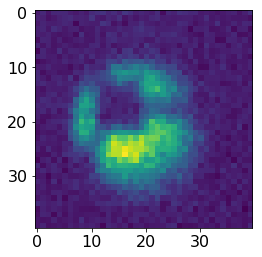

In [45]:
plt.imshow(scidata)

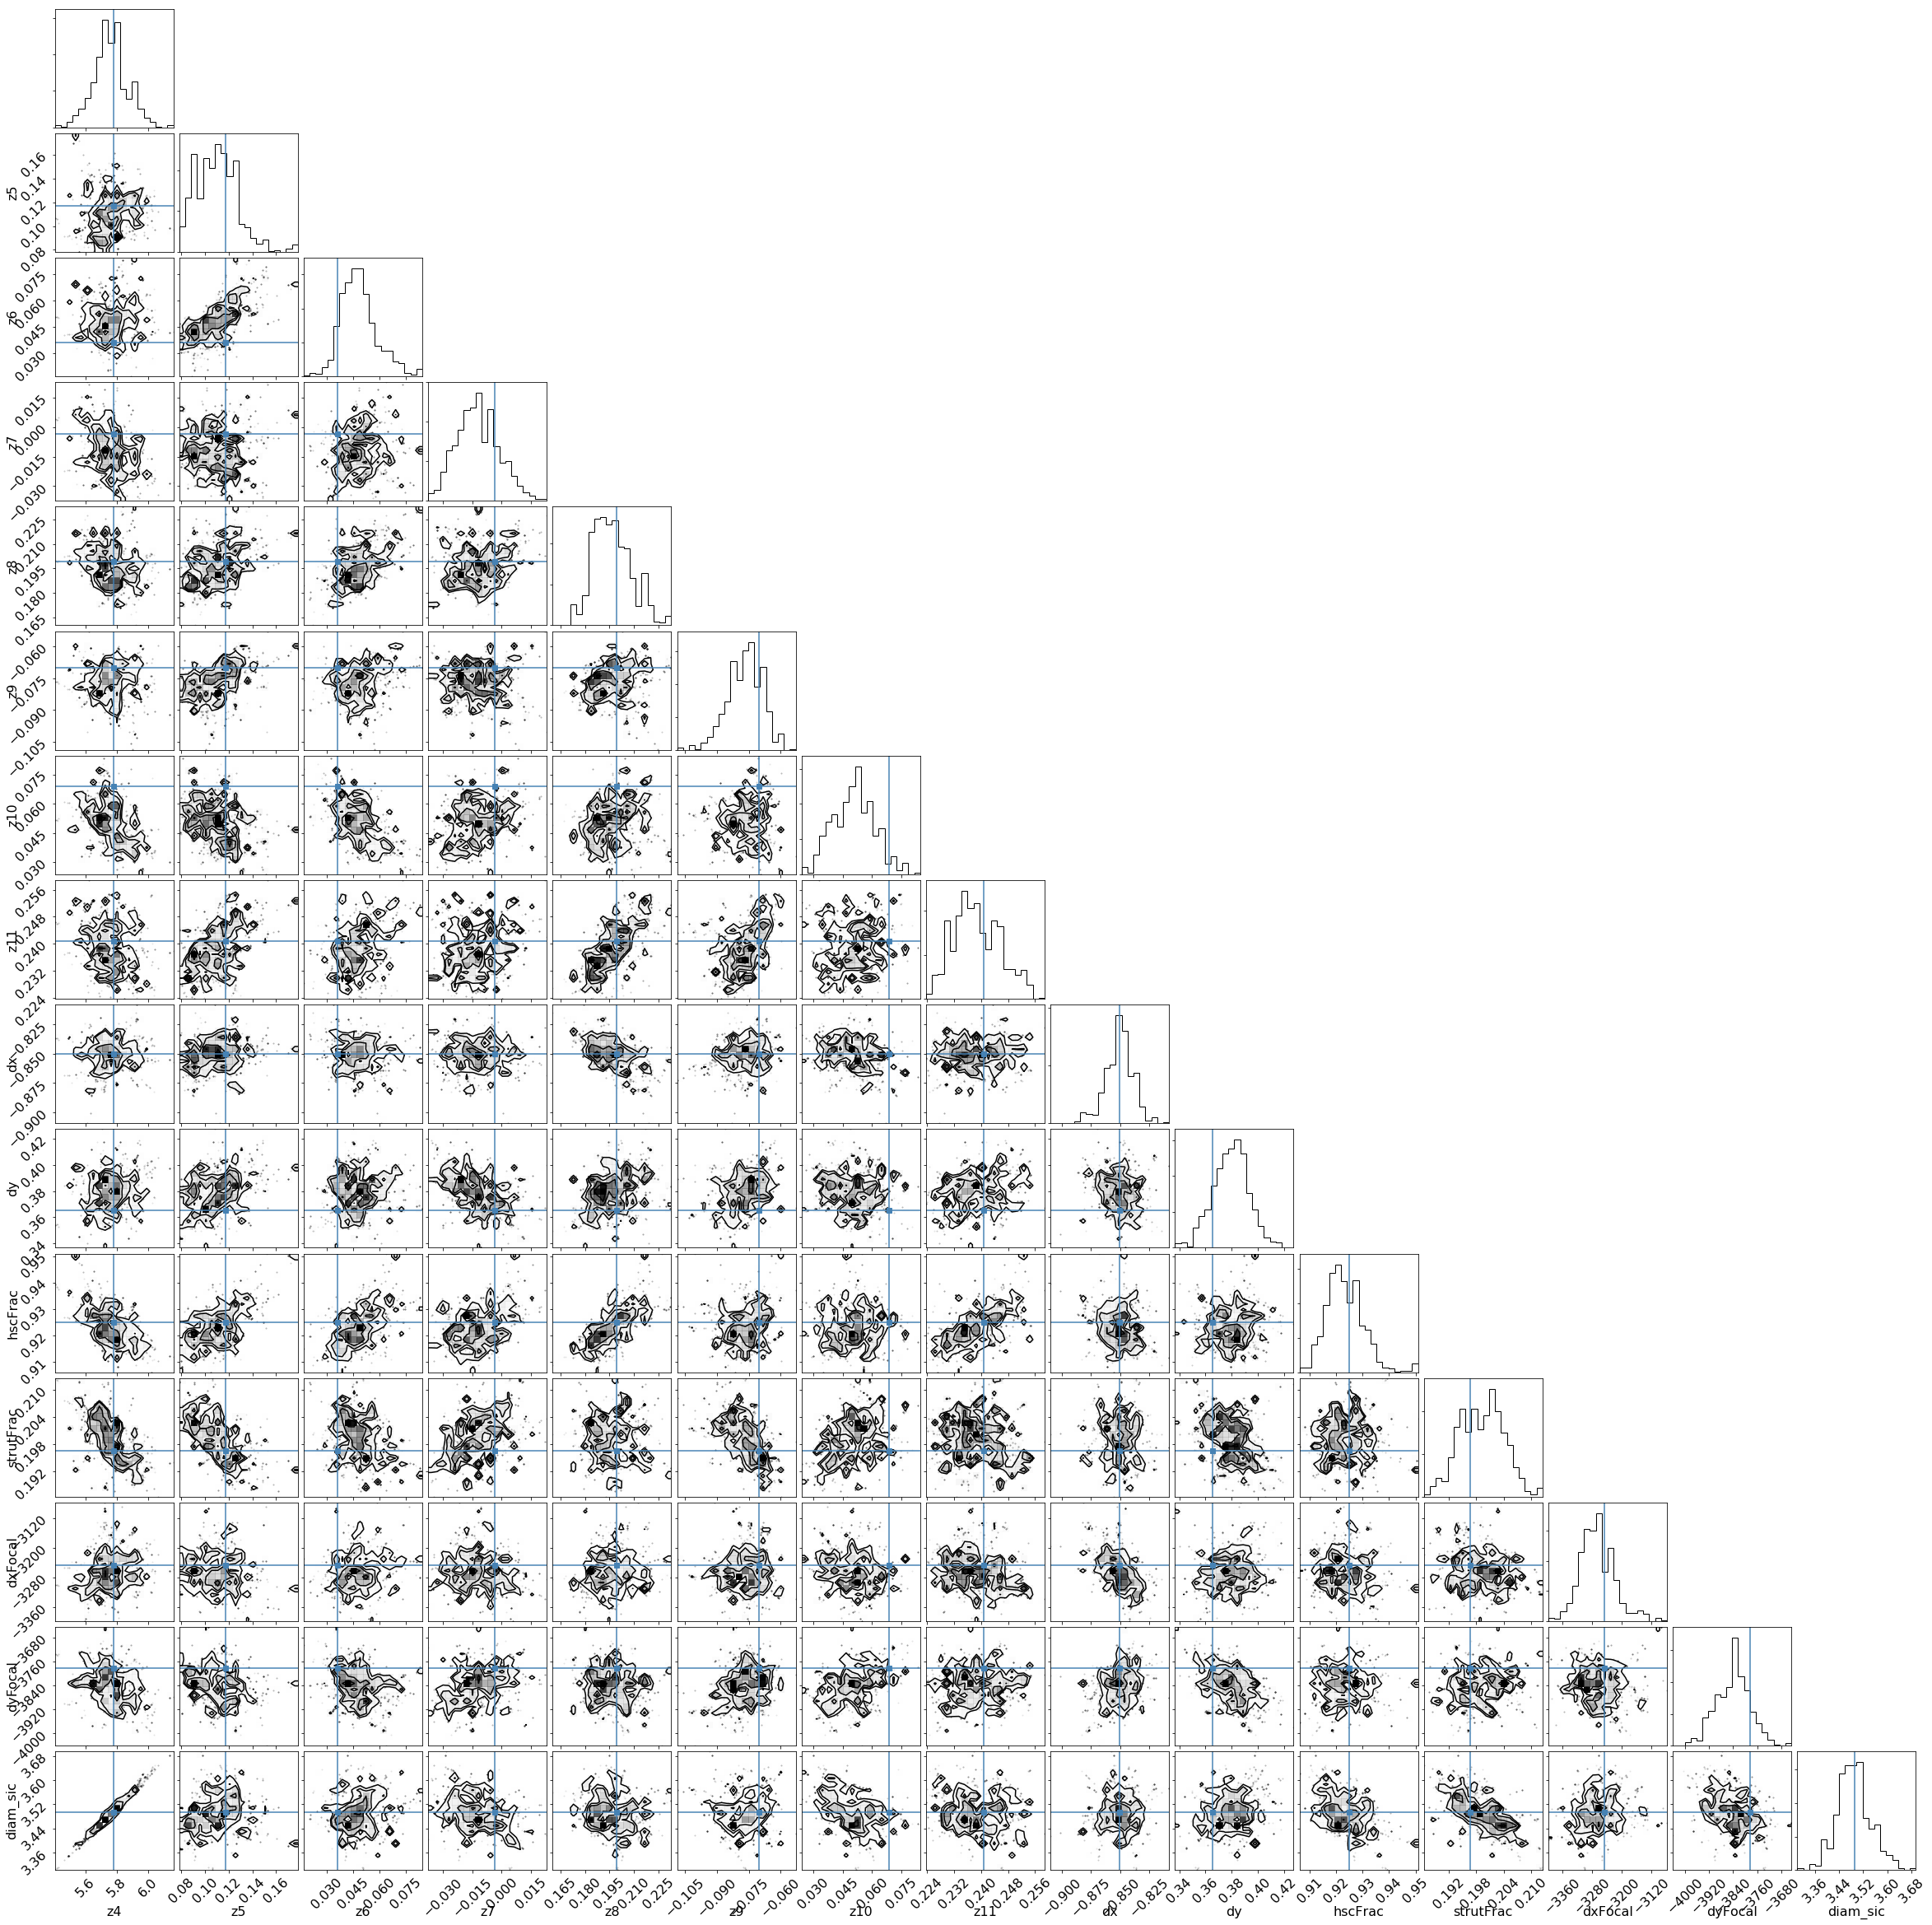

In [46]:
import corner
matplotlib.rcParams.update({'font.size': 16})
figure=corner.corner(flatchain_low,labels=['z4','z5','z6','z7','z8','z9','z10','z11','dx','dy','hscFrac',
                                              'strutFrac','dxFocal','dyFocal','diam_sic'],
                     truths=list(lowest_chi))
plt.savefig('/Users/nevencaplar/Documents/PFS/Images/Oct17/chainfail')

## Preparing Oct18 run

In [ ]:
# hm, hm, in zernike working

## Showing results

In [ ]:
single_donut_objects_index=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/single_donut_objects_index.npy")
single_number_for_single_pos=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/single_number_for_single_pos.npy")
single_number_for_single_pos_single_donut_split_by_y_appended=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/\
single_number_for_single_pos_single_donut_split_by_y_appended.npy")

In [79]:
import glob
import os
os.chdir("/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct18/")
list_of_chains=glob.glob("chain*")

In [93]:
single_donut_objects_index_analyzed=\
np.array((map(lambda x: int(string.split(string.split(x,'3617')[1],'.')[0]), list_of_chains)))

In [120]:
#Creating original poststamps
def create_original_post(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(single_number)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Original/'+str(single_number),scidata)
     
def create_m99_post():
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(0)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Original/'+str(-99),np.zeros(scidata.shape))
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Pupil/'+str(-99),np.zeros(scidata.shape))
    
def create_model_post(single_number):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct18/chainOct18_3617'
                  +str(single_number)+'.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct18/flatchainOct18_3617'
              +str(single_number)+'.npy')
    #Somehow!!!! first 10 values are total garbage - no clue what happened here
    #Seems to be fine in this iteration
    #flatchain=flatchain[10:].reshape(int(len(flatchain)/15),15)
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct18/likeflatchainOct18_3617'+str(single_number)+'.npy')
    #likeflatchain=likeflatchain[10:]
    chiflatchain=likeflatchain*(-2/(1600-16))
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            

    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    # Possible problem - likelihood has different shape than chain!    
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     
    
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/var3617'+
                    str(single_number)+'.npy')
    
    single_image_analysis=ZernikeFitter_PFS(scidata,vardata)
    #Setting these values has no influence!
    single_image_analysis.initParams(zmax=11,z4Init=0.0,
                                     centroidInit=(0.0,0.0),
                                     hscFracInit=0.0,strutFracInit=0.0,
                                     focalPlanePositionInit=(0,0),
                                     diam_sicInit=0,fiber_rInit=0)

    #x=manual_medians
    x=lowest_chi
    single_image_analysis.params['z4'].set(x[0])
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['dx'].set(x[8])
    single_image_analysis.params['dy'].set(x[9])
    single_image_analysis.params['hscFrac'].set(x[10])
    single_image_analysis.params['strutFrac'].set(x[11])
    single_image_analysis.params['dxFocal'].set(x[12])
    single_image_analysis.params['dyFocal'].set(x[13])
    single_image_analysis.params['diam_sic'].set(x[14])
    single_image_analysis.params['fiber_r'].set(x[15])

    best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)    
    best_img=best_img[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Model/'+str(single_number),best_img)
    
    single_image_analysis.params['z4'].set(0)
    single_image_analysis.params['z5'].set(x[1])
    single_image_analysis.params['z6'].set(x[2])
    single_image_analysis.params['z7'].set(x[3])
    single_image_analysis.params['z8'].set(x[4])
    single_image_analysis.params['z9'].set(x[5])
    single_image_analysis.params['z10'].set(x[6])
    single_image_analysis.params['z11'].set(x[7])
    single_image_analysis.params['dx'].set(x[8])
    single_image_analysis.params['dy'].set(x[9])
    single_image_analysis.params['hscFrac'].set(x[10])
    single_image_analysis.params['strutFrac'].set(x[11])
    single_image_analysis.params['dxFocal'].set(x[12])
    single_image_analysis.params['dyFocal'].set(x[13])
    single_image_analysis.params['diam_sic'].set(x[14])
    single_image_analysis.params['fiber_r'].set(x[15])

    best_img=single_image_analysis.best_image_Neven(single_image_analysis.params)    
    best_img=best_img[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Model0/'+str(single_number),best_img)
    
    
    Pupil=PFSPupilFactory(single_image_analysis.params['diam_sic'.format(i)].value,512,np.pi/2,
                          single_image_analysis.params['hscFrac'.format(i)].value,
                          single_image_analysis.params['strutFrac'.format(i)].value)
    point=Point2D(single_image_analysis.params['dxFocal'.format(i)].value,
              single_image_analysis.params['dyFocal'.format(i)].value)
    pupil=Pupil.getPupil(point)
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Pupil/'+str(single_number),pupil.illuminated)

def create_m99_model_post():
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(0)+'.npy')
    scidata=scidata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Model/'+str(-99),np.zeros(scidata.shape))     
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Model0/'+str(-99),np.zeros(scidata.shape))    
    
def create_residual_post(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(single_number)+'.npy')
    scidata=scidata[5:35,5:35]
    modeldata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct18/Model/'+str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/var3617'+
                    str(single_number)+'.npy')
    vardata=vardata[5:35,5:35]
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Residual/'+str(single_number),scidata-modeldata)
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Chi/'+str(single_number),((scidata-modeldata)**2)/vardata) 
     
def create_m99_residual_post():
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(single_number)+'.npy')
    scidata=scidata[5:35,5:35]
    modeldata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct18/Model/'+str(-99)+'.npy')
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Residual/'+str(-99),scidata-modeldata) 
    
def create_maxvalue(single_number):
    scidata=np.load('/Users/nevencaplar/Documents/PFS/Images/Oct18/Original/'+str(single_number)+'.npy')
    maxvalue=np.max(scidata)*1.2
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Original/maxvalue'+str(single_number),maxvalue)    
    
def create_m99_maxvalue():
    maxvalue=1
    np.save('/Users/nevencaplar/Documents/PFS/Images/Oct18/Original/maxvalue'+str(-99),maxvalue)  
  

In [58]:
%%capture
map(create_original_post, single_donut_objects_index_analyzed)
create_m99_post()
map(create_maxvalue, single_donut_objects_index_analyzed)
create_m99_maxvalue()

In [96]:
%%capture
map(create_model_post, single_donut_objects_index_analyzed)
create_m99_model_post()


In [122]:
%%capture
map(create_residual_post,single_donut_objects_index_analyzed)
create_m99_residual_post()

#### Creating single_number_for_single_pos_single_donut_split_by_y_appended

In [97]:
single_number_for_single_pos_single_donut=single_number_for_single_pos[single_donut_objects_index_analyzed]

In [98]:
single_number_for_single_pos_single_donut

array([[    0.,     0.,     0.,    84.,   683.],
       [    1.,     0.,     1.,    84.,   804.],
       [   10.,     1.,     1.,   462.,   824.],
       [  100.,     9.,    10.,  4006.,  3308.],
       [   11.,     1.,     2.,   462.,  1532.],
       [   12.,     1.,     3.,   462.,  1832.],
       [   14.,     1.,     5.,   462.,  2457.],
       [   15.,     1.,     6.,   462.,  2560.],
       [   16.,     1.,     7.,   462.,  2848.],
       [   17.,     1.,     8.,   462.,  3328.],
       [   18.,     2.,     0.,  1245.,   730.],
       [    2.,     0.,     2.,    84.,  1515.],
       [   20.,     2.,     2.,  1245.,  1556.],
       [   21.,     2.,     3.,  1245.,  1855.],
       [   23.,     2.,     5.,  1245.,  2479.],
       [   24.,     2.,     6.,  1245.,  2582.],
       [   25.,     2.,     7.,  1245.,  2869.],
       [   26.,     2.,     8.,  1245.,  3348.],
       [   27.,     3.,     0.,  1626.,   736.],
       [   28.,     3.,     1.,  1626.,   856.],
       [   29.,     

In [99]:
single_number_for_single_pos_single_donut_sorted_y=\
single_number_for_single_pos_single_donut[single_number_for_single_pos_single_donut[:,4].argsort()]

In [100]:
single_number_for_single_pos_single_donut_sorted_y

array([[   90.,     9.,     0.,  4006.,   153.],
       [   79.,     8.,     0.,  3620.,   177.],
       [   67.,     7.,     0.,  2843.,   206.],
       [   56.,     6.,     0.,  2461.,   215.],
       [   91.,     9.,     1.,  4006.,   676.],
       [    0.,     0.,     0.,    84.,   683.],
       [   80.,     8.,     1.,  3620.,   697.],
       [   68.,     7.,     1.,  2843.,   724.],
       [   18.,     2.,     0.,  1245.,   730.],
       [   57.,     6.,     1.,  2461.,   732.],
       [   27.,     3.,     0.,  1626.,   736.],
       [   47.,     5.,     0.,  2080.,   737.],
       [   37.,     4.,     0.,  2014.,   738.],
       [   92.,     9.,     2.,  4006.,   798.],
       [    1.,     0.,     1.,    84.,   804.],
       [   81.,     8.,     2.,  3620.,   819.],
       [   10.,     1.,     1.,   462.,   824.],
       [   69.,     7.,     2.,  2843.,   845.],
       [   58.,     6.,     2.,  2461.,   854.],
       [   28.,     3.,     1.,  1626.,   856.],
       [   48.,     

In [101]:
single_number_for_single_pos_single_donut_split_by_y=np.split(single_number_for_single_pos_single_donut_sorted_y, 
         np.where(np.diff(single_number_for_single_pos_single_donut_sorted_y[:,4]) > 40)[0] + 1)

In [103]:
# Row with most objects
longest=max(map(lambda x: len(x), single_number_for_single_pos_single_donut_split_by_y))
print(longest)

10


In [107]:
# I select now the first one, but in future I would need to decide how to selecrt 
represent_row=single_number_for_single_pos_single_donut_split_by_y[3]
print(len(represent_row))
represent_x_pos=np.sort(represent_row[:,3])

10


In [ ]:
single_number_for_single_pos_single_donut_split_by_y[1]

In [ ]:
represent_x_pos

In [108]:
single_number_single_row_x=\
single_number_for_single_pos_single_donut_split_by_y[1]
[single_number_for_single_pos_single_donut_split_by_y[1][:,3].argsort()]

[array([1, 4, 6, 8, 7, 5, 3, 2, 0])]

In [109]:
single_number_for_single_pos_single_donut_split_by_y_appended=[]

for j in range(0,len(single_number_for_single_pos_single_donut_split_by_y)):

    single_number_single_row_x=\
    single_number_for_single_pos_single_donut_split_by_y[j]
    [single_number_for_single_pos_single_donut_split_by_y[j][:,3].argsort()]

    single_number_single_row_x_appended=[[]]
    for i in range(0,len(represent_x_pos)):
        if np.any(np.in1d(single_number_single_row_x[:,3],represent_x_pos[i]))==True:  
            single_number_single_row_x_appended=np.append(single_number_single_row_x_appended,
                single_number_single_row_x[np.in1d(single_number_single_row_x[:,3],represent_x_pos[i])])
        else:
            single_number_single_row_x_appended=np.append(single_number_single_row_x_appended,[-99,-99,-99,
                                                                                               represent_x_pos[i],
                                                                                             np.round(np.mean(single_number_single_row_x[:,4]))])

    single_number_single_row_x_appended=\
    single_number_single_row_x_appended.reshape(int(len(single_number_single_row_x_appended)/5),5)
    single_number_for_single_pos_single_donut_split_by_y_appended.append(single_number_single_row_x_appended)
    
    
#single_number_single_row_x_appended=single_number_single_row_x_appended.reshape(
#    int(len(single_number_single_row_x_appended)/9),9)    

In [110]:
single_number_for_single_pos_single_donut_split_by_y_appended

[array([[  -99.,   -99.,   -99.,    84.,   188.],
        [  -99.,   -99.,   -99.,   462.,   188.],
        [  -99.,   -99.,   -99.,  1245.,   188.],
        [  -99.,   -99.,   -99.,  1626.,   188.],
        [  -99.,   -99.,   -99.,  2014.,   188.],
        [  -99.,   -99.,   -99.,  2080.,   188.],
        [   56.,     6.,     0.,  2461.,   215.],
        [   67.,     7.,     0.,  2843.,   206.],
        [   79.,     8.,     0.,  3620.,   177.],
        [   90.,     9.,     0.,  4006.,   153.]]),
 array([[    0.,     0.,     0.,    84.,   683.],
        [  -99.,   -99.,   -99.,   462.,   717.],
        [   18.,     2.,     0.,  1245.,   730.],
        [   27.,     3.,     0.,  1626.,   736.],
        [   37.,     4.,     0.,  2014.,   738.],
        [   47.,     5.,     0.,  2080.,   737.],
        [   57.,     6.,     1.,  2461.,   732.],
        [   68.,     7.,     1.,  2843.,   724.],
        [   80.,     8.,     1.,  3620.,   697.],
        [   91.,     9.,     1.,  4006.,   676.]

In [114]:
np.save("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct18/single_number_for_single_pos_single_donut_split_by_y_appended",
        single_number_for_single_pos_single_donut_split_by_y_appended)

### Displaying images

In [115]:
single_donut_objects_index=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/single_donut_objects_index.npy")
single_number_for_single_pos=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct17/single_number_for_single_pos.npy")
single_number_for_single_pos_single_donut_split_by_y_appended=\
np.load("/Users/nevencaplar/Documents/PFS/Fit_Results/Oct18/\
single_number_for_single_pos_single_donut_split_by_y_appended.npy")

In [137]:
def show_images(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle("v0003617, "+str(save), fontsize=60)
    for n, (image, title,maxvalue) in enumerate(zip(images, titles,maxvalues)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(np.abs(image),vmax=maxvalue/maxValueDivision)
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/8)      
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/Oct18/Summary/'+str(save))
      
        
  
        

In [140]:
def show_images_log(images, cols = 1, titles = None,save=None,maxvalues=None,maxValueDivision=None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    fig.suptitle("v0003617, "+str(save)+' /Log scaling', fontsize=60)
    for n, (image, title,maxvalue) in enumerate(zip(images, titles,maxvalues)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(np.abs(image),vmin=1,vmax=maxvalue/maxValueDivision, norm=LogNorm())
        a.set_title(title)
        a.tick_params(
            axis='both',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',
            left='off',
            right='off',
            top='off',         # ticks along the top edge are off
            labelbottom='off',
            labelleft='off') 

    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images/8)      
    if save==None:
        plt.show()
    else:
        plt.savefig('/Users/nevencaplar/Documents/PFS/Images/Oct18/Summary/'+str(save)+' Log')
      

In [117]:
plot_index=[]
for i in range(0,len(single_number_for_single_pos_single_donut_split_by_y_appended)):
    plot_index.append(single_number_for_single_pos_single_donut_split_by_y_appended[i][:,0])
plot_index = [item for sublist in plot_index for item in sublist]   


list_of_images=[]
for i in plot_index:
    list_of_images.append(np.load('/Users/nevencaplar/Documents/PFS/Images/Oct18/Original/'+str(int(i))+'.npy'))

list_of_maxvalues=[]
for i in plot_index:
    list_of_maxvalues.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct18/Original/maxvalue'+str(int(i))+'.npy'))        

list_of_titles=[]
for i in range(0,len(single_number_for_single_pos_single_donut_split_by_y_appended)):
    for j in range (0,len(single_number_for_single_pos_single_donut_split_by_y_appended[i])):
        list_of_titles.append(str((int(single_number_for_single_pos_single_donut_split_by_y_appended[i][j][3]),
                           int(4175-single_number_for_single_pos_single_donut_split_by_y_appended[i][j][4]))))

In [133]:
list_of_model_images=[]
for i in plot_index:
    list_of_model_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct18/Model/'+str(int(i))+'.npy'))        
    
        
list_of_residual_images=[]
for i in plot_index:
    list_of_residual_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct18/Residual/'+str(int(i))+'.npy'))     
    
                
list_of_pupil_images=[]
for i in plot_index:
    list_of_pupil_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct18/Pupil/'+str(int(i))+'.npy'))         
    
list_of_model0_images=[]
for i in plot_index:
    list_of_model0_images.append(\
    np.load('/Users/nevencaplar/Documents/PFS/Images/Oct18/Model0/'+str(int(i))+'.npy'))      
        
    
list_of_maxvalues_pupil=[]
for i in plot_index:
    list_of_maxvalues_pupil.append(2)   

In [138]:
%%capture
how_many_images=len(list_of_images)
print(how_many_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_images[0:how_many_images],int(how_many_images/10),save='Originals',
            maxvalues=list_of_maxvalues[0:how_many_images],
            titles=list_of_titles[0:how_many_images],maxValueDivision=1)

In [150]:
%%capture
how_many_images=len(list_of_images)
print(how_many_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_images[0:how_many_images],int(how_many_images/10),save='Originals',
            maxvalues=list_of_maxvalues[0:how_many_images],
            titles=list_of_titles[0:how_many_images],maxValueDivision=1)

In [125]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_model_images[0:how_many_images],
            int(how_many_images/10),save='Models',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [141]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_model_images[0:how_many_images],
            int(how_many_images/10),save='Models',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [126]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, no rescale',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [151]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, no rescale',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [127]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_residual_images[0:how_many_images],
            int(how_many_images/10),save='Residuals, rescaled factor 5',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=5)

In [130]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_pupil_images[0:how_many_images],
            int(how_many_images/10),save='Pupils',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues_pupil[0:how_many_images],maxValueDivision=2)

In [129]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images(list_of_model0_images[0:how_many_images],
            int(how_many_images/10),save='Models0',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [152]:
%%capture
how_many_images=len(list_of_images)
%config InlineBackend.rc = {}
matplotlib.rcParams.update({'font.size': 30})
show_images_log(list_of_model0_images[0:how_many_images],
            int(how_many_images/10),save='Models0',
            titles=list_of_titles[0:how_many_images],maxvalues=list_of_maxvalues[0:how_many_images],maxValueDivision=1)

In [146]:
list_of_residual_images[55][list_of_residual_images[55]<1]=1

In [149]:
list_of_residual_images[55]

array([[  4.13083982,   4.44983339,   8.99793148,   3.30135107,
          1.        ,   3.96628332,   2.73377275,   1.76871586,
          3.01216316,   7.99288225,   5.3412981 ,   7.68802595,
          2.95636249,   1.        ,   8.30626392,   6.86731148,
         12.51219749,   6.10841513,   5.43378305,   4.04406214,
          1.        ,   3.87580824,   5.60079718,   2.06916618,
          5.13987732,   1.        ,   5.08281422,   1.        ,
          4.82620144,   5.82663774],
       [  1.81042099,   5.80461264,   1.        ,   5.97159529,
          6.86274385,   1.        ,   6.02186346,   1.06744027,
          1.        ,   6.65373707,   6.3860445 ,   4.62447739,
          6.14623165,   4.53112841,   9.01564503,   5.18093538,
          3.64894462,   8.79908657,   1.        ,   7.00011539,
          5.71629715,   2.87404418,   8.54394054,   1.        ,
          5.5134387 ,   4.06392241,   7.82321692,   4.85215282,
          1.        ,   8.49141884],
       [  8.60508633,   4.3412

In [148]:
matplotlib.pyplot.close("all")

### Parameter dependence

#### Creating lowest_chi_pos

In [170]:
def lowest_chi_par(single_number):
    chain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct18/chainOct18_3617'
                  +str(single_number)+'.npy')
    flatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct18/flatchainOct18_3617'
              +str(single_number)+'.npy')
    #Somehow!!!! first 10 values are total garbage - no clue what happened here
    #Seems to be fine in this iteration
    #flatchain=flatchain[10:].reshape(int(len(flatchain)/15),15)
    likeflatchain=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/ResultsFromTiger/Oct18/likeflatchainOct18_3617'+str(single_number)+'.npy')
    #likeflatchain=likeflatchain[10:]
    scidata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/sci3617'+
                    str(single_number)+'.npy')
    vardata=np.load('/Users/nevencaplar/Documents/PFS/TigerAnalysis/CutsForTigerOct17/var3617'+
                    str(single_number)+'.npy')
    
    chiflatchain=likeflatchain*(-2/(1600-16))
    flatchain_low=flatchain[(-likeflatchain)<np.percentile(-likeflatchain,10)]
    
    #This creates flatchain which I think make a lot more sense; you can also define burn fraction
    burn_fraction=0.5
    for j in range(0,chain.shape[2]):
        manual_flatchain_1var=np.array([])
        for i in range(0,len(chain)):
            manual_flatchain_1var=np.append(manual_flatchain_1var,chain[i][:,j]
                                            [int(np.floor(chain.shape[1]*burn_fraction)):chain.shape[1]])

        manual_flatchain_1var=manual_flatchain_1var.ravel()

        if j==0:
            manual_flatchain=manual_flatchain_1var
        else:
            manual_flatchain=np.column_stack((manual_flatchain,manual_flatchain_1var))
            
    medians_low=np.apply_along_axis(np.median, 0, flatchain_low)
    medians=np.apply_along_axis(np.median, 0, flatchain)
    manual_medians=np.apply_along_axis(np.median, 0, manual_flatchain)
    # Possible problem - likelihood has different shape than chain!    
    lowest_chi=flatchain[-likeflatchain==np.min(-likeflatchain)][0]     
    low_chi=np.min(-likeflatchain)*(2)/(1600-15)
    maxchi2=np.sum(scidata**2/vardata)/(1600-15)
    
    #help_array=np.append(np.append(lowest_chi,low_chi),maxchi2)
    help_array=np.append(np.append(medians_low,low_chi),maxchi2)
    return np.append(help_array,single_number_for_single_pos[single_number])
    

In [171]:
lowest_chi_pos=[]
for i in single_donut_objects_index_analyzed:
    lowest_chi_pos=np.append(lowest_chi_pos,lowest_chi_par(i))

lowest_chi_pos=lowest_chi_pos.reshape(len(single_donut_objects_index_analyzed),23)
#Switch y axis from numpy to chip counting
lowest_chi_pos[:,22]=4175-lowest_chi_pos[:,22]

np.save('/Users/nevencaplar/Documents/PFS/Fit_Results/Oct18/lowest_chi_pos',lowest_chi_pos)

In [158]:
80*22

1760

#### Generate set of plots

In [167]:
single_number_for_single_pos_single_donut=single_number_for_single_pos[single_donut_objects_index_analyzed]

In [178]:
descriptions=['0_z4','1_z5','2_z6','3_z7','4_z8','5_z9','6_z10','7_z11','8_dx','9_dy','10_hscFrac','11_strutFrac',
              '12_dxFocal','13_dyFocal','14_teldiam','15_rfiber','16_chi**2', '17_chi**2 max', '18_unique index', 
              '19_fiber', '20_spot index', '21_xpos', '22_ypos']

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

for i in range(0,23):


    N = len(single_number_for_single_pos_single_donut)
    x = lowest_chi_pos[:,21]
    y = lowest_chi_pos[:,22]
    colors = lowest_chi_pos[:,i]
    area = np.pi * (15 * 1)**2  # 0 to 15 point radii

    if np.in1d([i],[1,2,3,4,5,6,7,8,9,12,13])[0] == True:
        abs_max_colors=max(np.abs(colors))
        max_colors=abs_max_colors
        min_colors=-abs_max_colors
    else:   
        max_colors=max(colors)
        min_colors=min(colors)

    plt.scatter(x, y, s=area, c=colors, cmap='seismic', alpha=1,vmin=min_colors, vmax=max_colors,edgecolor='black')
    plt.ylim(0,4416)
    plt.xlim(0,4294)
    plt.xlabel('x position on chip')
    plt.ylabel('y position on chip')
    plt.title(descriptions[i].split("_")[1])


    plt.colorbar()
    #plt.show()
    plt.savefig('/Users/nevencaplar/Documents/PFS/Images/Oct18/Summary/'+str(descriptions[i]))
    plt.clf()